In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.linear_model import Lasso
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, MaxPooling1D, Flatten, Conv1D, Reshape
from sklearn.model_selection import train_test_split
import copy
import json
import requests
import csv
import threading

In [2]:
start_date = '2016-10-01'
start_date = pd.to_datetime(start_date).date()
end_date = dt.date.today()
df = yf.download("AAPL", start=start_date, end=end_date, auto_adjust=True)
vix = yf.download("^VIX", start=start_date, end=end_date, auto_adjust=True)
df.columns = [i.lower() for i in df.columns]
df = df.join(vix['Close'], how='inner')
df = df.rename(columns={'Close': 'vix'})

df.index = pd.to_datetime(df.index)
df = df.resample('D').interpolate()

#load historical fear and greed data from fear-greed.csv
fear_greed_historical = pd.read_csv('fear-greed.csv')
fear_greed_historical = fear_greed_historical.drop(columns=['Open', 'High', 'Low'])
fear_greed_historical['Date'] = pd.to_datetime(fear_greed_historical['Date'])
fear_greed_historical['Date'] = fear_greed_historical['Date'].dt.date

#get latest fear and greed index data
url = 'https://api.alternative.me/fng/?limit=0'
response = requests.get(url)
data = response.text
data = json.loads(data)
values = [(int(entry['timestamp']), float(entry['value'])) for entry in data['data']]

fear_greed = pd.DataFrame(values, columns=['timestamp', 'fear_greed_index'])
fear_greed['Date'] = pd.to_datetime(fear_greed['timestamp'], unit='s')
fear_greed['Date'] = fear_greed['Date'].dt.date
fear_greed = fear_greed.drop(columns=['timestamp'])

#merge the fear_greed with the historical fear greed index with fear_greed having priority
fear_greed = pd.concat([fear_greed, fear_greed_historical], ignore_index=True)
fear_greed = fear_greed.drop_duplicates(subset=['Date'], keep='last')
fear_greed = fear_greed.set_index('Date')
fear_greed.index = pd.to_datetime(fear_greed.index)
fear_greed = fear_greed.sort_index()

df_end = df.index[-1]
# get rid of rows indexed by dates before the start of the stock data
fear_greed = fear_greed.loc[start_date:df_end]

#fill in the missing dates by copying values from the previous day
fear_greed = fear_greed.resample('D').interpolate()

df['fear_greed'] = fear_greed['fear_greed_index']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
df['daily_variation'] = (df['high'] - df['low'])/df['open']
df['timestamp'] = df.index.astype(np.int64) // 10**9
df['daily_return'] = df['close'].pct_change()
df['5day_return'] = df['close'].pct_change(periods=5)
df['15day_return'] = df['close'].pct_change(periods=15)
df['30day_return'] = df['close'].pct_change(periods=30)
df['60day_return'] = df['close'].pct_change(periods=60)
df['7day_sma'] = df['close'].rolling(window=7).mean()
day7_sma = df['close'].rolling(window=7).mean()
df['7day_std'] = df['close'].rolling(window=7).std()
day7_std = df['close'].rolling(window=7).std()
df['7day_sma+2std'] = day7_sma + 2*day7_std
df['7day_sma-2std'] = day7_sma - 2*day7_std
df['high_close_diff'] = df['high'] - df['close']
df['low_open_diff'] = df['low'] - df['open']
df['14day_ema'] = df['close'].ewm(span=14, adjust=False).mean()
df['macd'] = df['close'].ewm(span=12, adjust=False).mean() - df['close'].ewm(span=26, adjust=False).mean()
df['stochastic_oscillator'] = (df['close'] - df['low'].rolling(window=14).min()) / (df['high'].rolling(window=14).max() - df['low'].rolling(window=14).min())
df['atr'] = df[['high', 'low', 'close']].apply(lambda x: max(x['high'] - x['low'], abs(x['high'] - np.roll(x['close'], 1)), abs(x['low'] - np.roll(x['close'], 1))), axis=1)
df['cci'] = (df['close'] - df['close'].rolling(window=20).mean()) / (0.015 * df['close'].rolling(window=20).std())
df['williams_r'] = (df['high'].rolling(window=14).max() - df['close']) / (df['high'].rolling(window=14).max() - df['low'].rolling(window=14).min())
df['bollinger_bands'] = (df['close'] - df['close'].rolling(window=20).mean()) / (2 * df['close'].rolling(window=20).std())
df['price_rate_of_change'] = df['close'].pct_change(periods=9)
df['momentum'] = df['close'] - df['close'].shift(4)
df['roc'] = (df['close'] - df['close'].shift(12)) / df['close'].shift(12)
df['obv'] = (df['volume'] * np.sign(df['close'].diff())).cumsum()
obv = (df['volume'] * np.sign(df['close'].diff())).cumsum()
df['obv_ema'] = obv.ewm(span=20, adjust=False).mean()
df['obv_roc'] = df['obv'].pct_change()
df['month'] = df.index.month
df['quarter'] = df.index.quarter

# df.drop(columns=['open', 'volume', 'high', 'low'], inplace=True)

#getting rid of NaN rows 
# print(df[df.isna().any(axis=1)])
df = df.dropna()

In [4]:
# you need to run this \/ (to be added to anaconda)
# pip install nltk 

nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

articles = pd.read_csv('articles.csv')

articles_dict = {}
for index, row in articles.iterrows():
    date = row['date']
    if date in articles_dict:
        articles_dict[date].append(row['title'])
    else:
        articles_dict[date] = [row['title']]

sentiments = []
for index, row in df.iterrows():    
    date = index.strftime('%Y-%m-%d')
    sentiment = 0
    count = 0
    if date in articles_dict:
        for article in articles_dict[date]:
            sentiment += analyzer.polarity_scores(article)['compound']
            count += 1
    if (count > 0):
        sentiment = sentiment / count
    sentiments.append(sentiment)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\48503\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
# print non zero sentiments
non_zero_sentiments = [sentiment for sentiment in sentiments if sentiment != 0]
print(non_zero_sentiments)
print(sentiments)
df['sentiment'] = sentiments

[0.1779, -0.3182, 0.18386666666666668, 0.12734, 0.23537999999999998, -0.11234999999999998, 0.4201, 0.06743333333333333, 0.1278, 0.1147083333333333, 0.06620000000000001, 0.08895, -0.32389999999999997, 0.10846, 0.4074, 0.09276666666666666, 0.264025, 0.3767, -0.14920000000000003, 0.43392499999999995, 0.044475, 0.5994, 0.1779, 0.14894285714285713, -0.26934, -0.05403333333333334, 0.08084, 0.28595, 0.093, 0.04845384615384617, -0.09090000000000001, -0.2023, 0.36605, 0.6078749999999999, -0.23835, 0.22555, 0.3612, 0.1806, 0.012499999999999999, 0.47569999999999996, 0.1027, -0.3412, 0.2899, 0.12050000000000001, 0.20966666666666667, -0.19466, 0.08954375, -0.33140000000000003, -0.32321999999999995, 0.075925, -0.1606, 0.21148333333333333, 0.2732, 0.7003, -0.22116250000000004, -0.10115, 0.258125, 0.0593, 0.007466666666666659, -0.23422500000000002, 0.3998, 0.24039999999999997, 0.1779, 0.3481, 0.2643666666666667, -0.1237, 0.1909, 0.2817, 0.07585, 0.03026, 0.10015714285714286, -0.06276999999999998, 0.17

In [6]:

# evaluate the relevance of features using non-neural network models
return_period = 5
X = df
#make y be the percentage return in 5 days
y = df['close'].pct_change(periods = -return_period)
#drop the first 5 rows of y
y = y.iloc[return_period:]
#drop the last 5 rows of y
y = y.iloc[:-return_period]
#drop the first 5 rows of x
X = X.iloc[return_period:]
#drop the last 5 rows of x
X = X.iloc[:-return_period]

# #show nan rows in x 
# rows_with_nan = X[X.isnull().any(axis=1)]
# print(rows_with_nan)

data = pd.concat([X, y], axis=1)

# #mutual information
# mi = mutual_info_regression(X, y)

# #kBest
# test = SelectKBest(score_func=f_regression, k='all')
# fit = test.fit(X, y)

# #lasso
# lasso = Lasso(alpha=0.1)
# lasso.fit(X, y)
# coef = np.abs(lasso.coef_)

# #random forest
# rnd_clf = RandomForestRegressor(n_estimators=500, n_jobs=-1)
# rnd_clf.fit(X, y)

# #fishers score
# fisher_score = f_regression(X, y)

# results = pd.DataFrame({'feature': X.columns.values, 'mi': mi,'rnd': rnd_clf.feature_importances_, 'kBest': fit.scores_, 'lasso': coef, 'fisher': fisher_score[0]})

# #scale the results to be able to compare them
# results['mi'] = results['mi']/results['mi'].max()
# results['rnd'] = results['rnd']/results['rnd'].max()
# results['kBest'] = results['kBest']/results['kBest'].max()
# results['lasso'] = results['lasso']/results['lasso'].max()
# results['fisher'] = results['fisher']/results['fisher'].max()

# # output the results in a graph with columns representing each method next to each other
# results.plot(x='feature', y=['mi', 'rnd', 'kBest', 'lasso', 'fisher'], kind='bar', figsize=(20,10))
# plt.show()

# #show the amount of rows
# # print(df.info())

# # print(data)
    

In [7]:
from sklearn.metrics import mean_absolute_error

def create_enhanced_lstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(50))
    model.add(Dropout(0.2))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def create_cnn_lstm_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Reshape((1, -1)))
    model.add(LSTM(50))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def evaluate_features(X_train, y_train, columns, baseline_model):
    # get indices at 50%, 60%, 70%, 80% of the dataset by splitting X_train and y_train
    indices = [int(len(X_train) * i) for i in [0.6, 0.7, 0.8]]
    counter = -1
    feature_importances = np.zeros(X_train.shape[2])
    baseline_performance = np.zeros(len(indices))   

    for index in indices:
        counter = counter + 1
        X_train_subset = X_train[:index]
        y_train_subset = y_train[:index]
        X_val = X_train[index:index+400]
        y_val = y_train[index:index+400]

        #baseline model
        baseline_model.fit(X_train_subset, y_train_subset, epochs=300, batch_size=2197, verbose=0)
    
        # Evaluate baseline model
        baseline_performance[counter] = baseline_model.evaluate(X_val, y_val, verbose=0)

        for i in range(X_train.shape[2]):
            # Permute the values of the ith feature
            X_test_permuted = copy.deepcopy(X_val)
            np.random.shuffle(X_test_permuted[:, 0, i])
            
            # Evaluate the model with the permuted feature
            permuted_performance = baseline_model.evaluate(X_test_permuted, y_val, verbose=0)
                        
            # Calculate the importance
            importance = permuted_performance - baseline_performance[counter]
            feature_importances[i] = feature_importances[i] + importance

        if counter == len(indices) - 1:
            print("Average baseline performance: ", baseline_performance.sum() / len(indices))
            feature_importances = feature_importances / len(indices)
            feature_data = pd.DataFrame({'feature': columns, 'importance': feature_importances})
            feature_data = feature_data.sort_values(by='importance', ascending=False)
            feature_data.plot(x='feature', y=['importance'], kind='bar', figsize=(20,10))
            plt.show()

            # plot the actual data against the predicted data
            y_pred = baseline_model.predict(X_val)
            y_pred = y_pred.flatten()
            
            # Calculate correlation coefficient
            correlation_coefficient = np.corrcoef(y_val, y_pred)[0, 1]
            print(f'Correlation coefficient: {correlation_coefficient}')
            
            # Calculate residuals
            residuals = y_val - y_pred
            
            # Plot regression line
            plt.figure(figsize=(20, 10))
            plt.scatter(y_val, y_pred)
            plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
            plt.title('Actual vs Predicted Returns')
            plt.xlabel('Actual Returns')
            plt.ylabel('Predicted Returns')
            plt.show()
            
            # Error metrics
            mae = mean_absolute_error(y_val, y_pred)
            mse = mean_squared_error(y_val, y_pred)
            rmse = np.sqrt(mse)
            print(f'Mean Absolute Error: {mae}')
            print(f'Mean Squared Error: {mse}')
            print(f'Root Mean Squared Error: {rmse}')
            
            # Confidence Intervals
            confidence_interval = 1.96 * np.std(residuals)
            print(f'95% Confidence Interval: +/- {confidence_interval}')

    return feature_data, (baseline_performance.sum() / len(indices)), correlation_coefficient, mae, mse, rmse, confidence_interval

def evaluate_optimal_number_of_features(X_train, y_train, columns, model_index):
    #split training data into training and validation data
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    features_used = []
    model_performances = []
    correlation_coefficients = []
    mean_absolute_errors = []
    mean_squared_errors = []
    root_mean_squared_errors = []
    confidence_intervals_95_percent = []
    current_datetime = dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    csv_file = f"feature_evaluation_{model_index}_{current_datetime}.csv"

    if model_index == 1:
        model = create_enhanced_lstm_model((X_train.shape[1], X_train.shape[2]))
    elif model_index == 2:
        model = create_gru_model((X_train.shape[1], X_train.shape[2]))
    elif model_index == 3:
        model = create_cnn_lstm_model((X_train.shape[1], X_train.shape[2]))

    feature_data, performance, correlation_coefficient, mae, mse, rmse, confidence_interval = evaluate_features(X_train, y_train, columns, model)

    features_used.append(feature_data['feature'][:].values)
    model_performances.append(performance)
    correlation_coefficients.append(correlation_coefficient)
    mean_absolute_errors.append(mae)
    mean_squared_errors.append(mse)
    root_mean_squared_errors.append(rmse)
    confidence_intervals_95_percent.append(confidence_interval)

    # train model with decreasing number of features by removing the least important feature
    for i in range(X_train.shape[2]-1, 1, -1):
        print(f'Feature {i} out of {X_train.shape[2]}')
        # get the indices of the most important features
        important_features = feature_data['feature'][:i].index
        X_train_subset = X_train[:, :, important_features]
        X_val_subset = X_val[:, :, important_features]

        if model_index == 1:
            model = create_enhanced_lstm_model((X_train_subset.shape[1], X_train_subset.shape[2]))
        elif model_index == 2:
            model = create_gru_model((X_train_subset.shape[1], X_train_subset.shape[2]))
        elif model_index == 3:
            model = create_cnn_lstm_model((X_train_subset.shape[1], X_train_subset.shape[2]))
        
        feature_data, performance, correlation_coefficient, mae, mse, rmse, confidence_interval = evaluate_features(X_train_subset, y_train, feature_data['feature'][:i], model)

        features_used.append(feature_data['feature'][:i].values)
        model_performances.append(performance)
        correlation_coefficients.append(correlation_coefficient)
        mean_absolute_errors.append(mae)
        mean_squared_errors.append(mse)
        root_mean_squared_errors.append(rmse)
        confidence_intervals_95_percent.append(confidence_interval)
        
         # write results to csv file
        with open(csv_file, mode='w') as file:
            writer = csv.writer(file)
            writer.writerow(['Features Used', 'Model Performance', 'Correlation Coefficient', 'Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error', '95% Confidence Interval'])
            writer.writerow([feature_data['feature'][:i].values, performance, correlation_coefficient, mae, mse, rmse, confidence_interval])

c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0013347971253097057


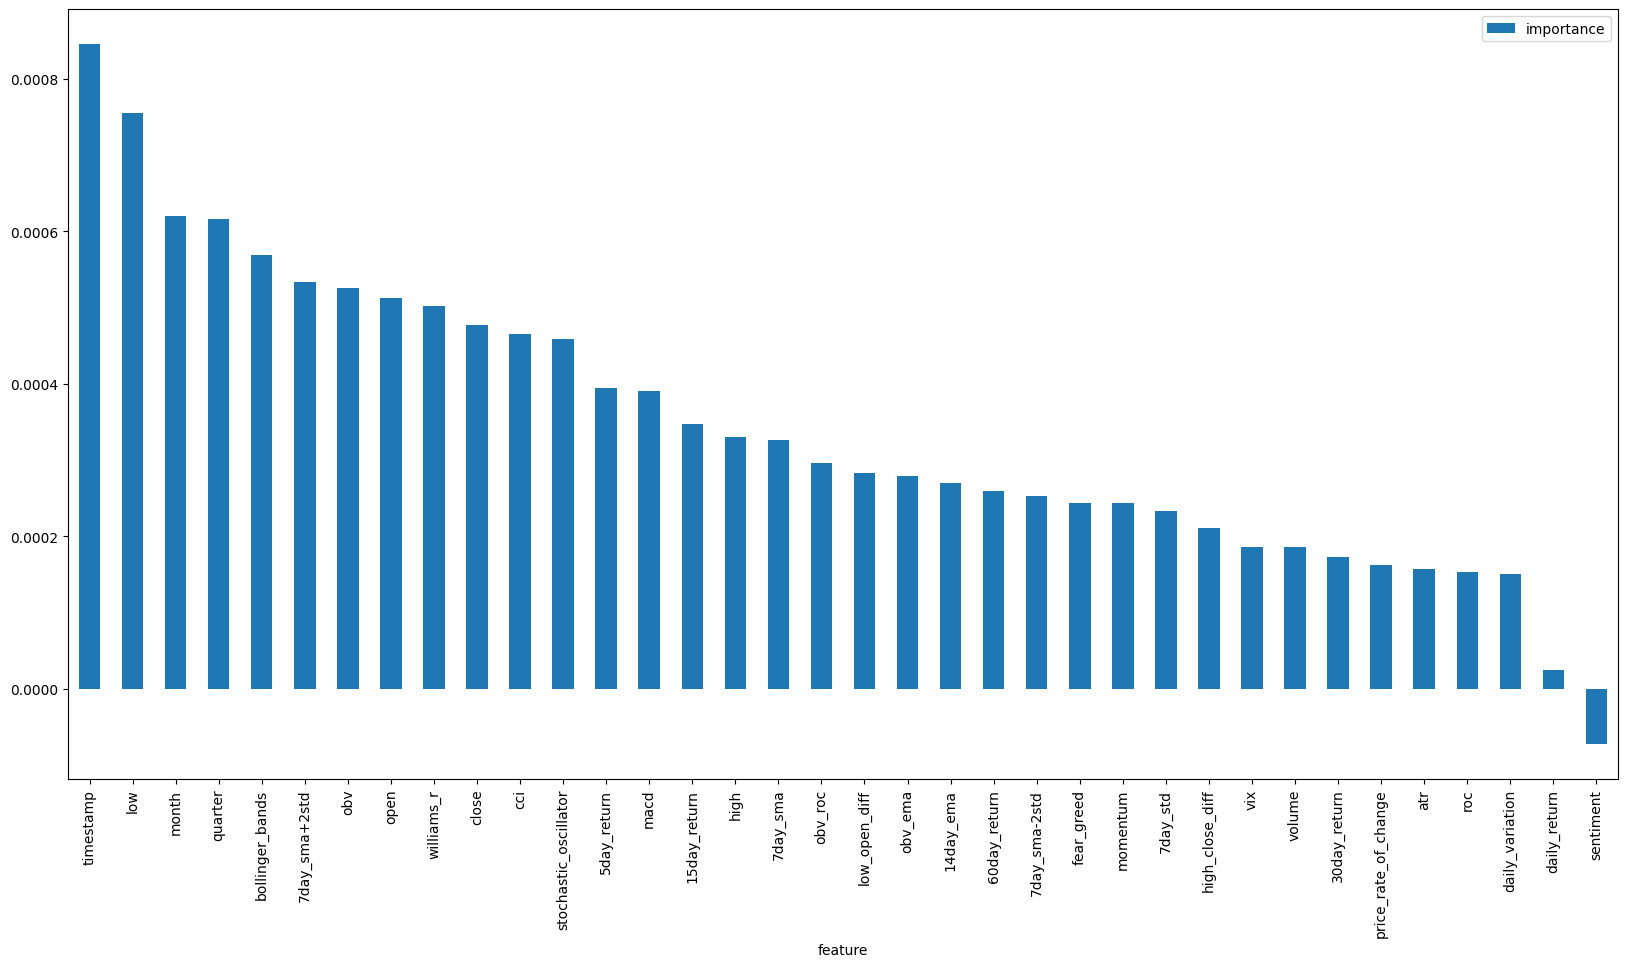

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Correlation coefficient: 0.3554123834726653


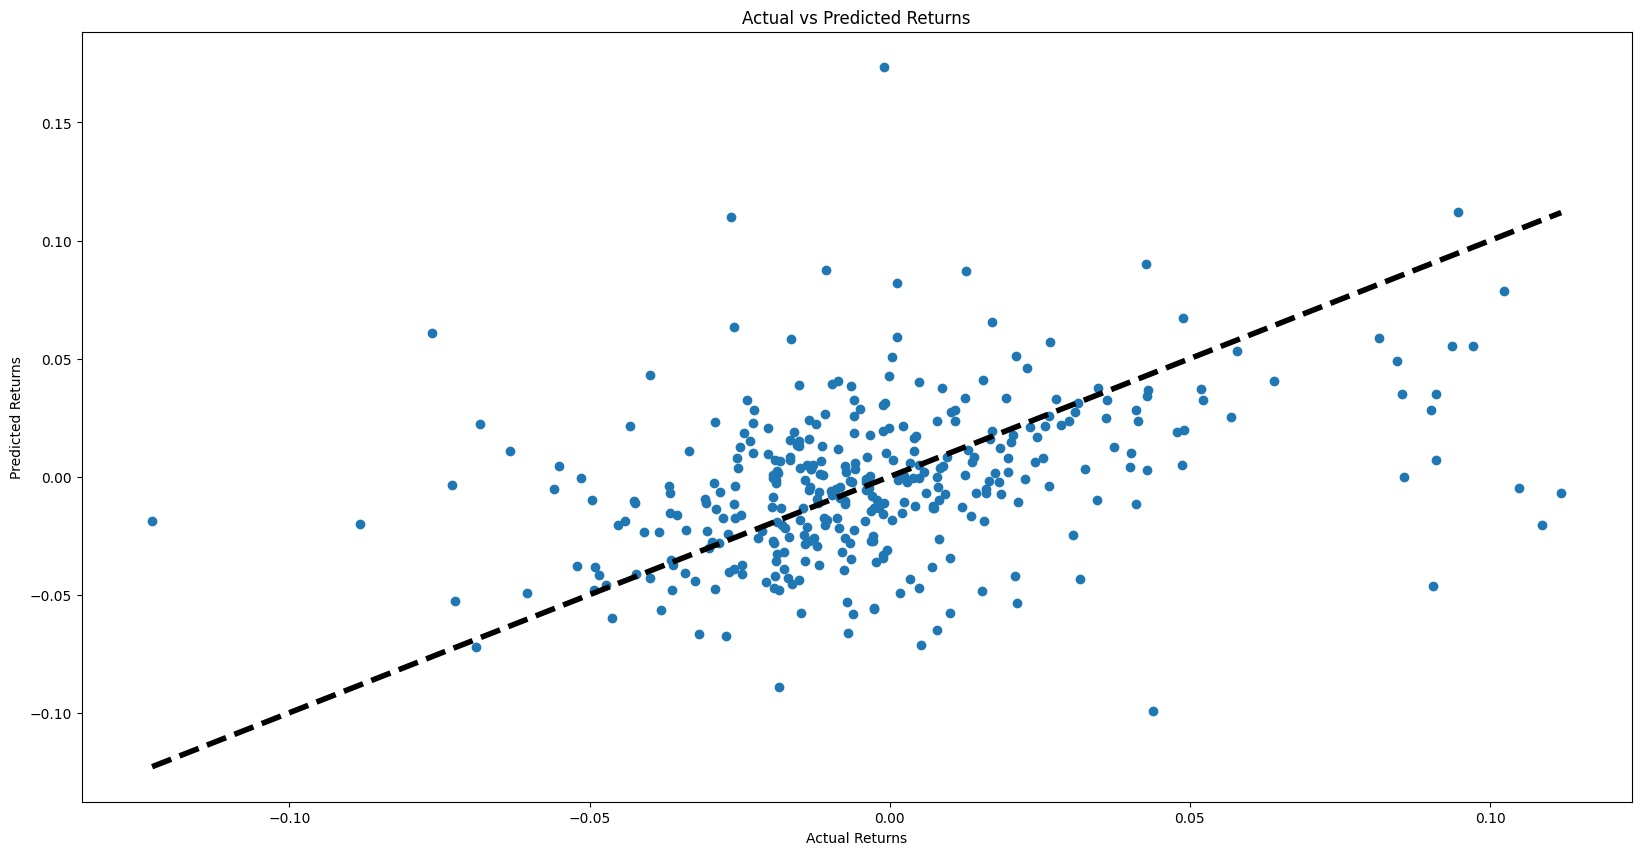

Mean Absolute Error: 0.02655127949045931
Mean Squared Error: 0.001397002329465289
Root Mean Squared Error: 0.0373764943442438
95% Confidence Interval: +/- 0.0732560195050474
Feature 35 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0011773667065426707


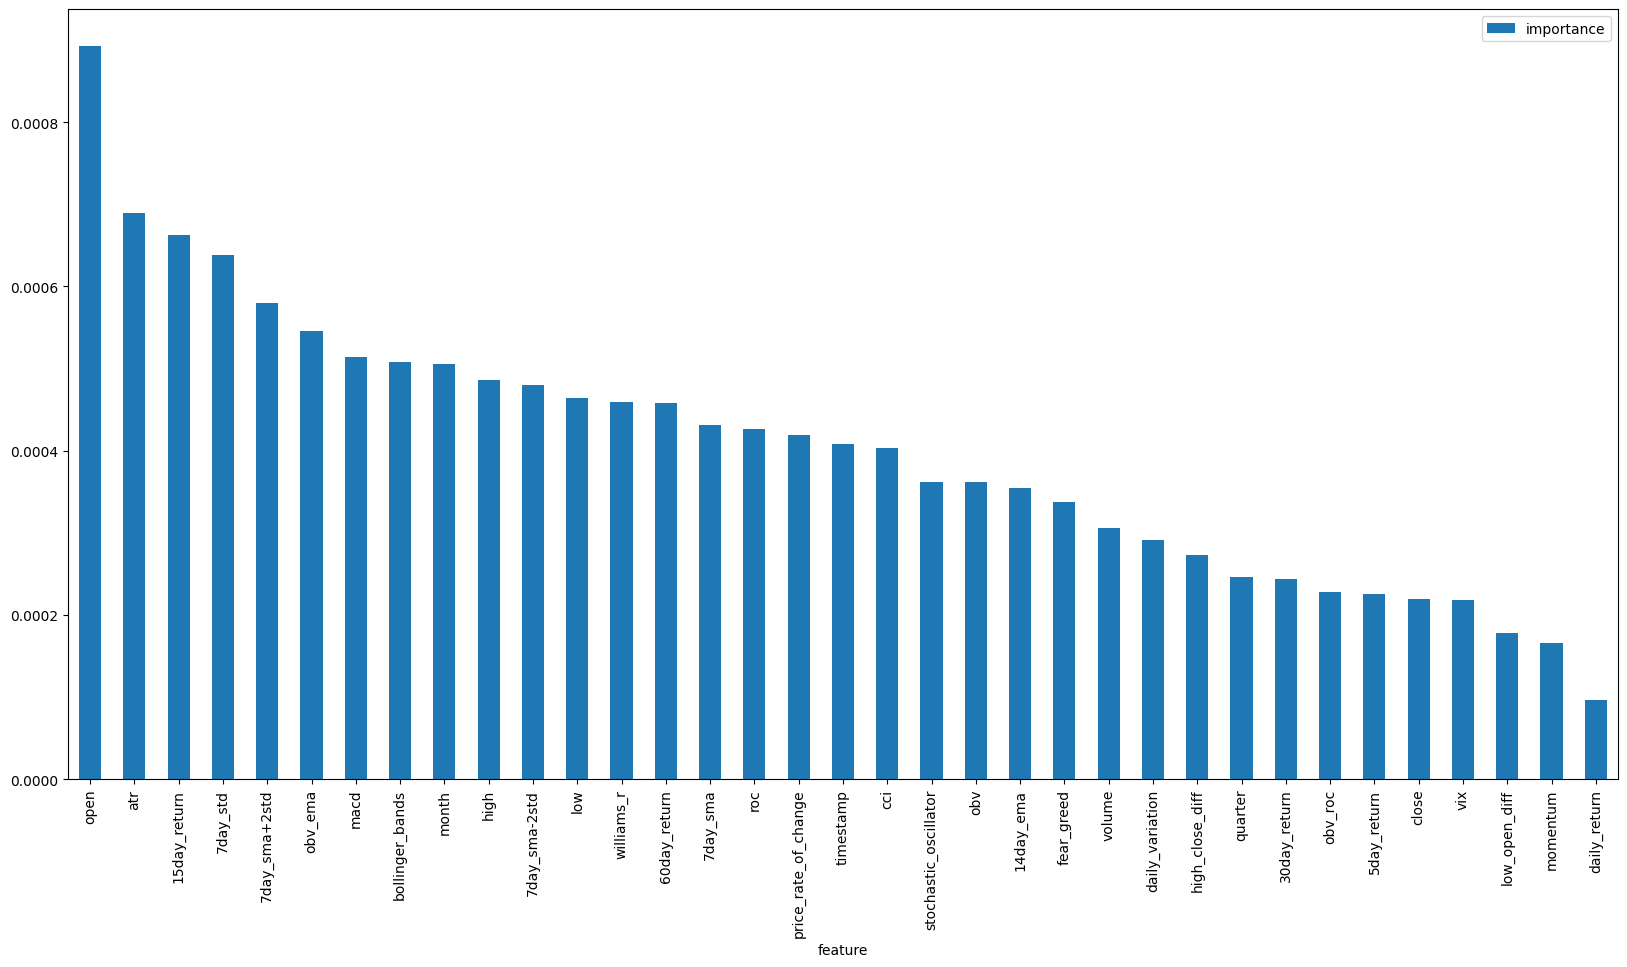

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Correlation coefficient: 0.4473511935346629


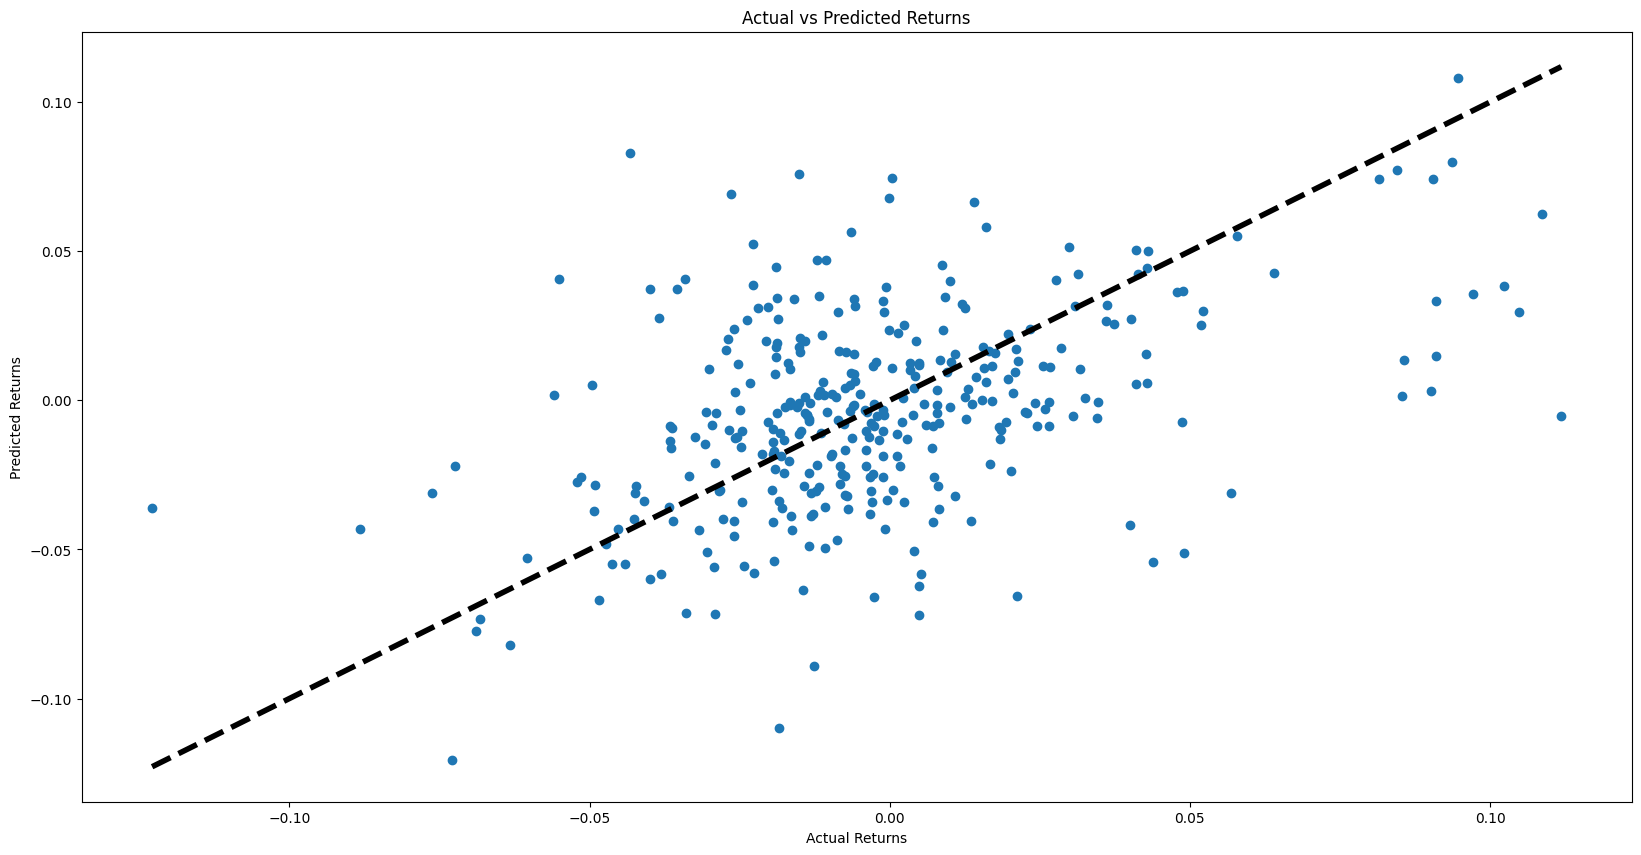

Mean Absolute Error: 0.02578080332020817
Mean Squared Error: 0.0011967787360139238
Root Mean Squared Error: 0.03459448996609032
95% Confidence Interval: +/- 0.06772859658162922
Feature 34 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0013368834430972736


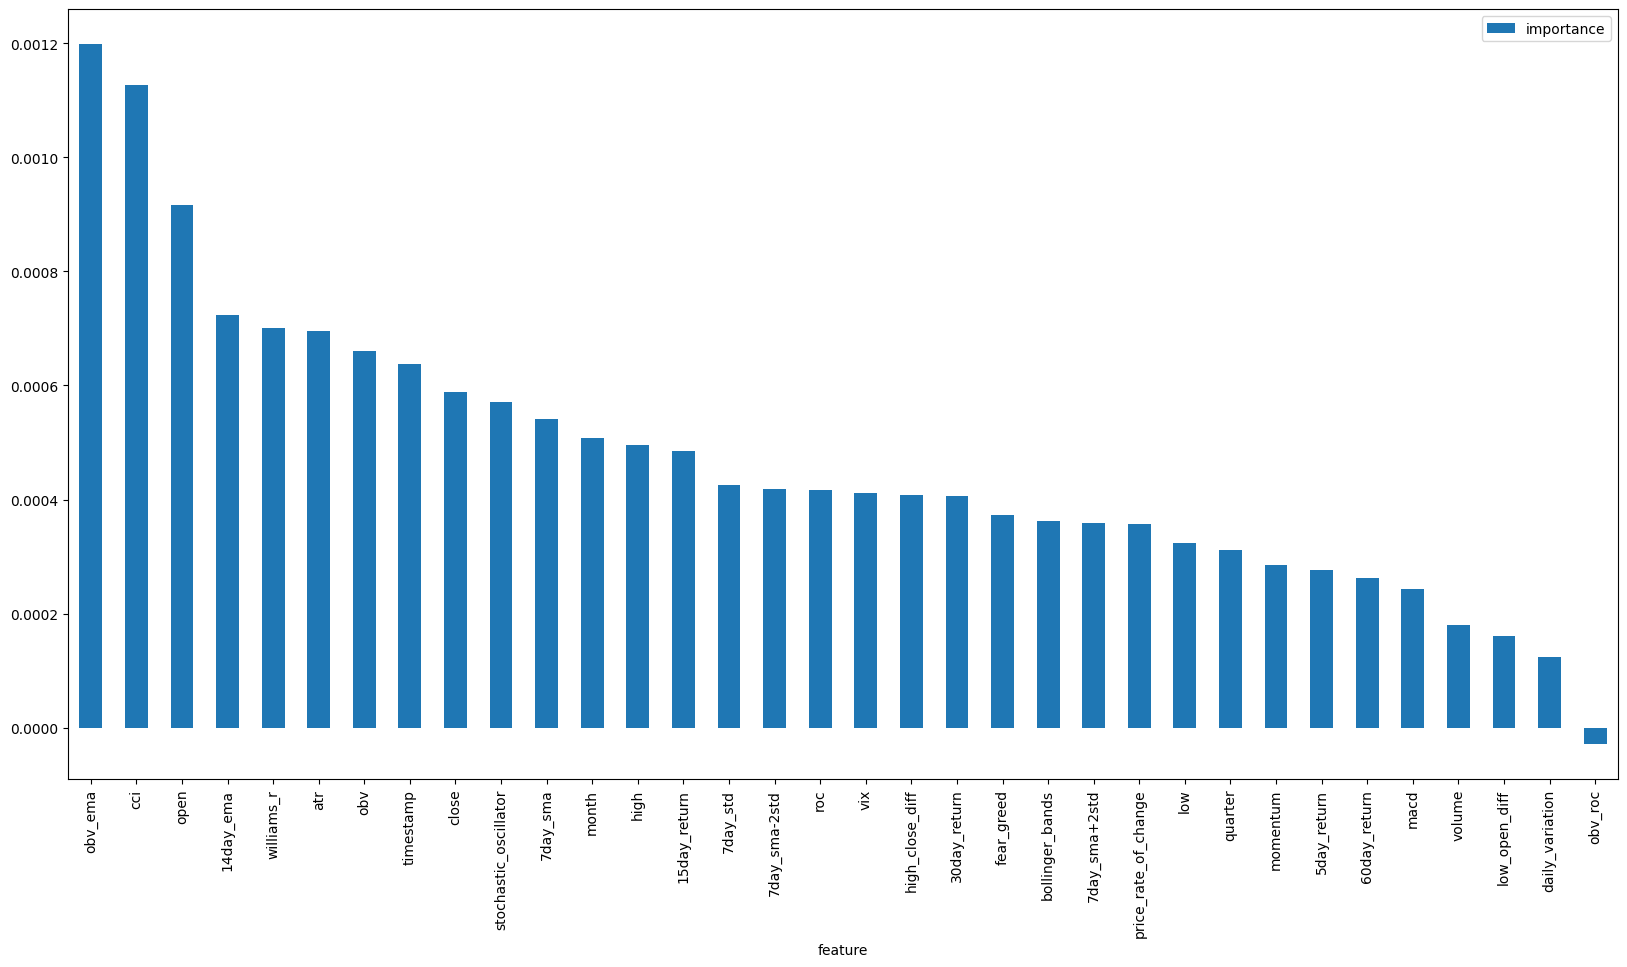

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Correlation coefficient: 0.3354618278602333


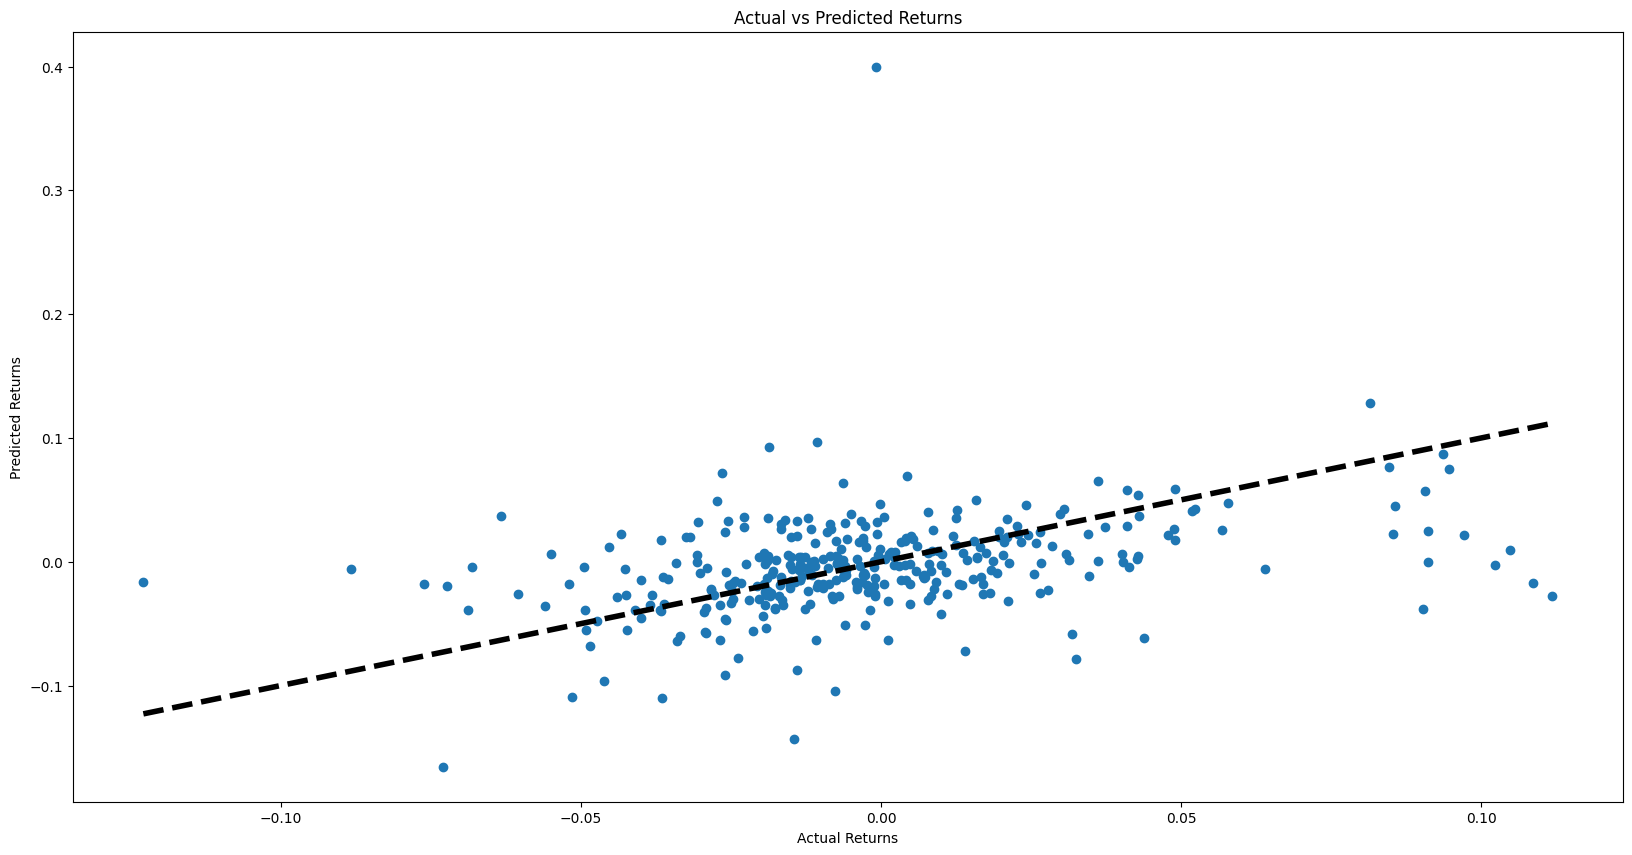

Mean Absolute Error: 0.027357603114202284
Mean Squared Error: 0.0018260933063956129
Root Mean Squared Error: 0.04273281299418063
95% Confidence Interval: +/- 0.0836748639402586
Feature 33 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.001034246039732049


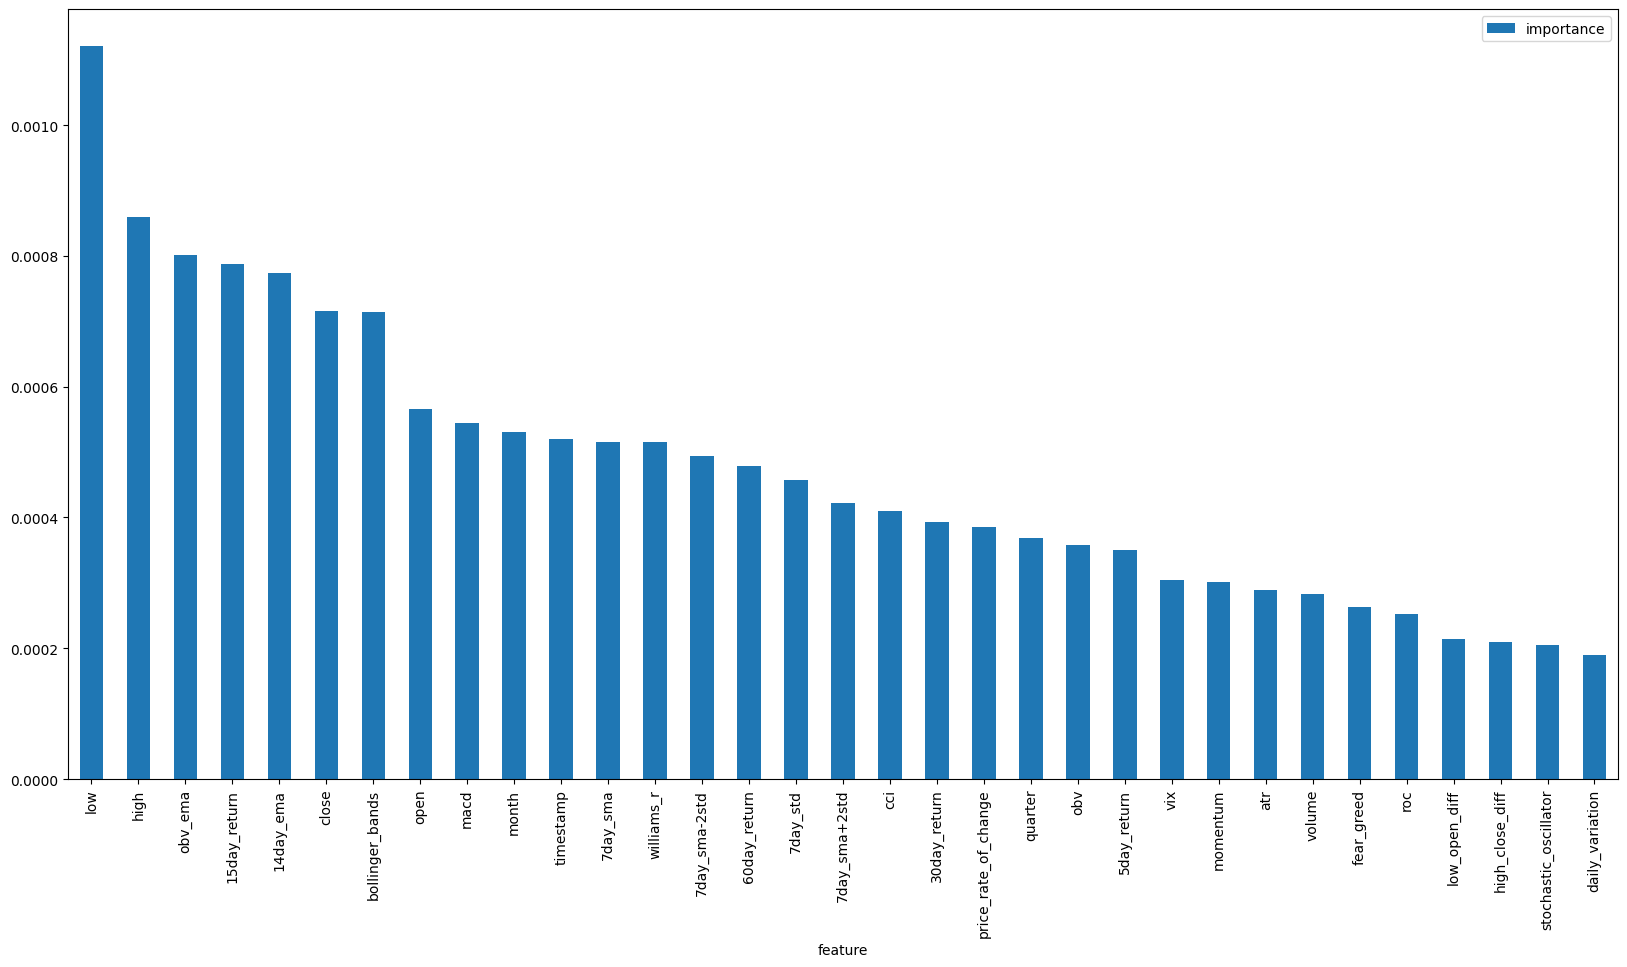

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Correlation coefficient: 0.3998044562373433


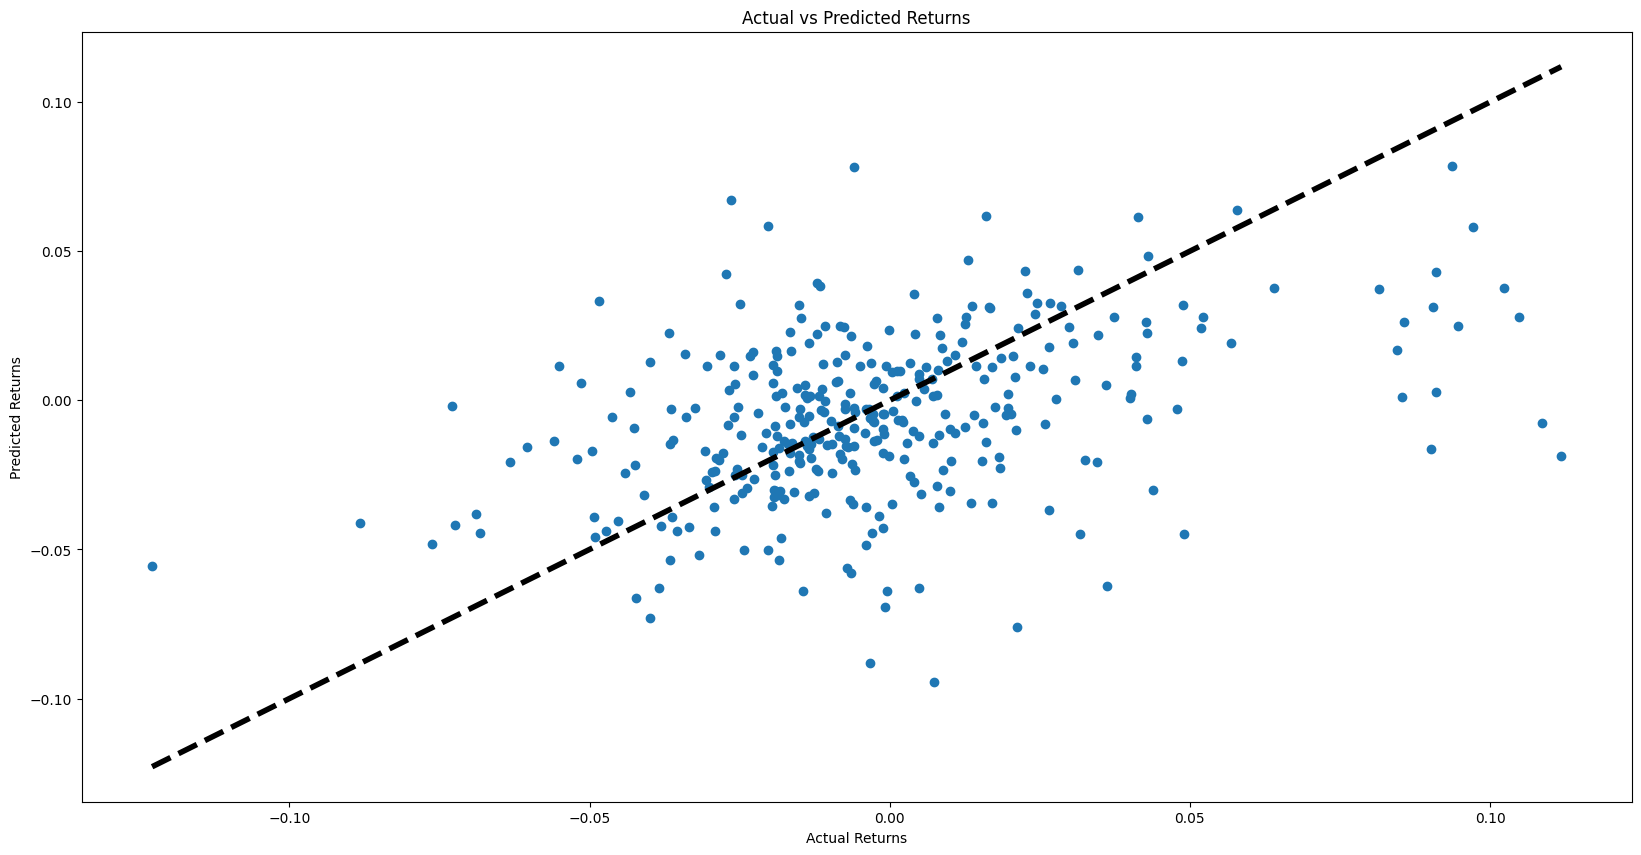

Mean Absolute Error: 0.02428631604332858
Mean Squared Error: 0.001111331443255946
Root Mean Squared Error: 0.03333663815167849
95% Confidence Interval: +/- 0.06491925384220092
Feature 32 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0009680153840842346


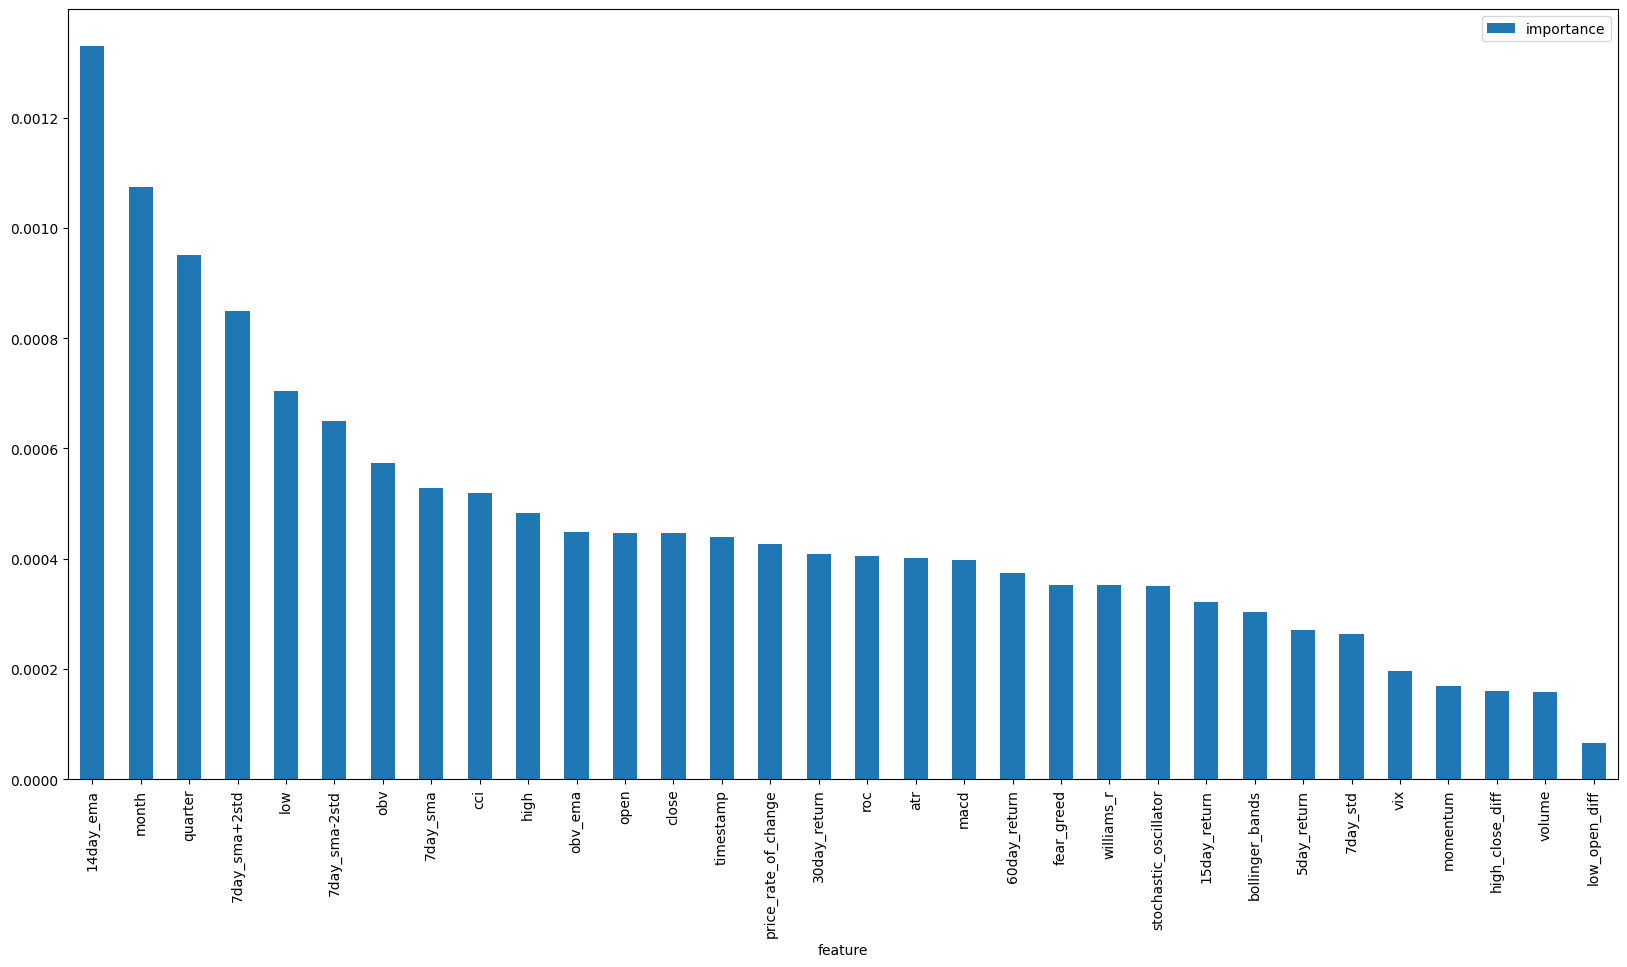

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Correlation coefficient: 0.43624711930336096


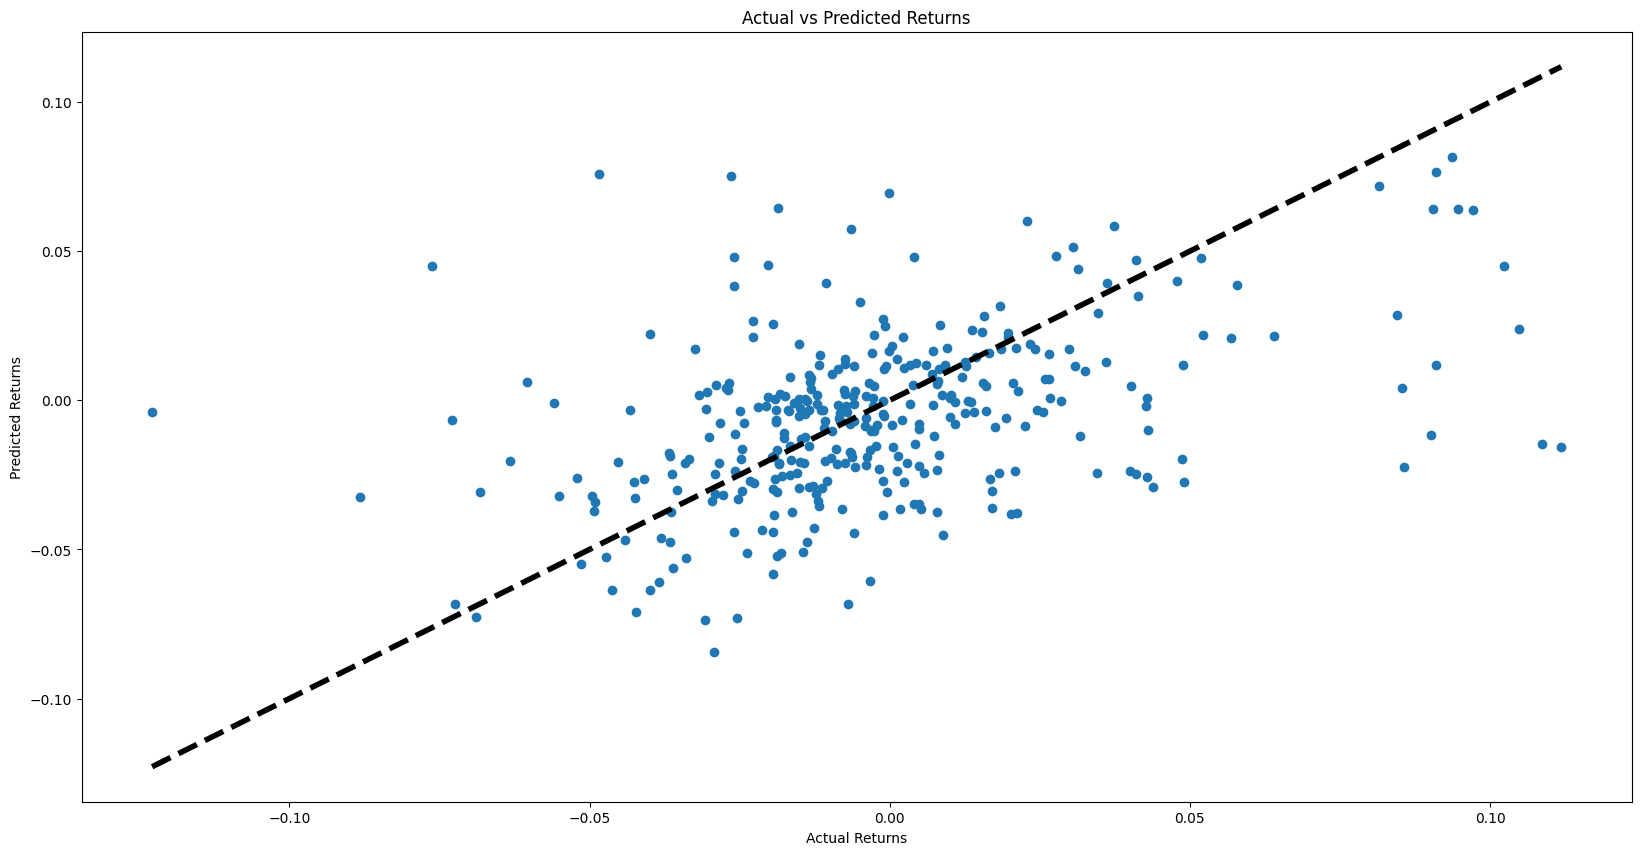

Mean Absolute Error: 0.023265073435216183
Mean Squared Error: 0.0010718933902819207
Root Mean Squared Error: 0.03273978299075791
95% Confidence Interval: +/- 0.06371547405603004
Feature 31 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.000858086918015033


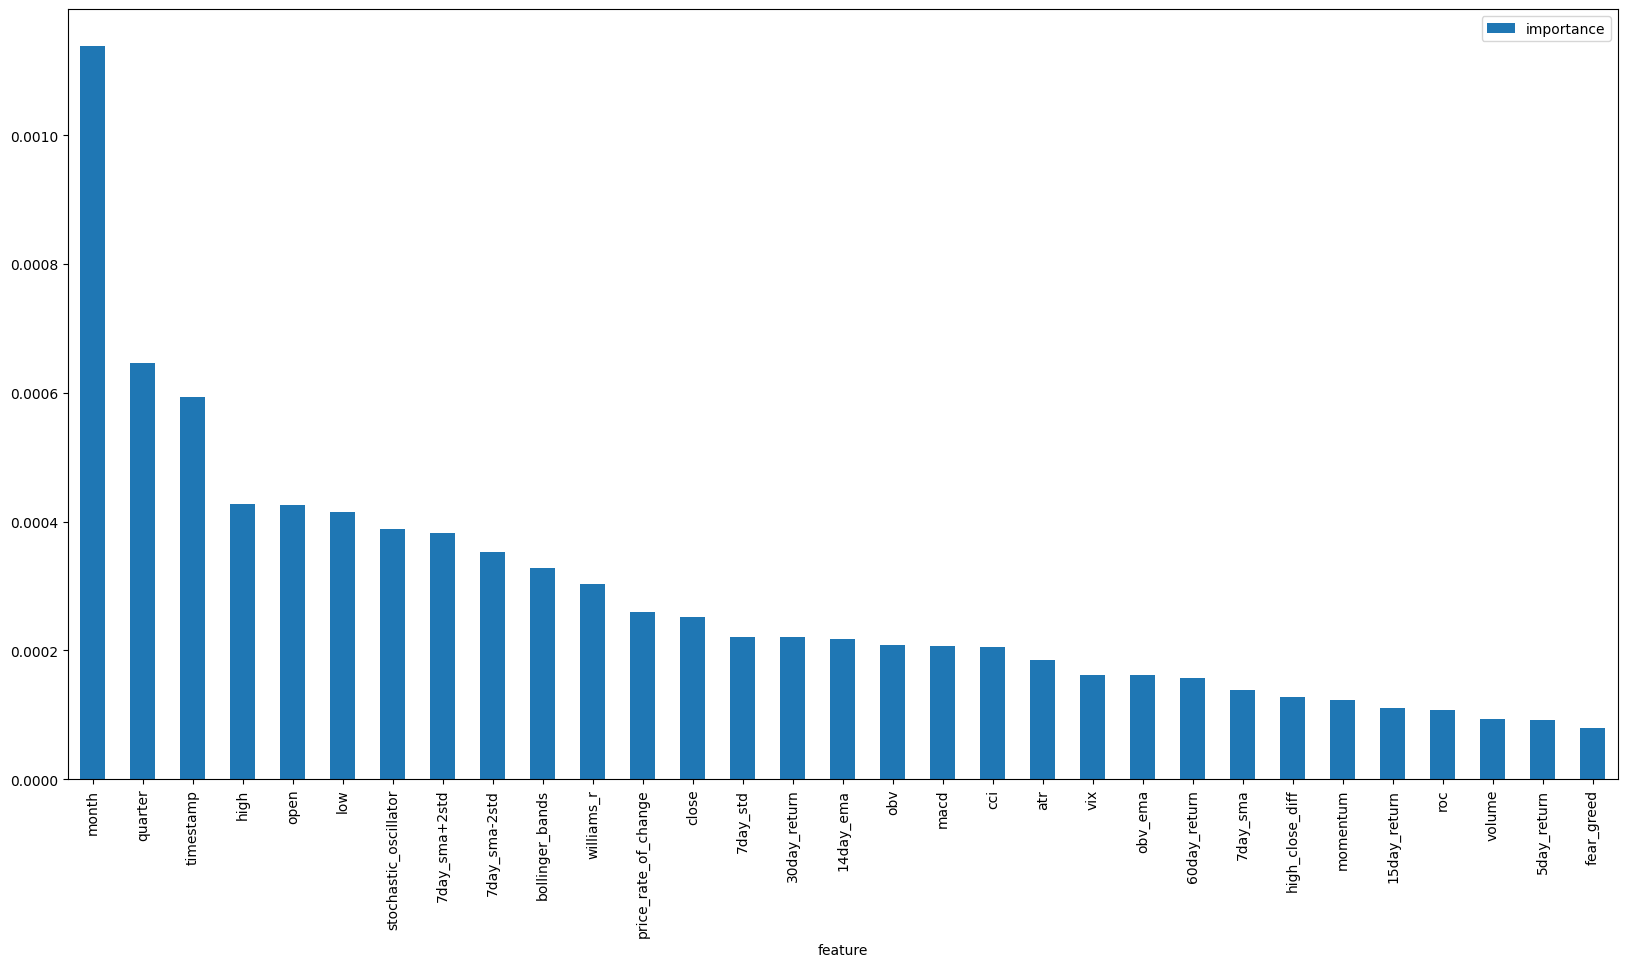

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Correlation coefficient: 0.4722811697613263


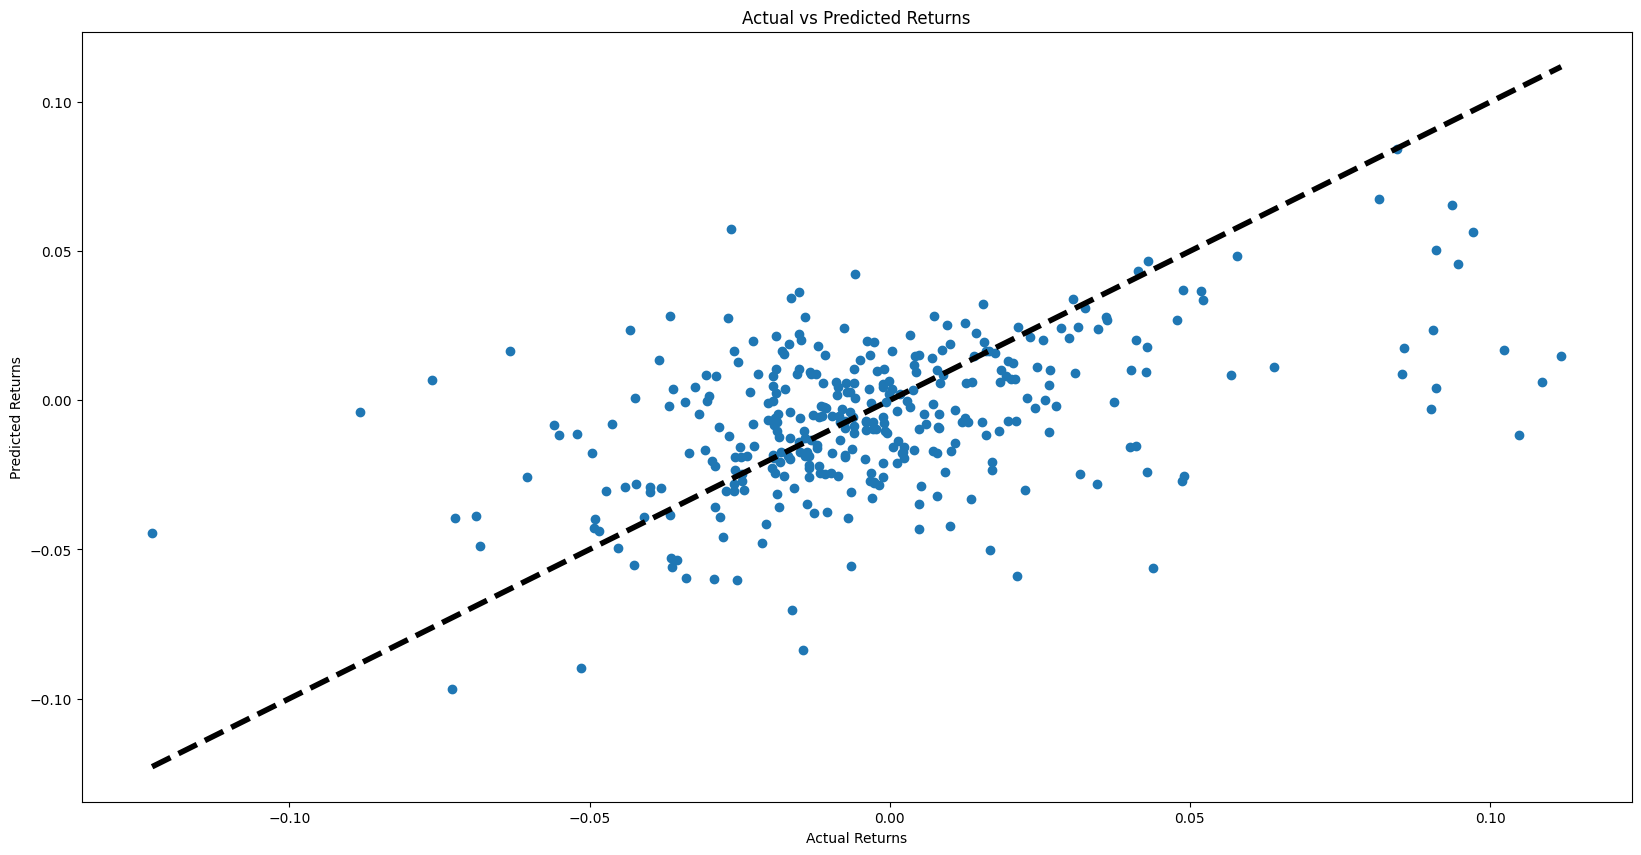

Mean Absolute Error: 0.021897951283008116
Mean Squared Error: 0.0009262430174351479
Root Mean Squared Error: 0.030434240871675244
95% Confidence Interval: +/- 0.059161425379498714
Feature 30 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0010651529300957918


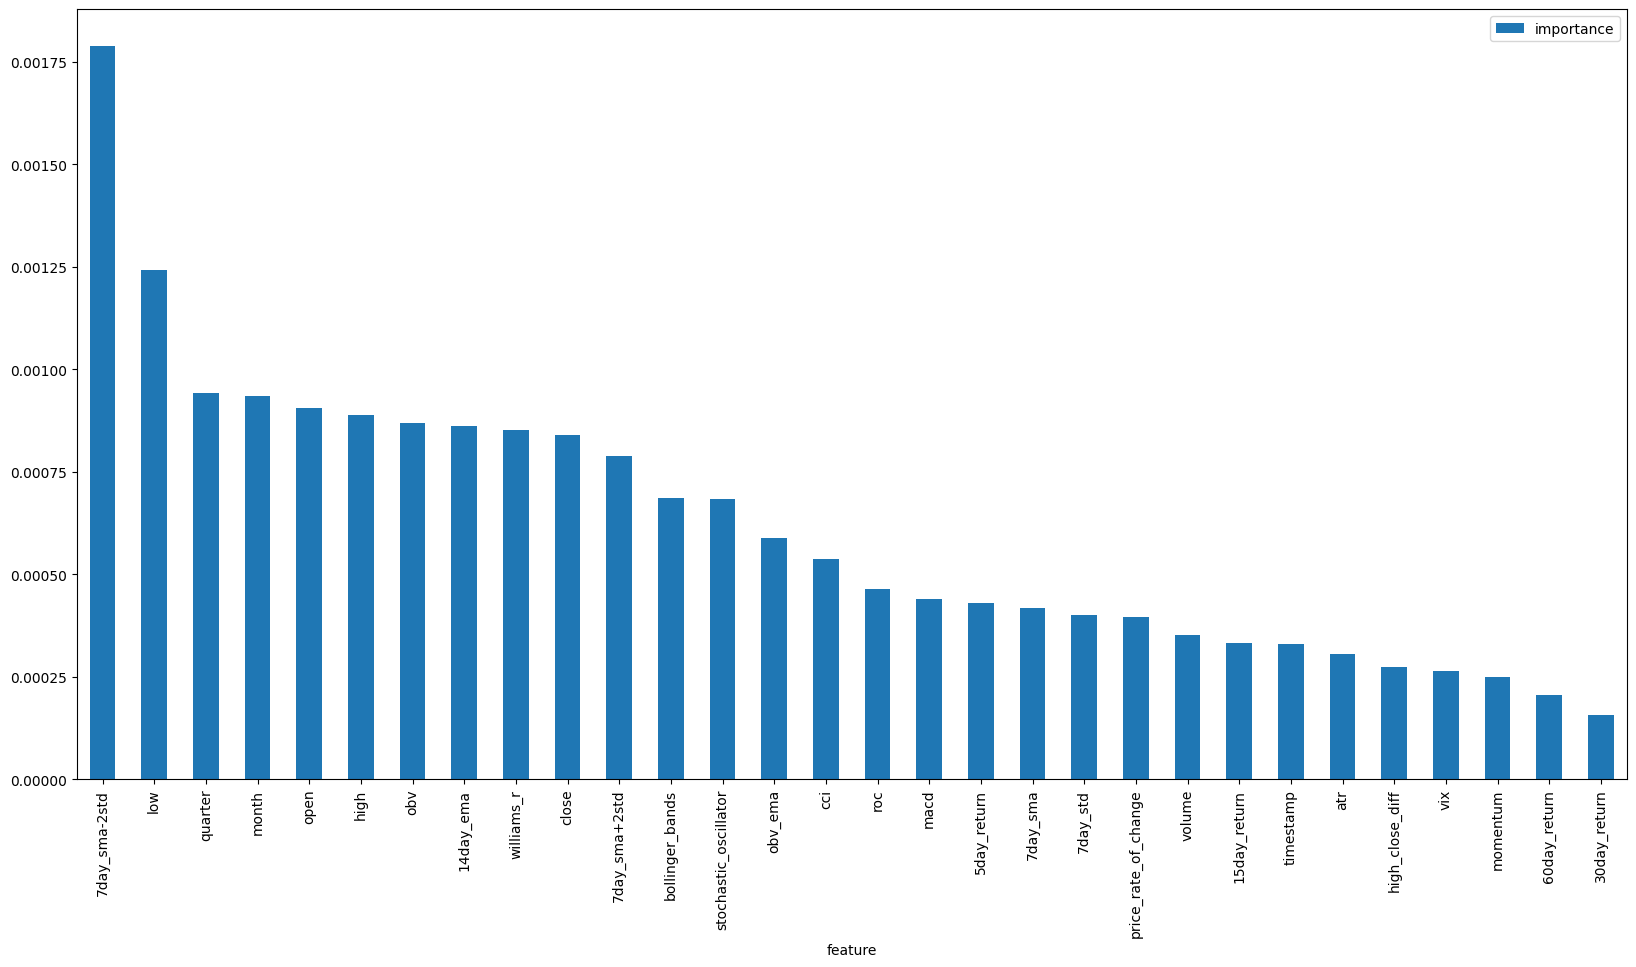

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Correlation coefficient: 0.4537107244701701


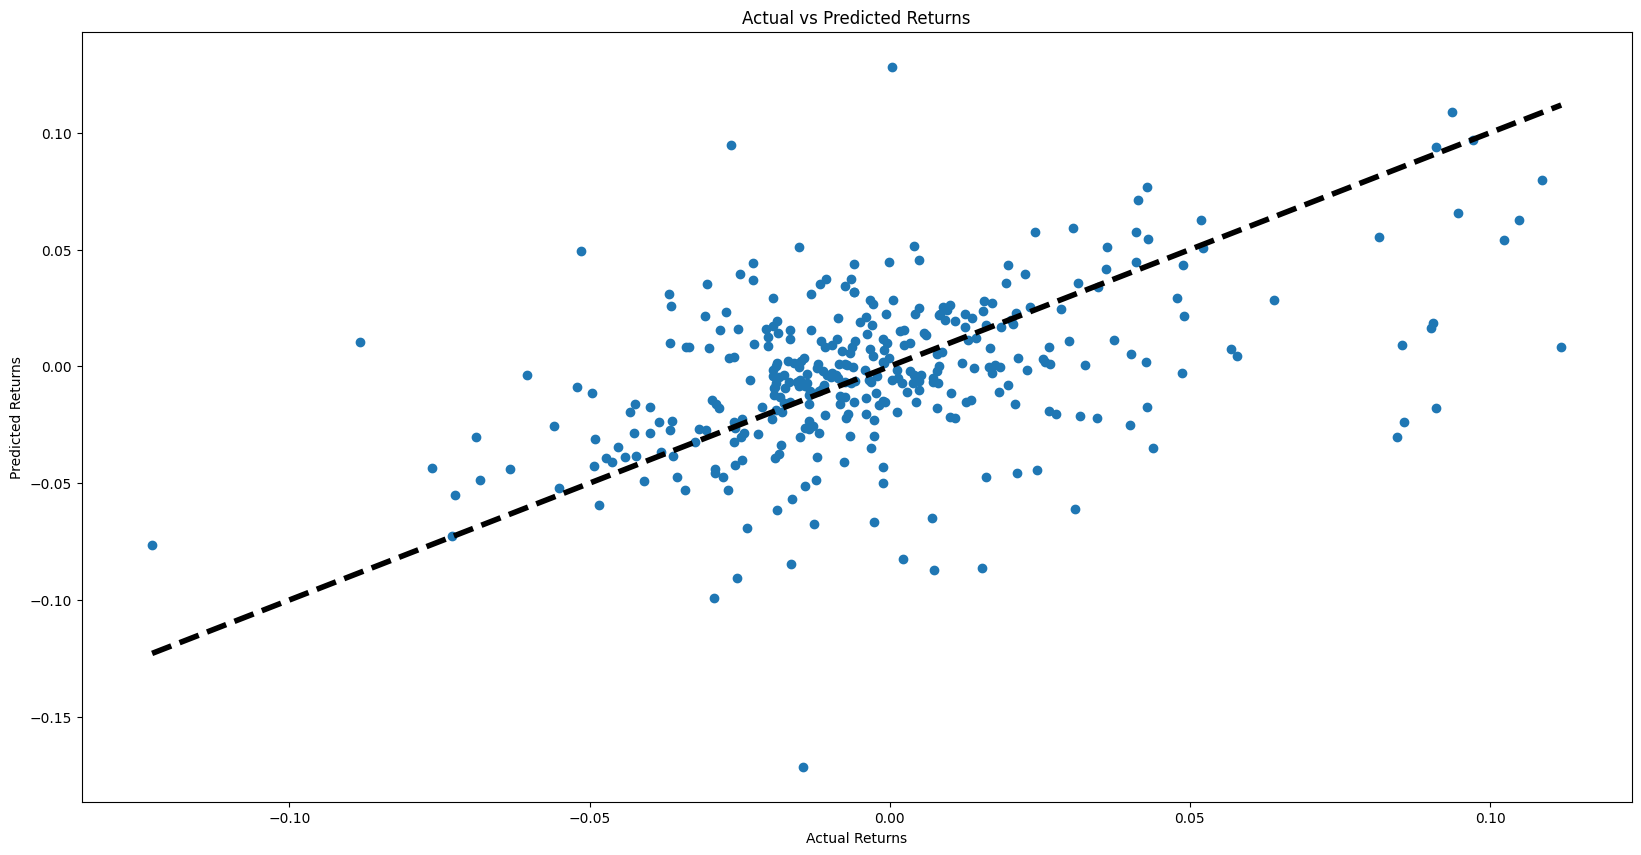

Mean Absolute Error: 0.02460590392884661
Mean Squared Error: 0.0012112553692576506
Root Mean Squared Error: 0.03480309424832296
95% Confidence Interval: +/- 0.06819807722082388
Feature 29 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.00106294039869681


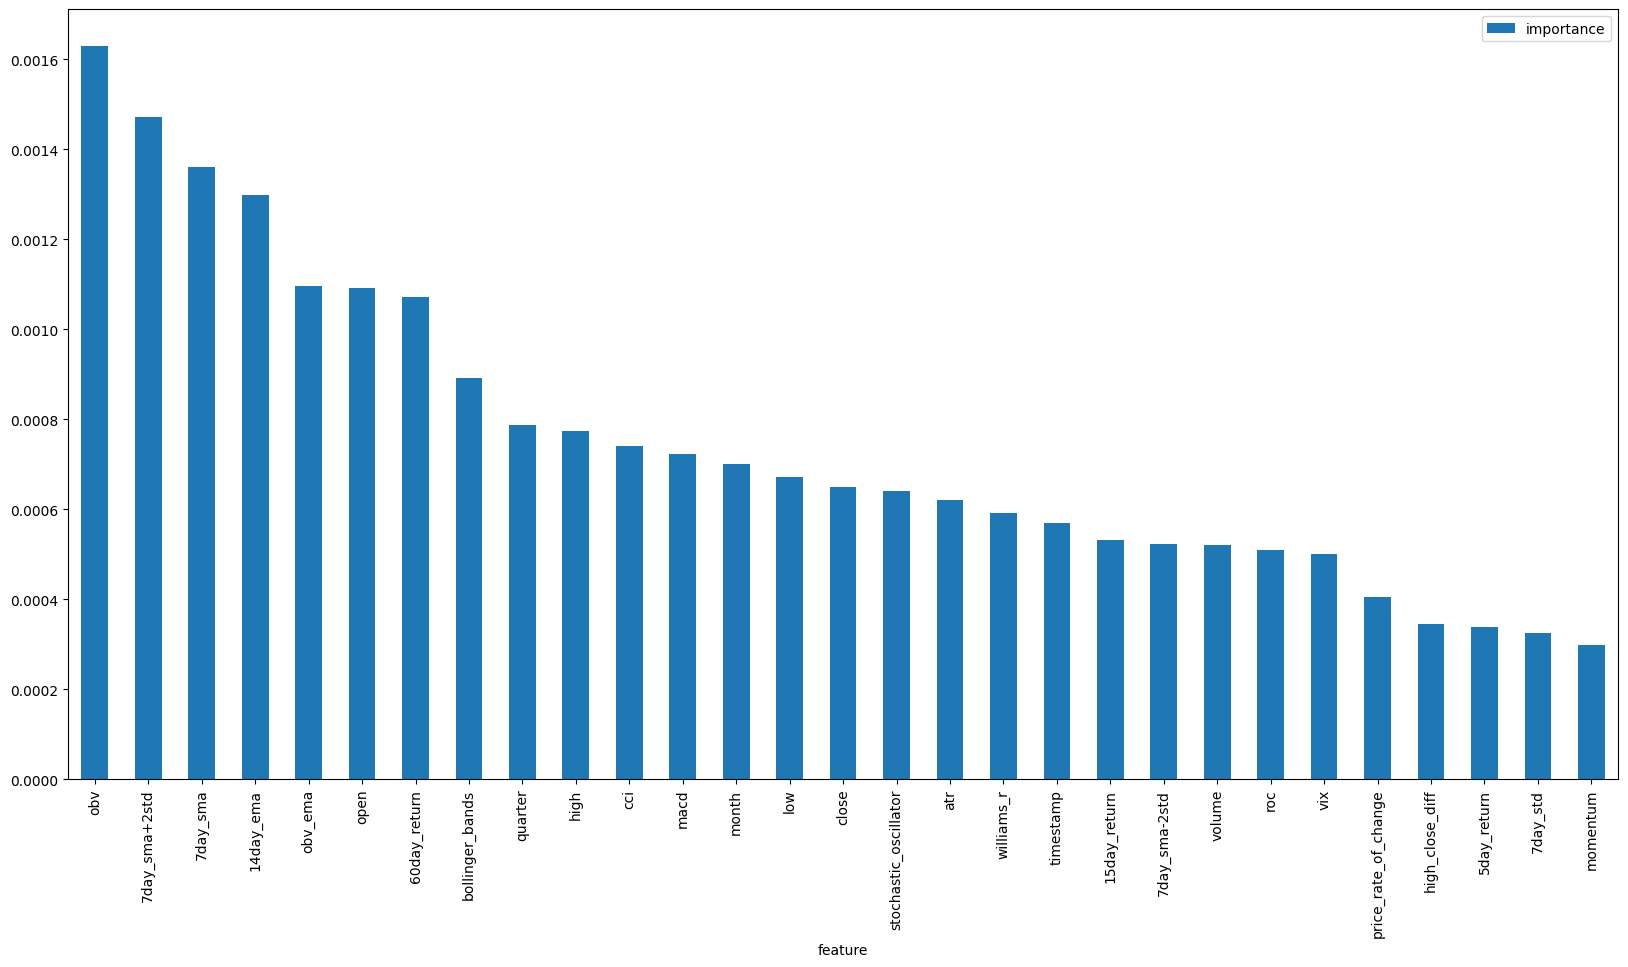

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Correlation coefficient: 0.42966890443742334


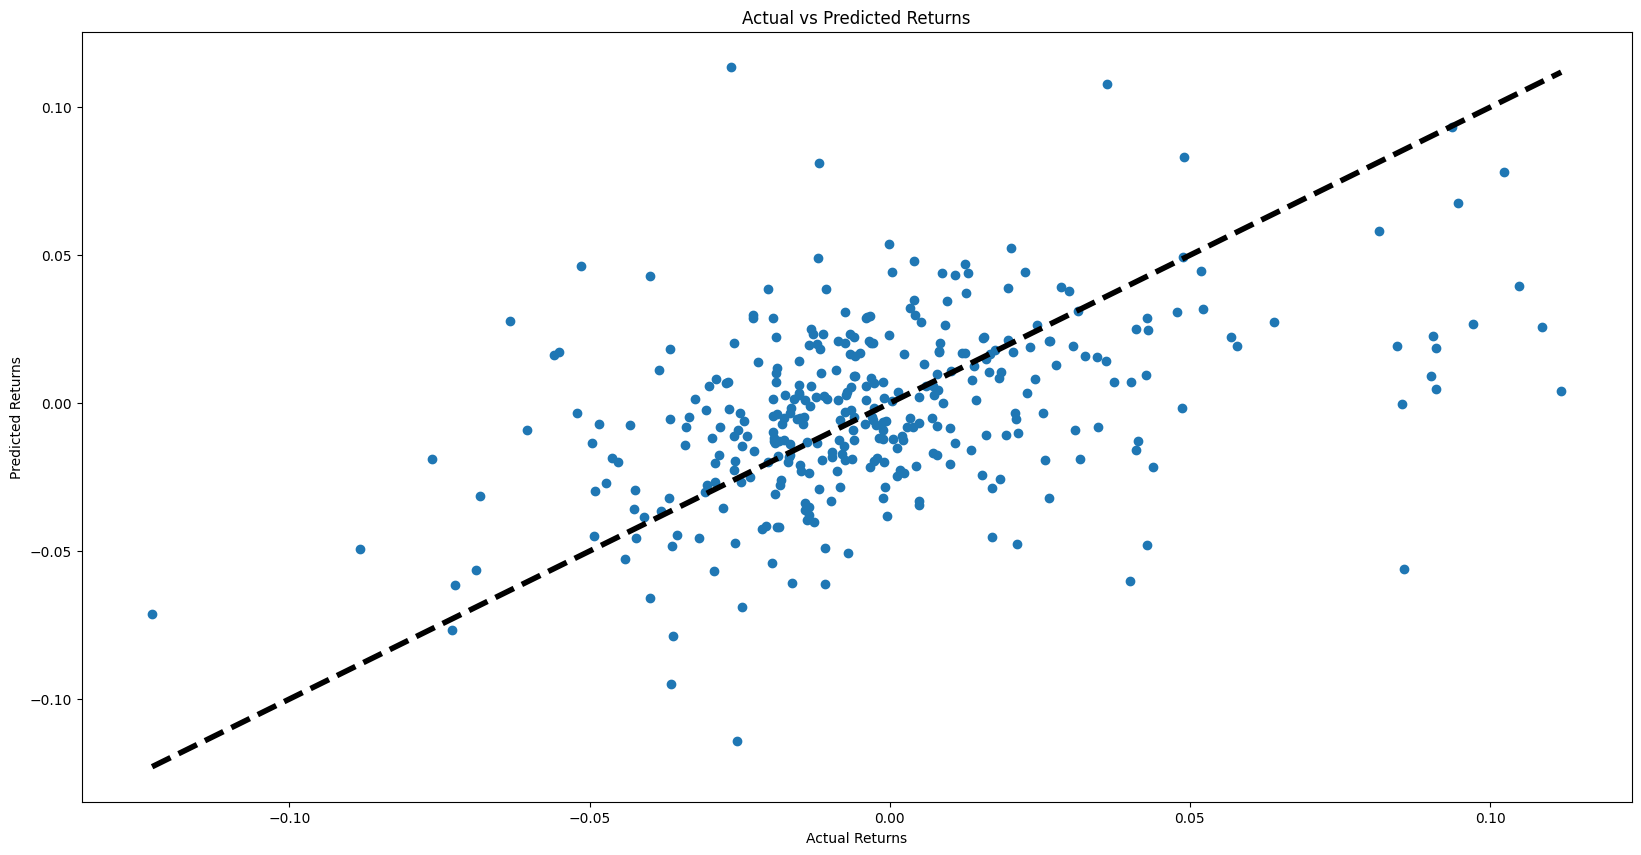

Mean Absolute Error: 0.024555297899727695
Mean Squared Error: 0.0011159024905769304
Root Mean Squared Error: 0.03340512671098451
95% Confidence Interval: +/- 0.06547375671628901
Feature 28 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0010027338673050206


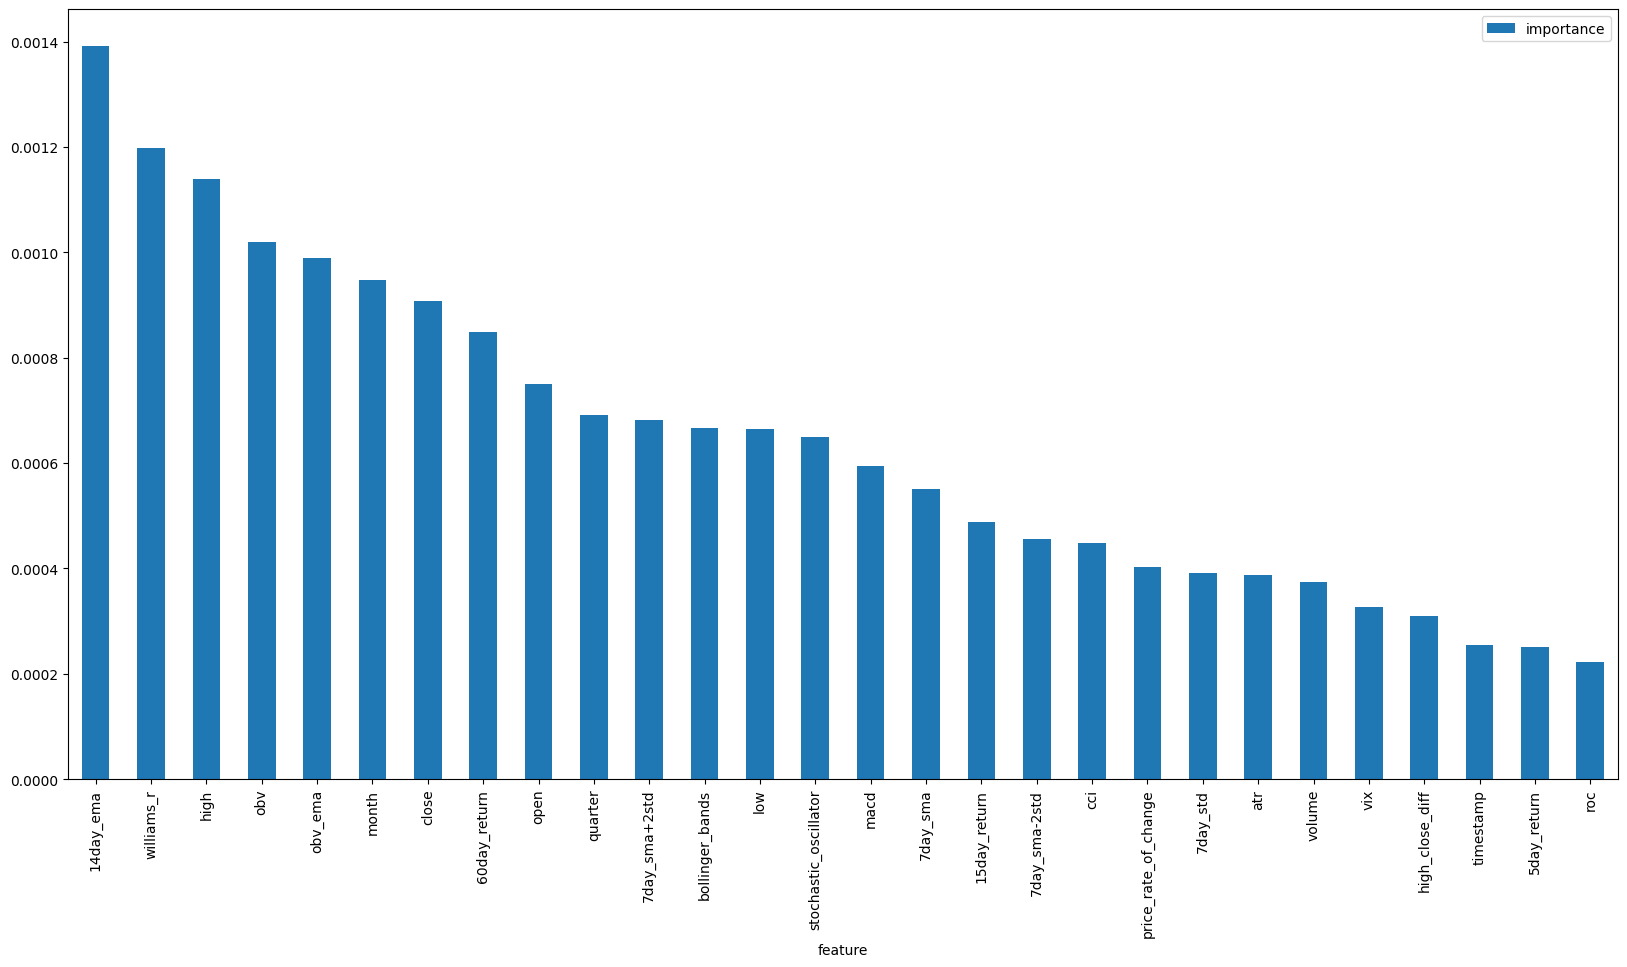

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Correlation coefficient: 0.36283751574591633


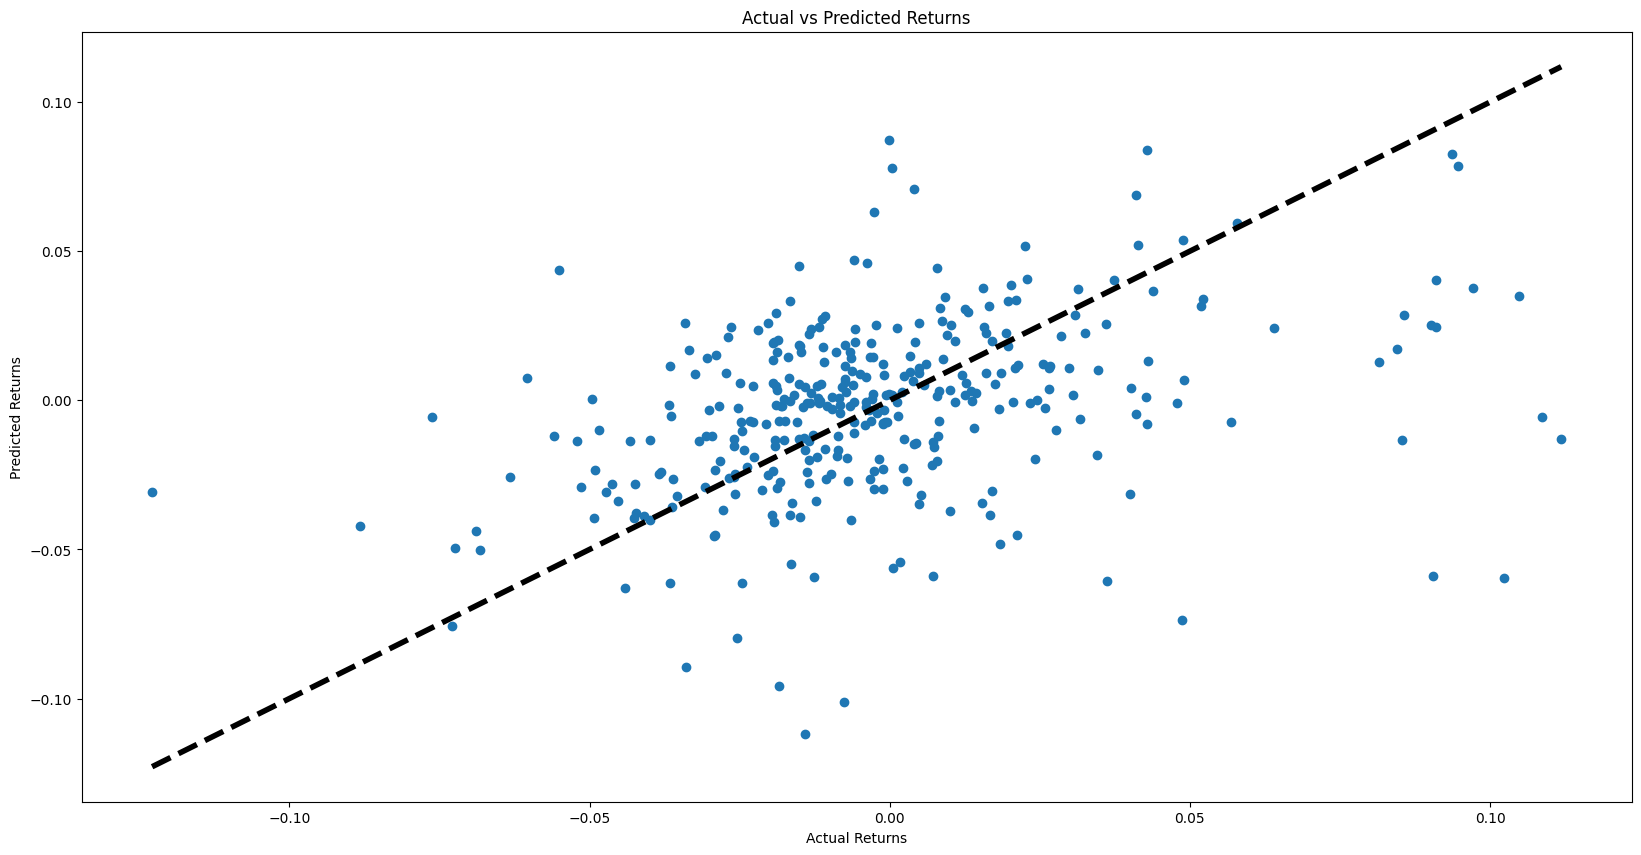

Mean Absolute Error: 0.025172145230044924
Mean Squared Error: 0.001226689479807747
Root Mean Squared Error: 0.035024127109861664
95% Confidence Interval: +/- 0.06863743268389041
Feature 27 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0008700544713065028


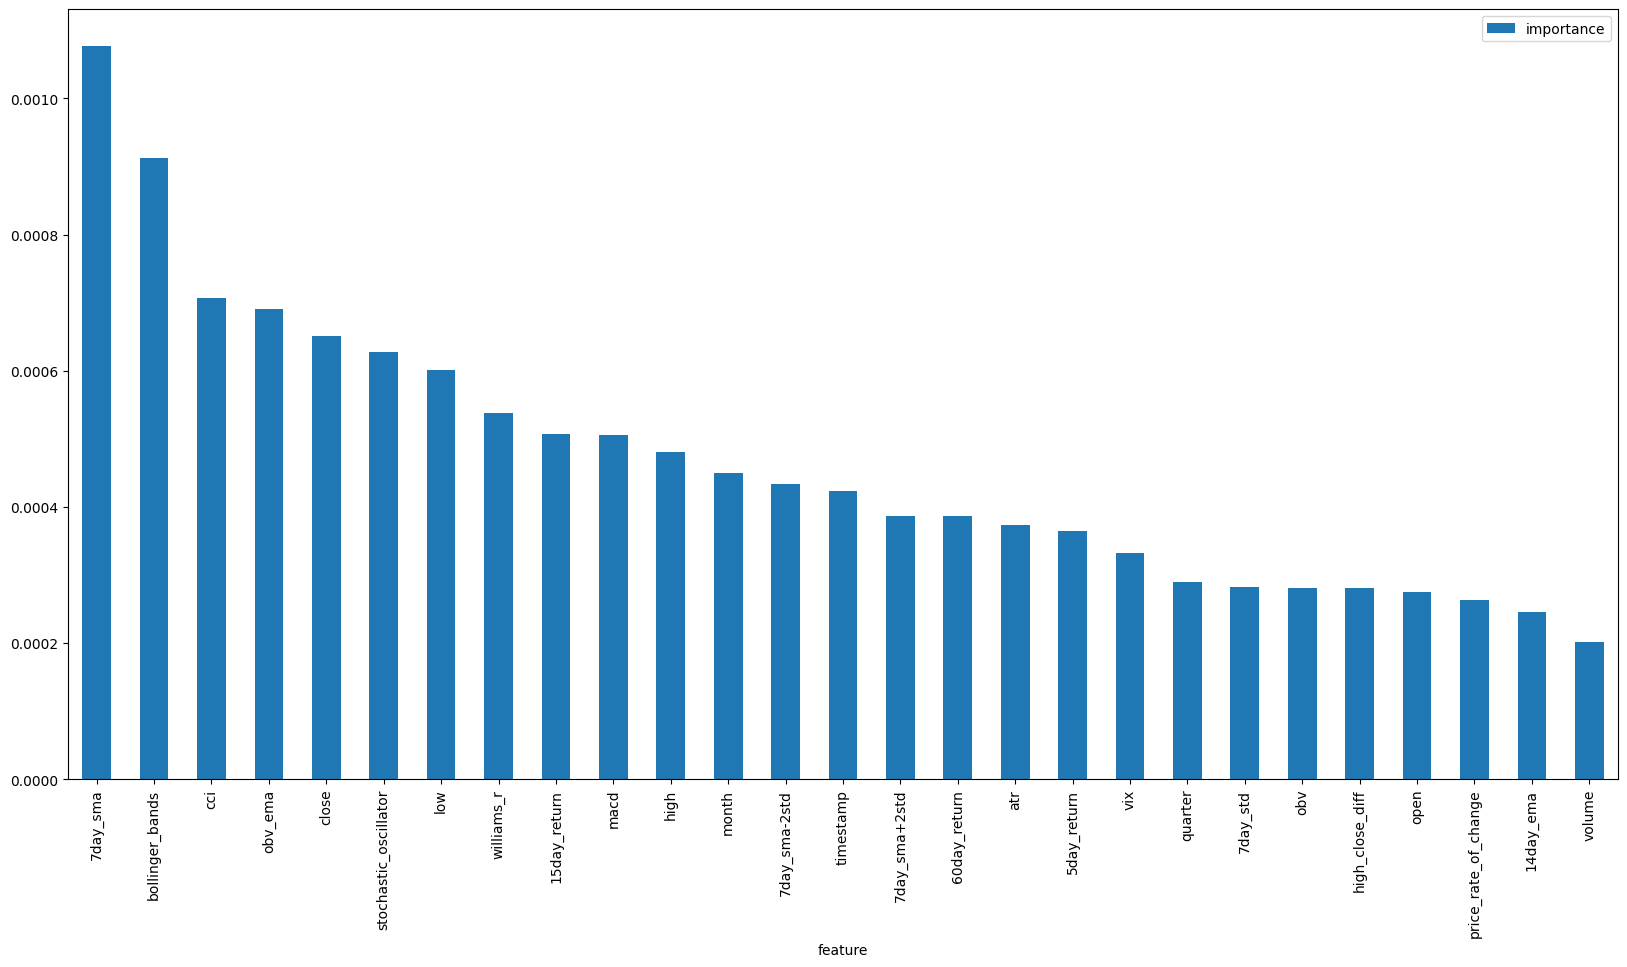

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Correlation coefficient: 0.44963474421281757


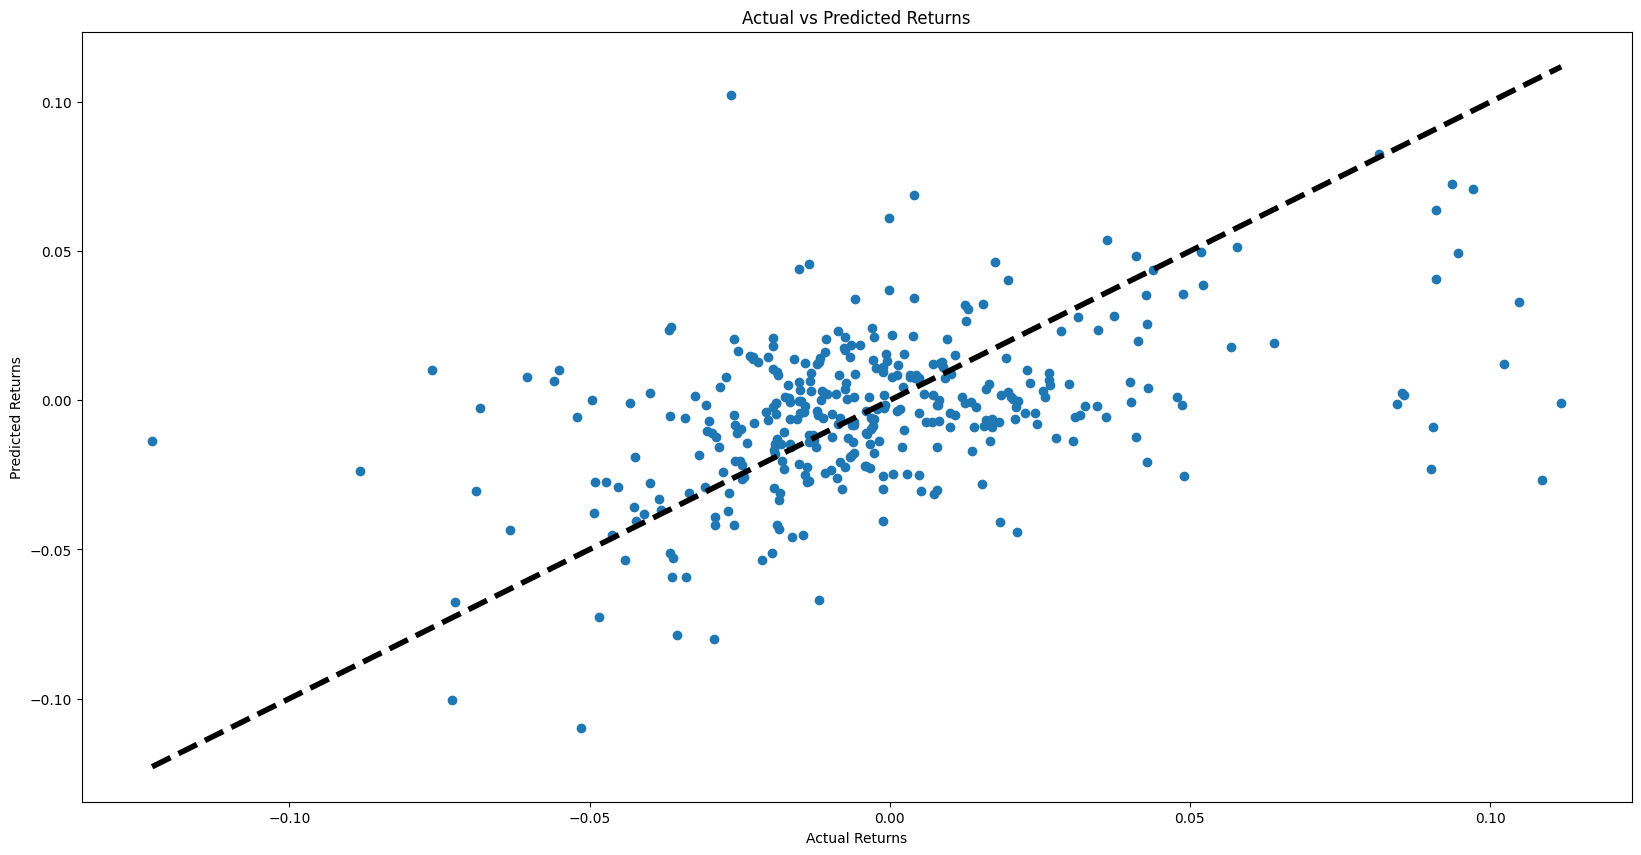

Mean Absolute Error: 0.022639688916072345
Mean Squared Error: 0.0009753535797049639
Root Mean Squared Error: 0.031230651285315263
95% Confidence Interval: +/- 0.06113189707835933
Feature 26 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0008576918238153061


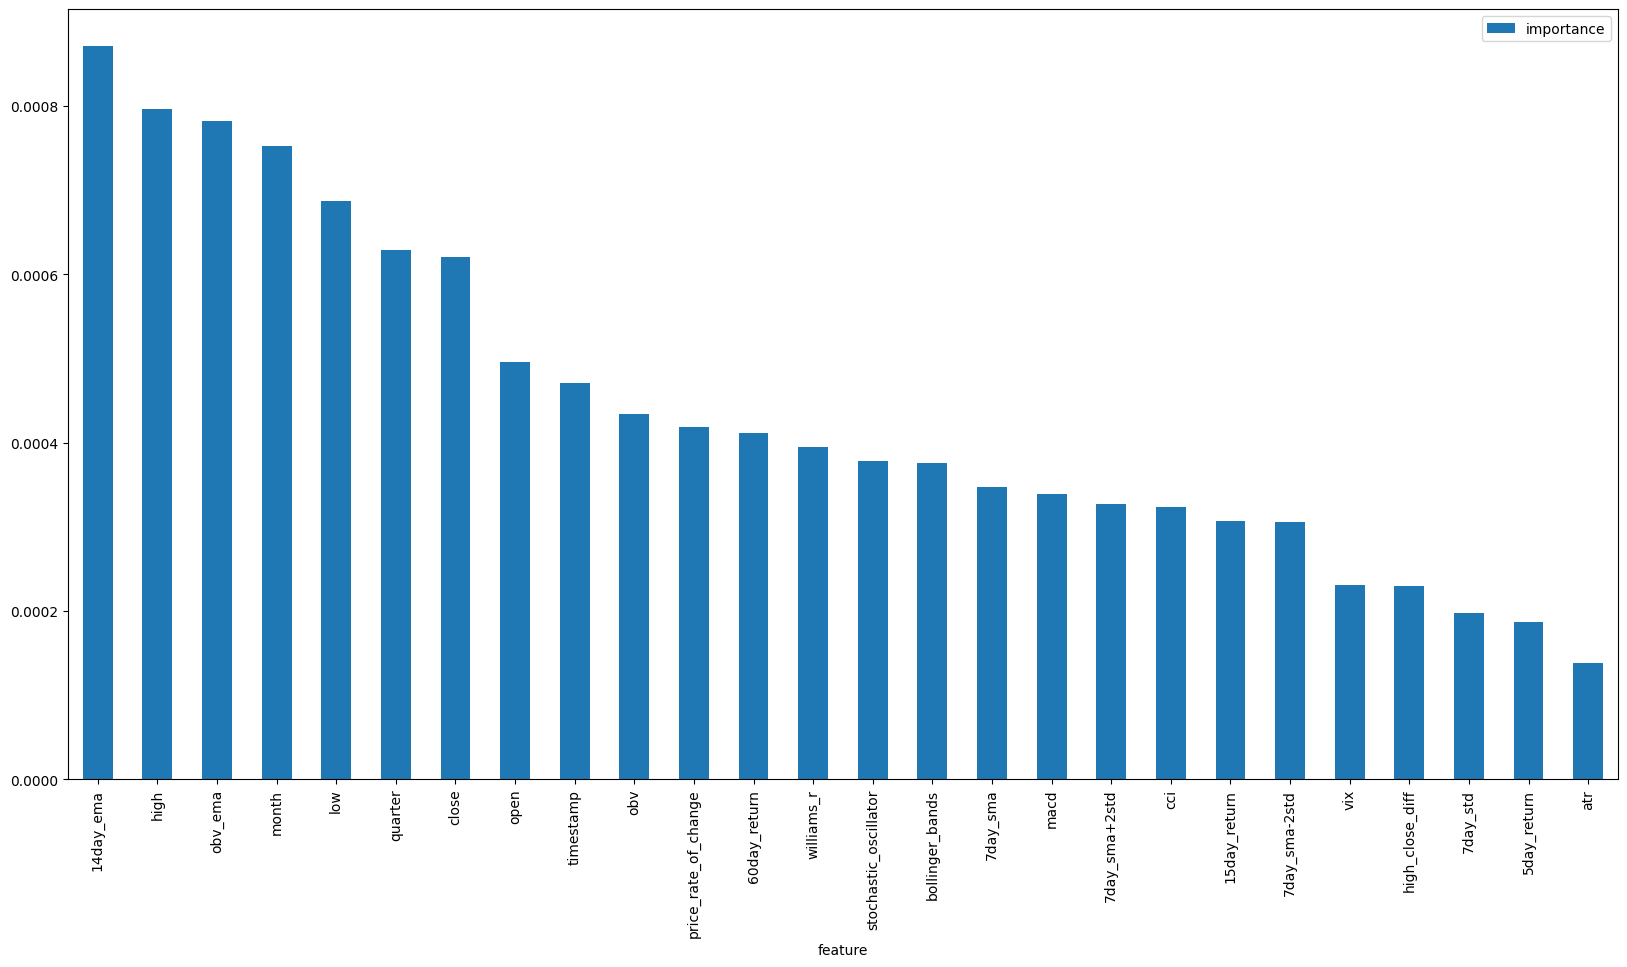

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Correlation coefficient: 0.40103547250689786


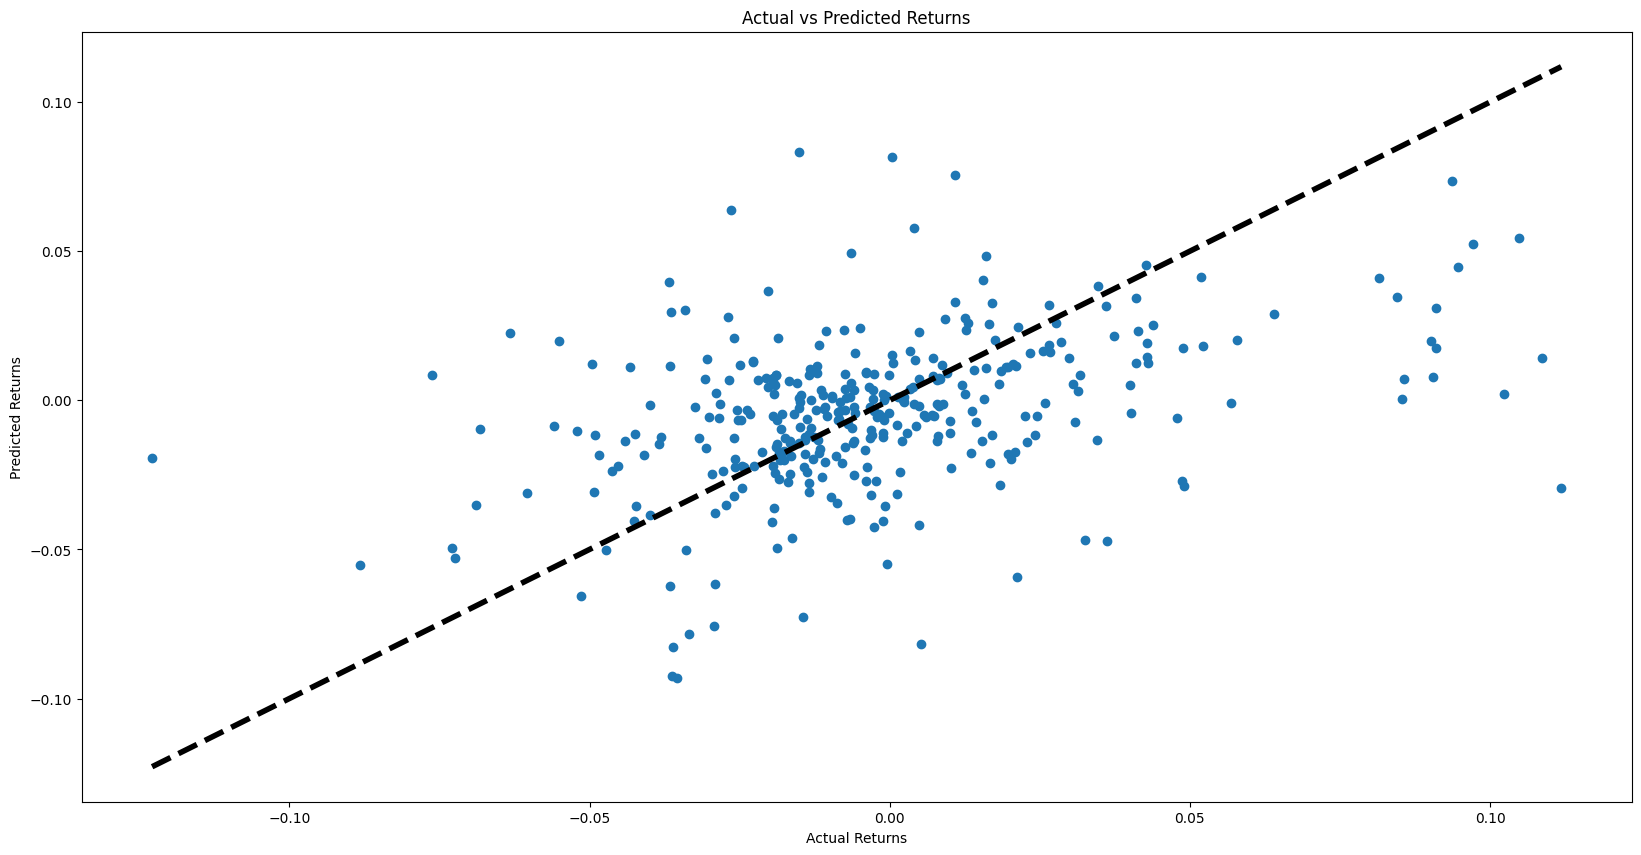

Mean Absolute Error: 0.023278638793635988
Mean Squared Error: 0.001057112420904445
Root Mean Squared Error: 0.03251326530670897
95% Confidence Interval: +/- 0.063598317628779
Feature 25 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0008522020846915742


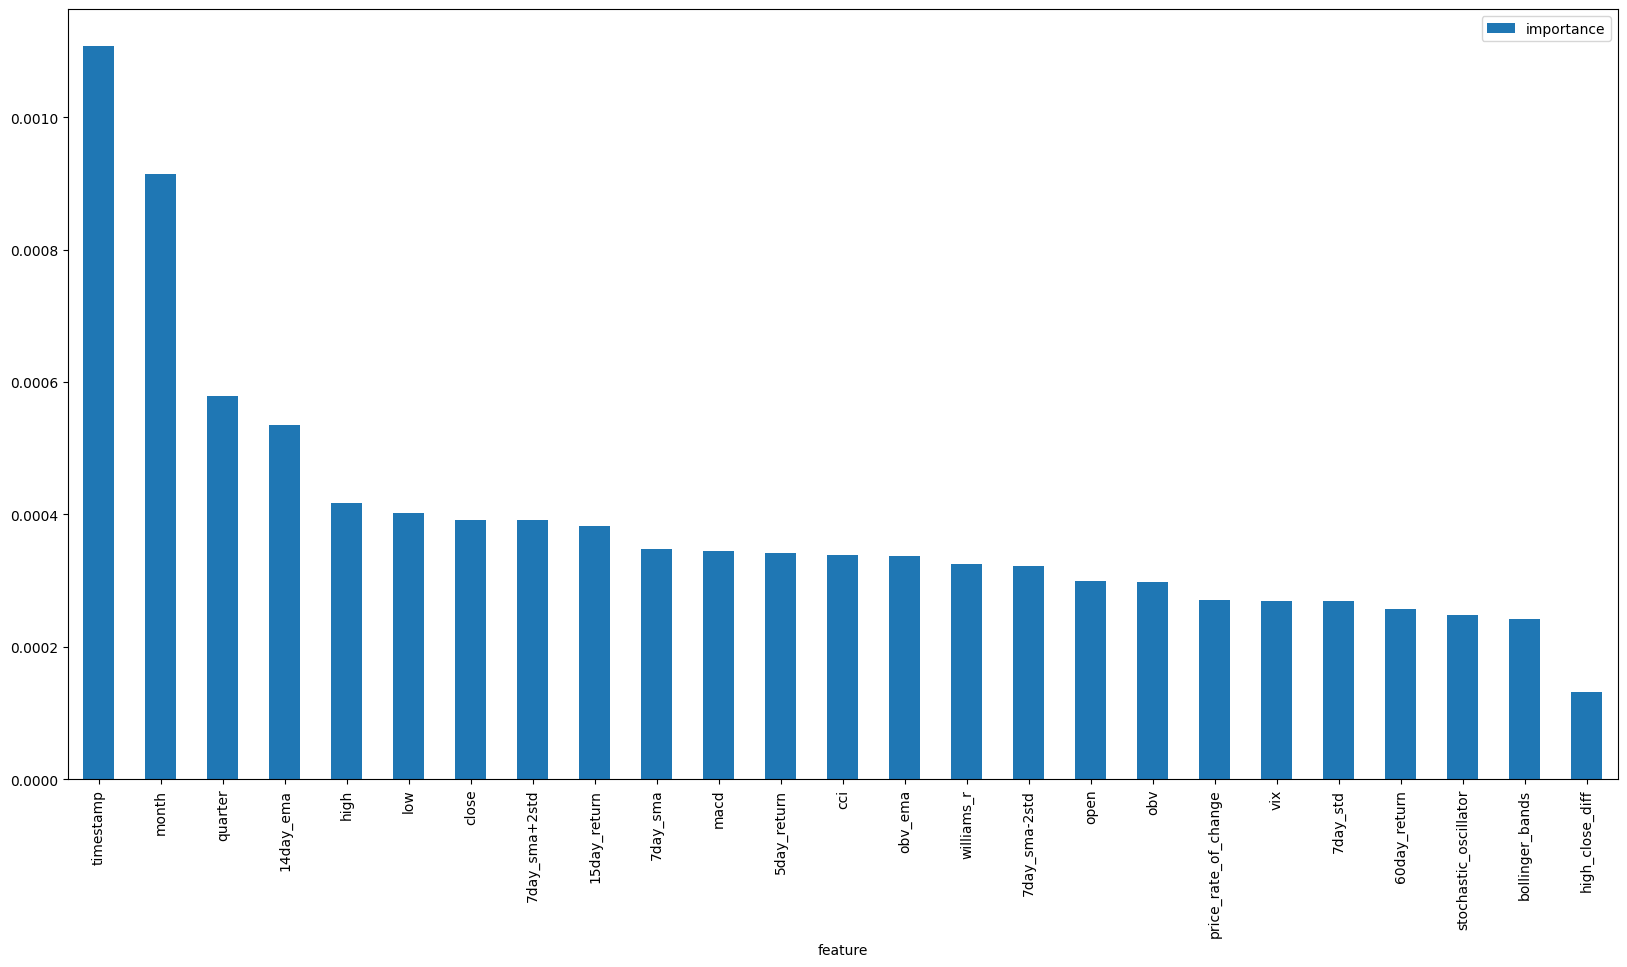

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Correlation coefficient: 0.4751304457456386


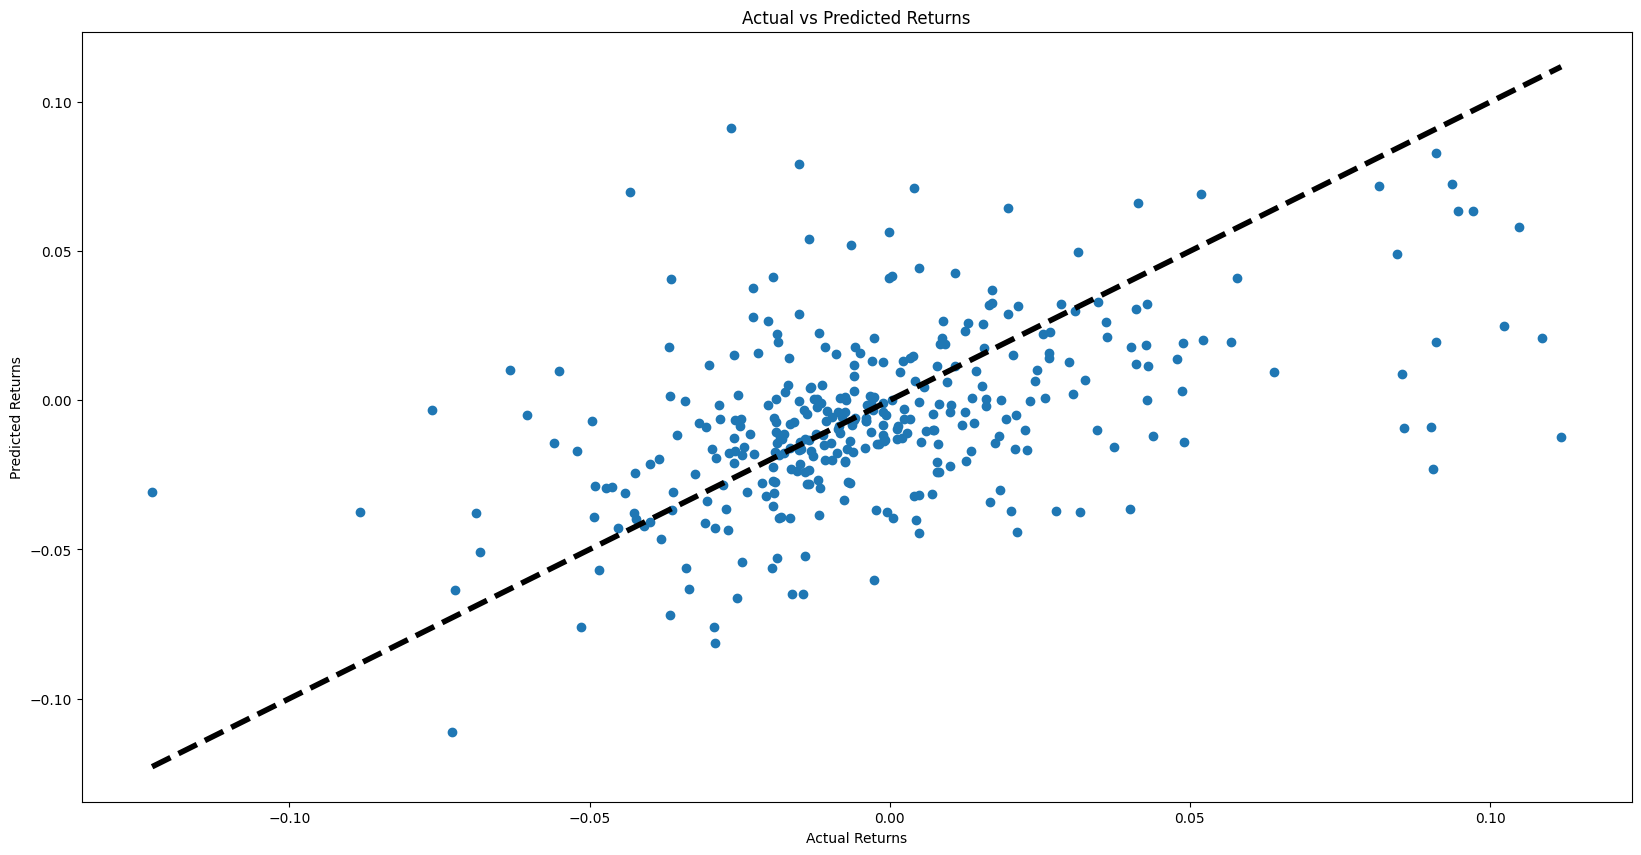

Mean Absolute Error: 0.022678424588475476
Mean Squared Error: 0.001008778141935897
Root Mean Squared Error: 0.03176126795227006
95% Confidence Interval: +/- 0.061896084975207065
Feature 24 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0008604218989300231


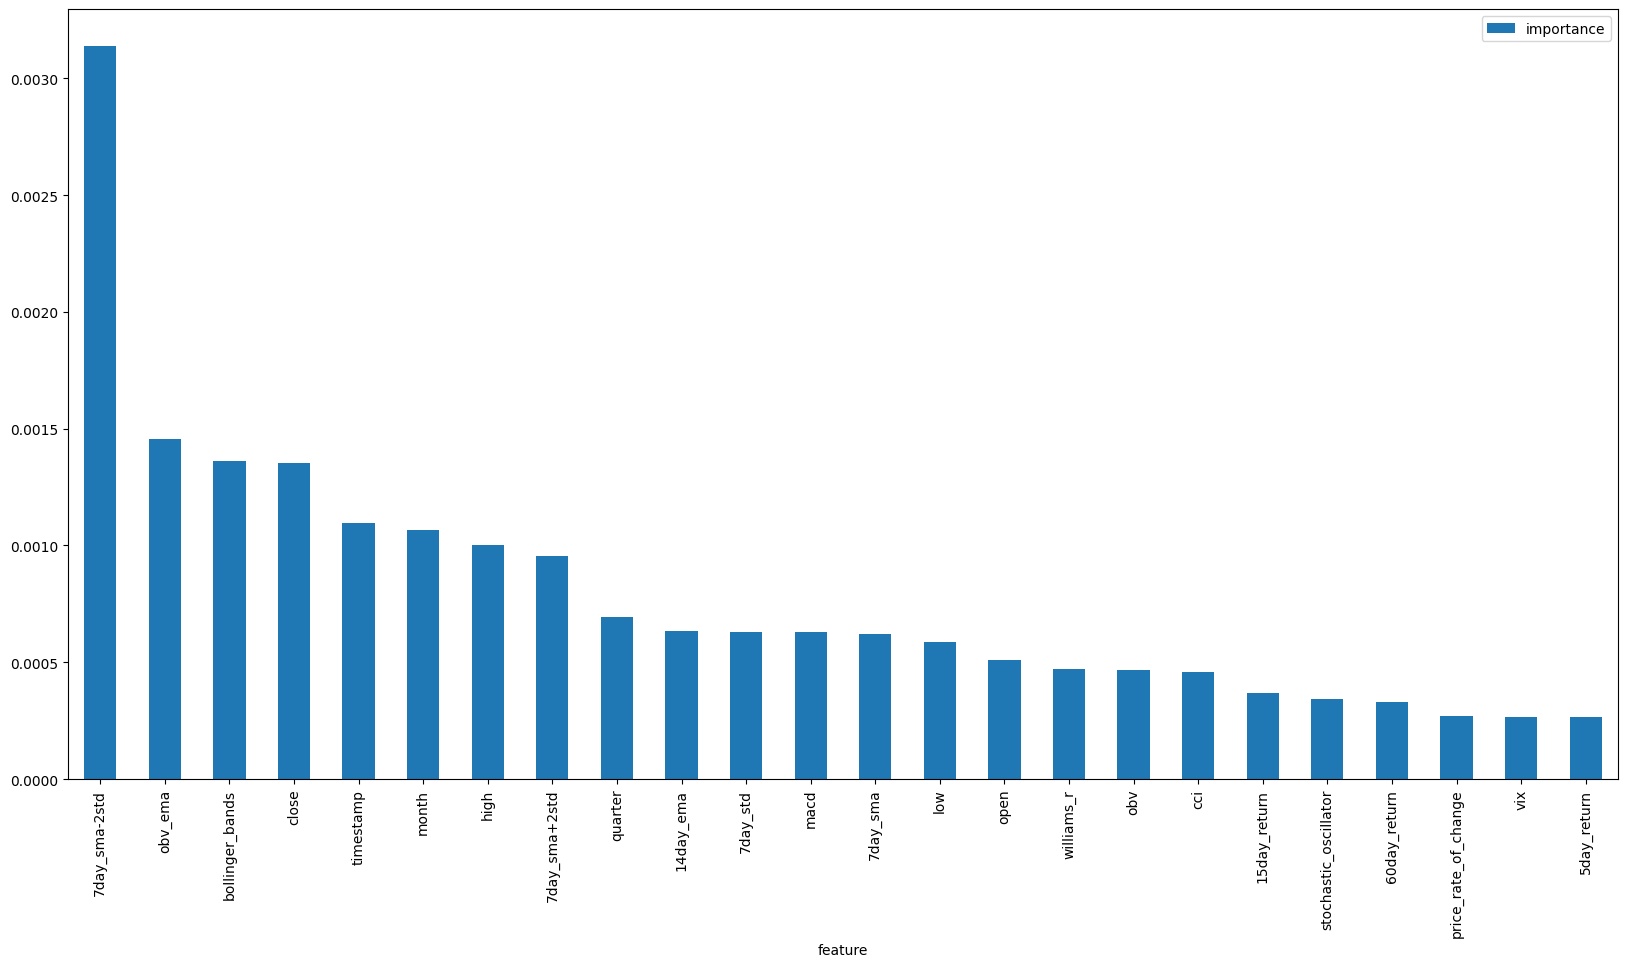

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Correlation coefficient: 0.5064601383592394


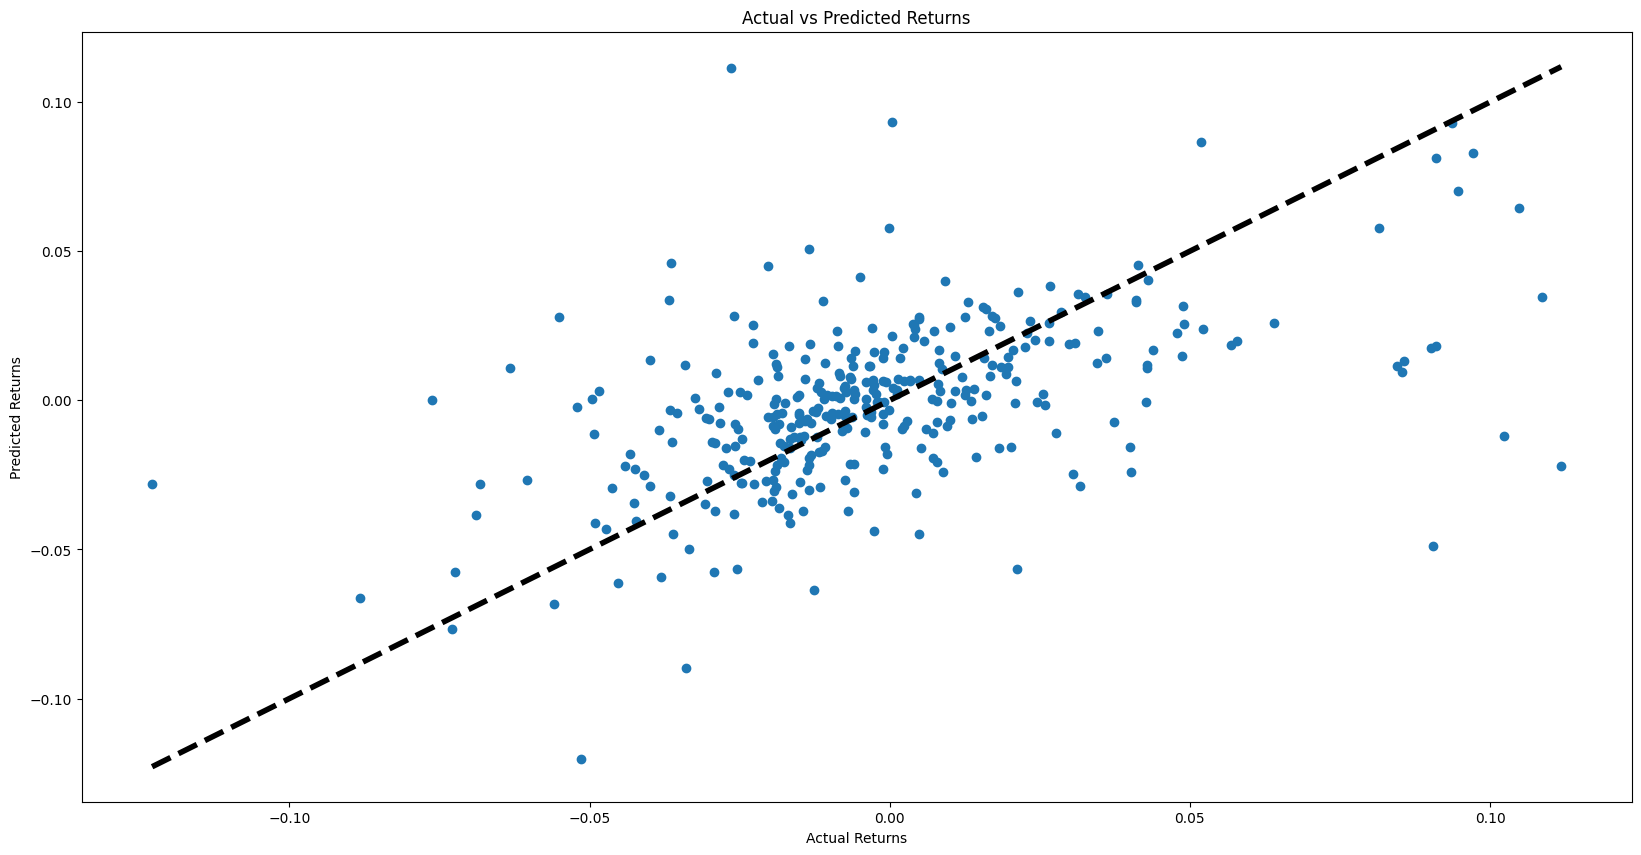

Mean Absolute Error: 0.020643017297257746
Mean Squared Error: 0.0009056786118358474
Root Mean Squared Error: 0.030094494709761242
95% Confidence Interval: +/- 0.05894291210951657
Feature 23 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0008252813519599537


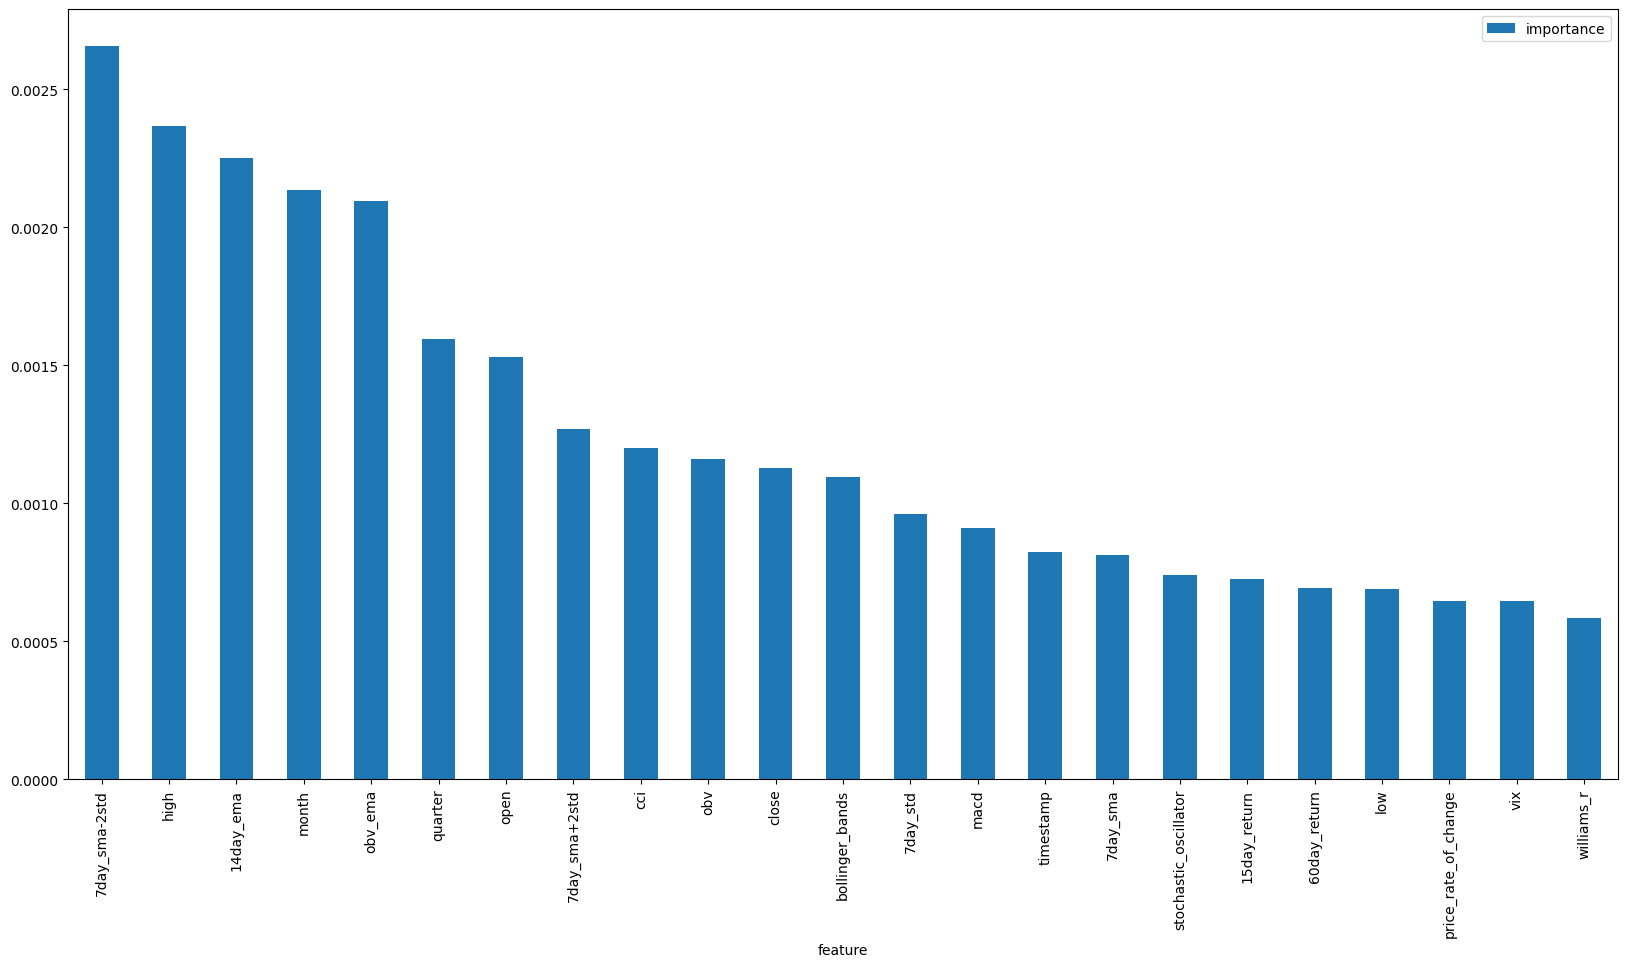

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Correlation coefficient: 0.6224831602358976


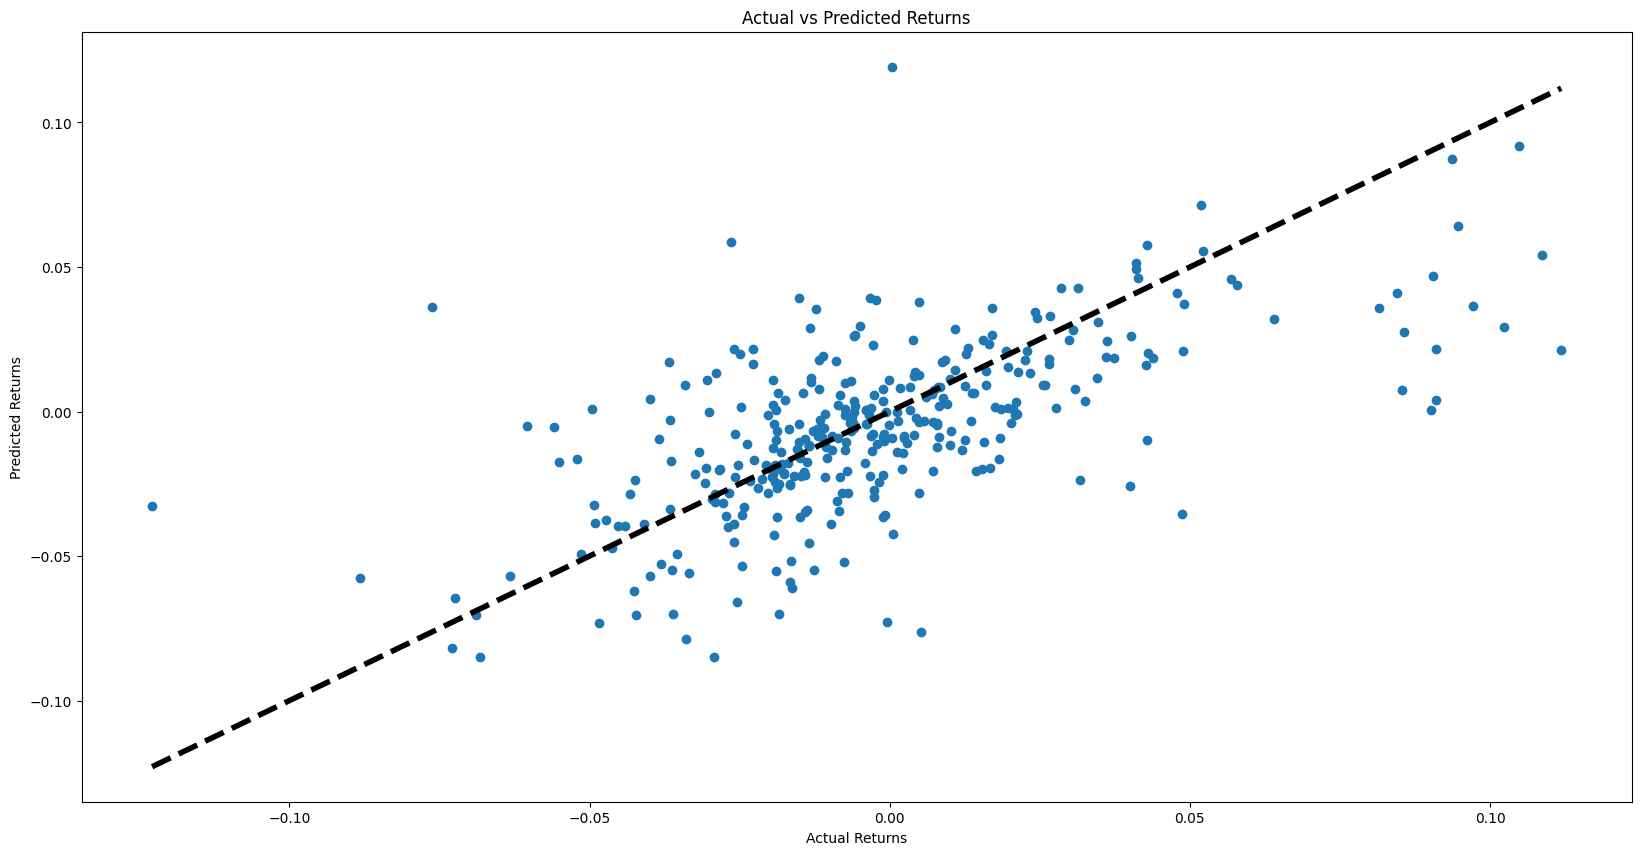

Mean Absolute Error: 0.019084696360011148
Mean Squared Error: 0.0007485983997028515
Root Mean Squared Error: 0.027360526305297044
95% Confidence Interval: +/- 0.053154437249728965
Feature 22 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0007720993016846478


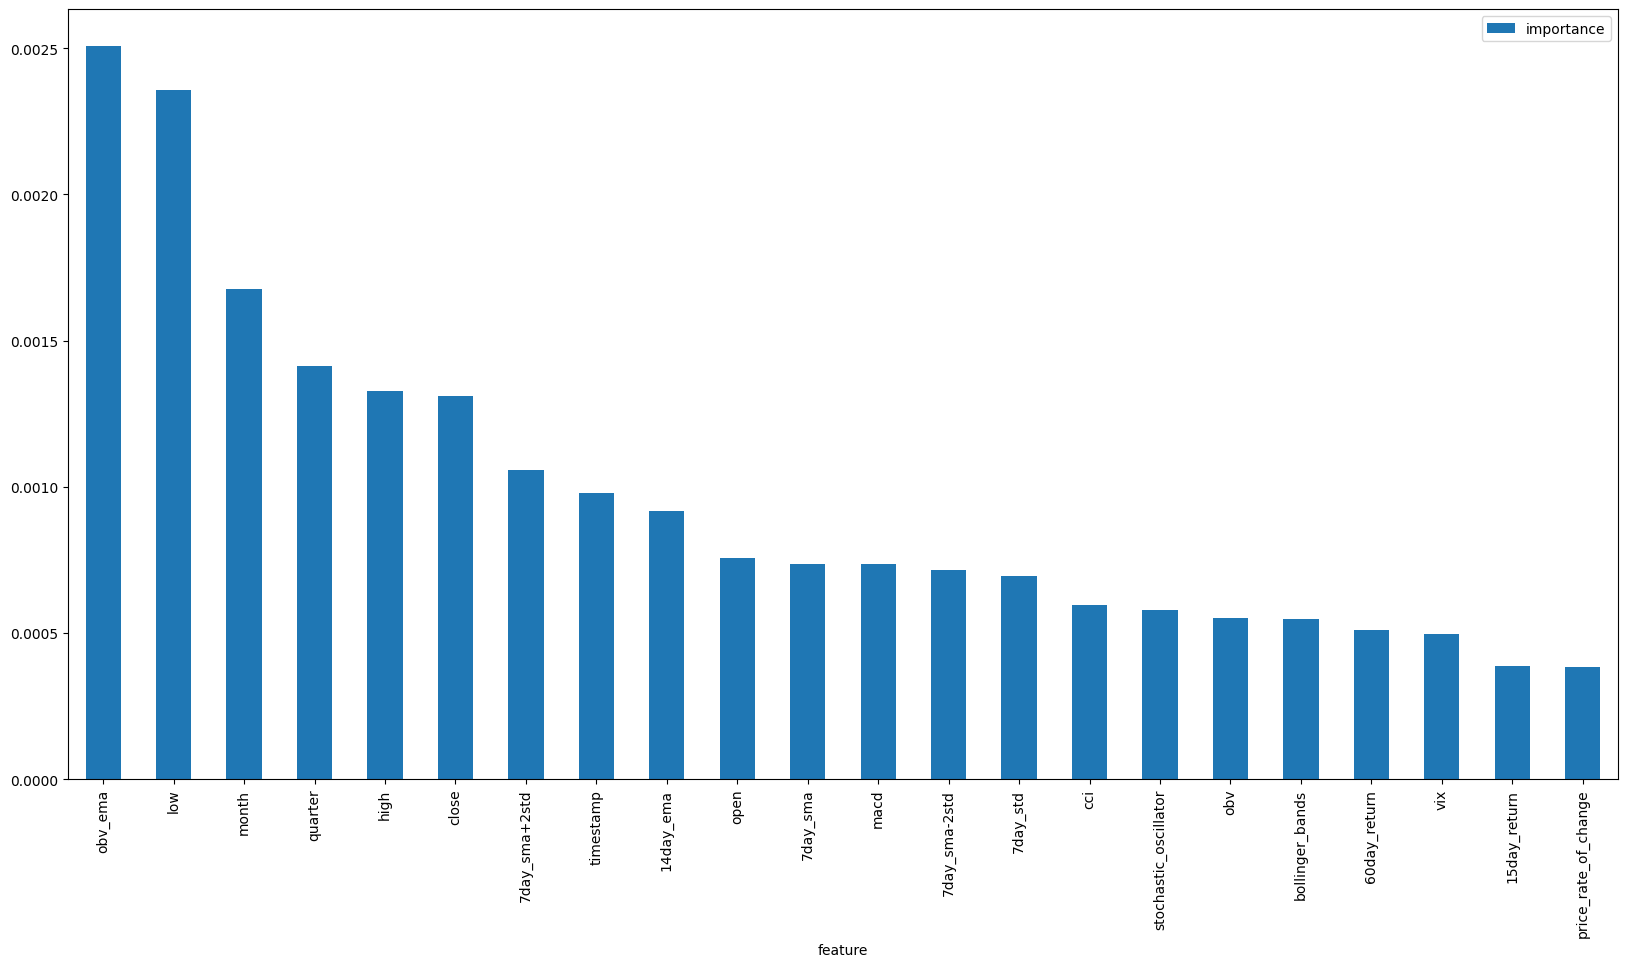

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Correlation coefficient: 0.5721933283108681


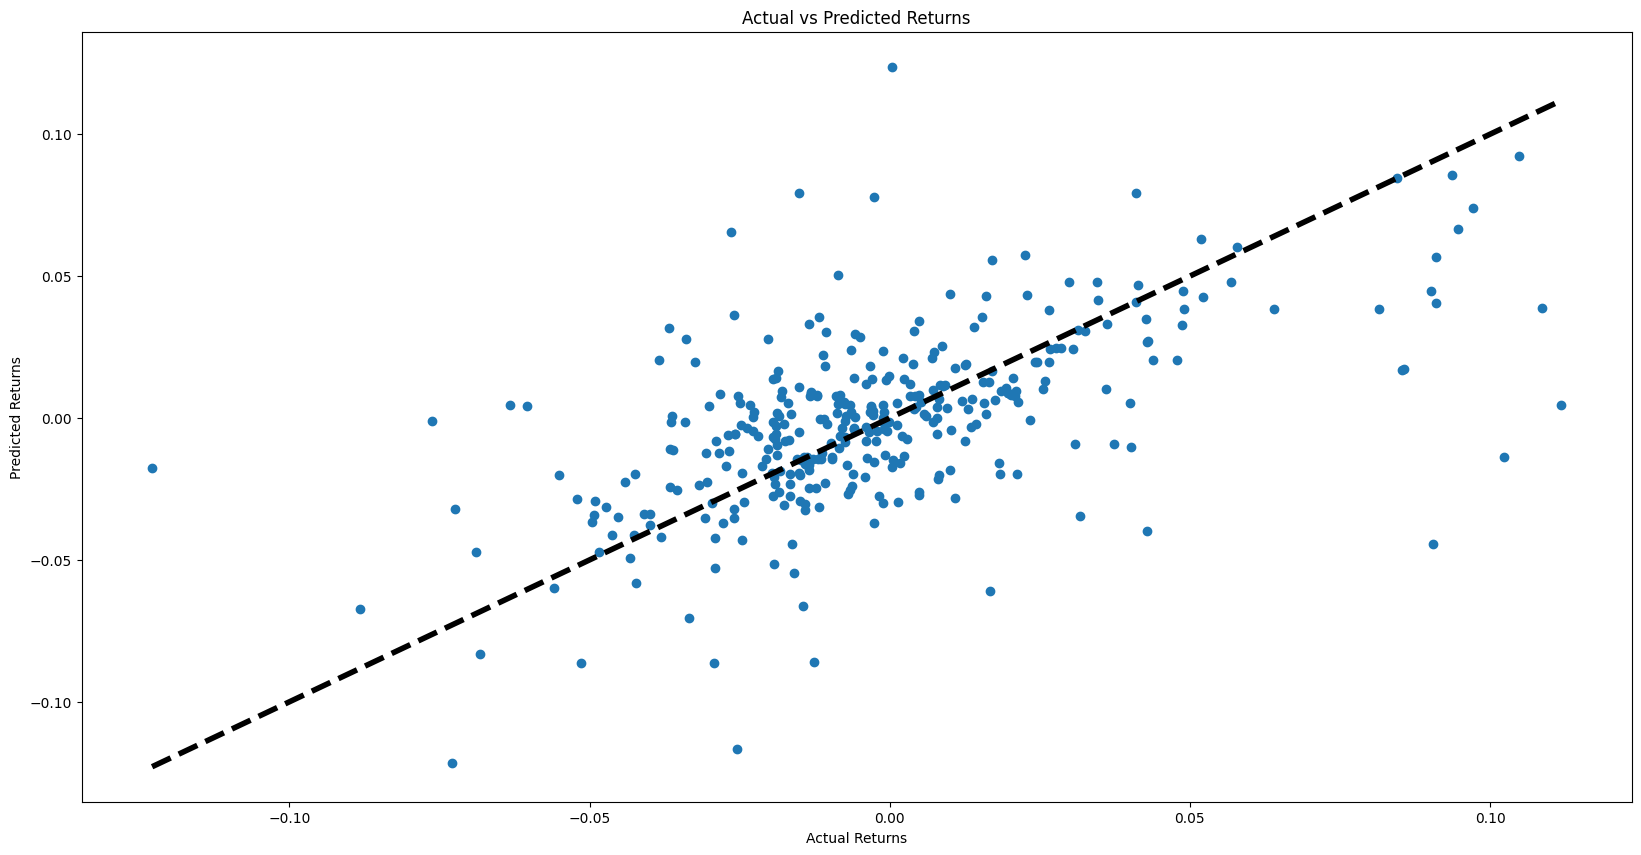

Mean Absolute Error: 0.019952032438496522
Mean Squared Error: 0.000858447137430136
Root Mean Squared Error: 0.029299268547698182
95% Confidence Interval: +/- 0.05737918983927914
Feature 21 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0007726736560774347


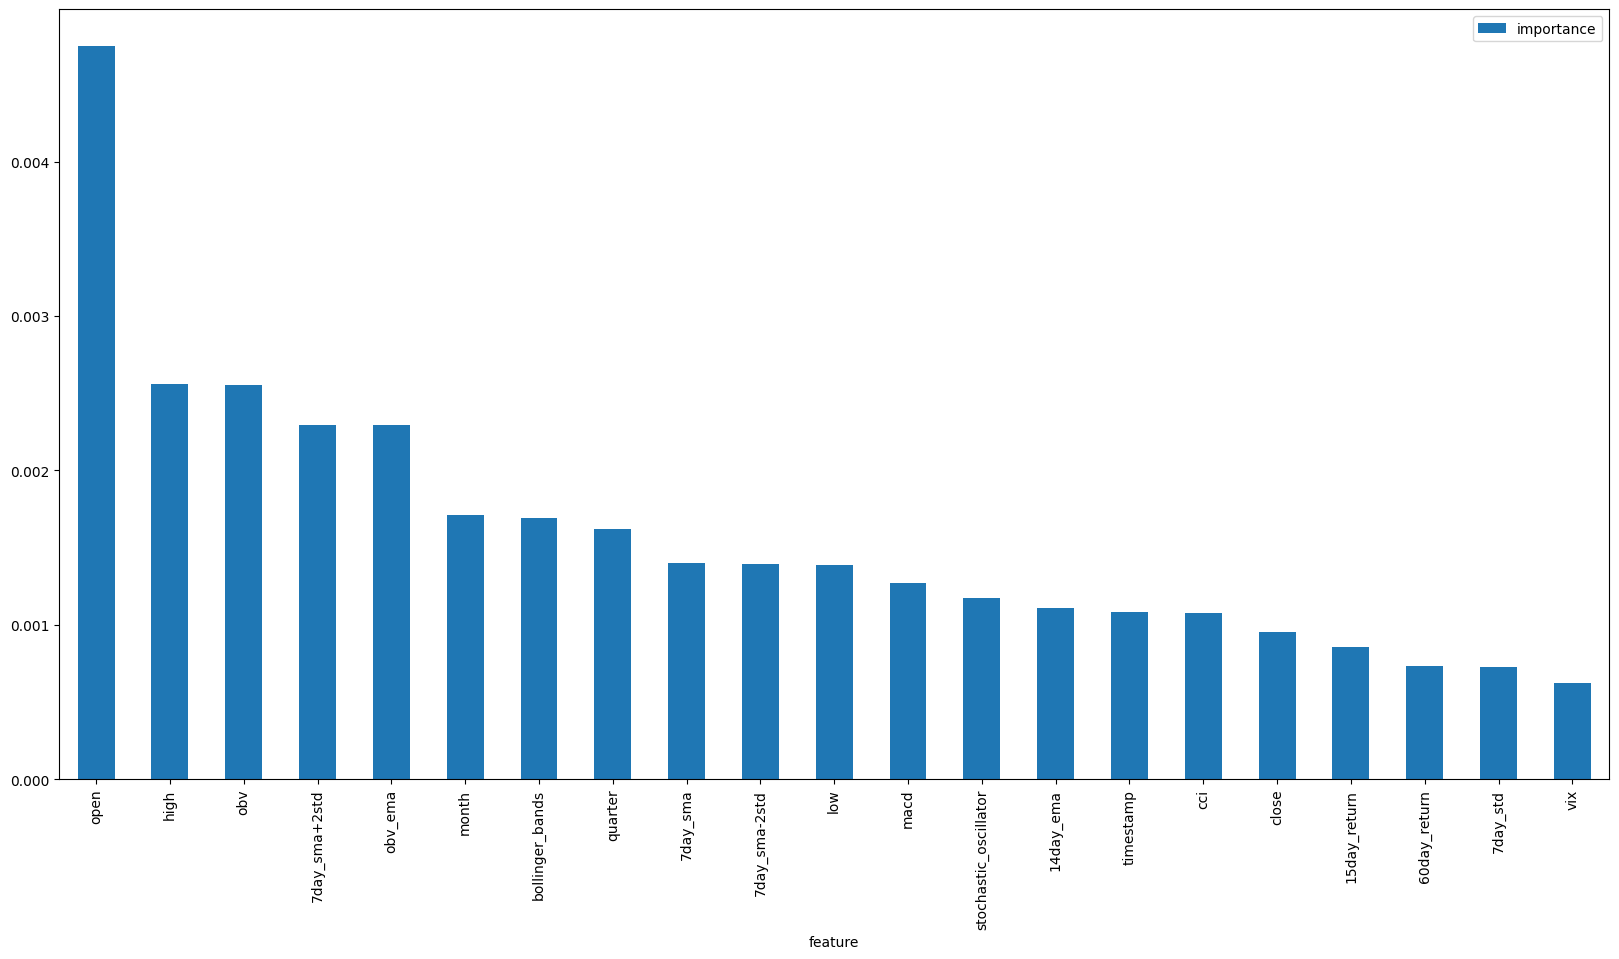

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Correlation coefficient: 0.544703473193207


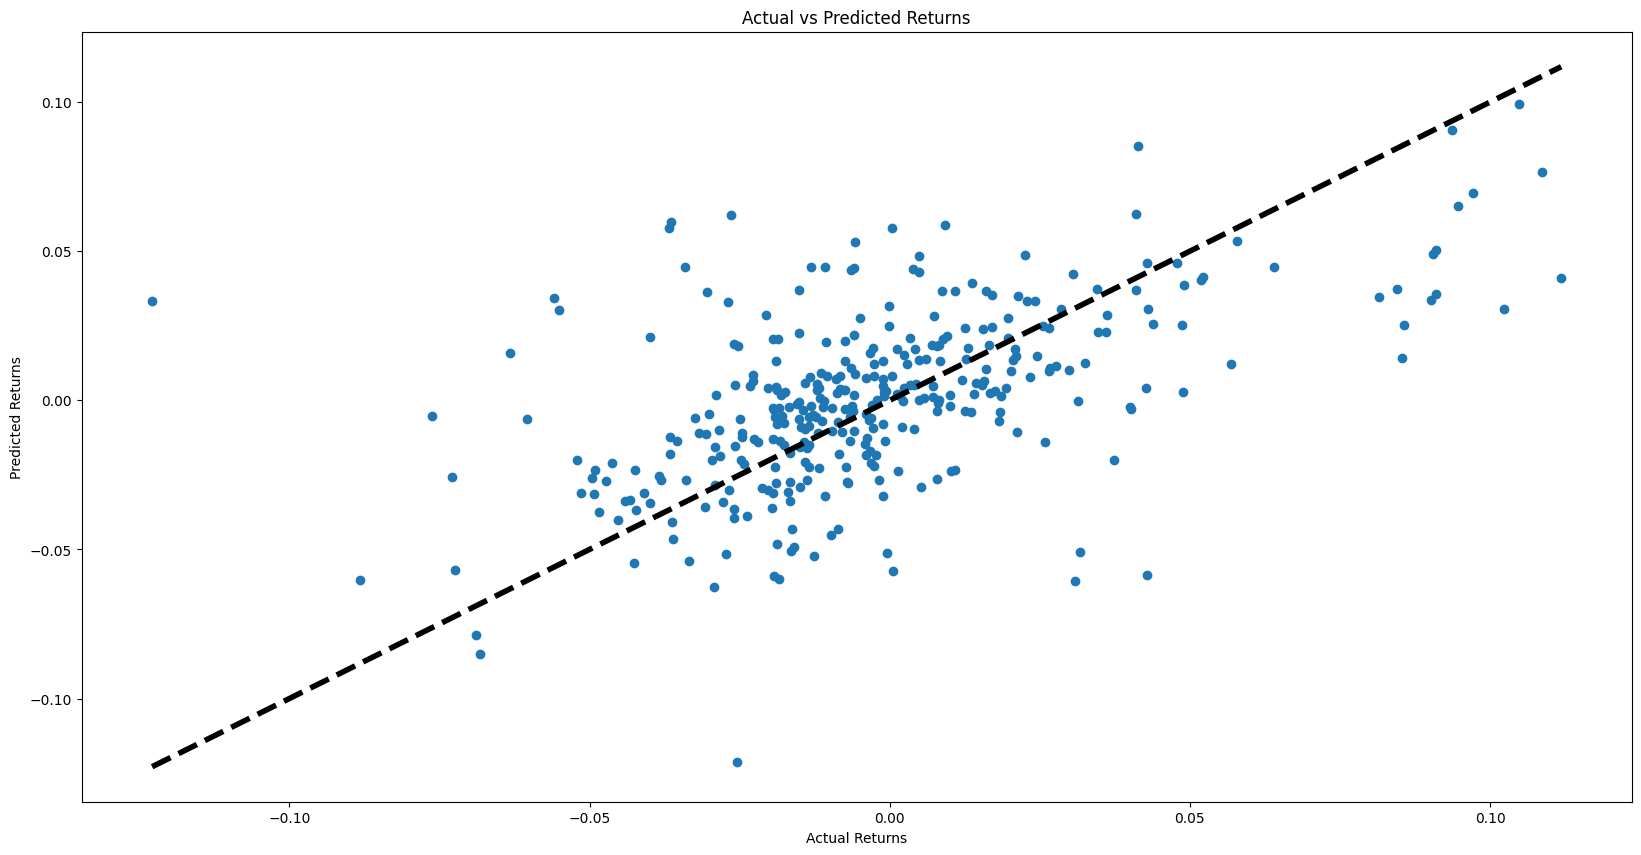

Mean Absolute Error: 0.02119188741041762
Mean Squared Error: 0.0008908576845626304
Root Mean Squared Error: 0.029847239144728786
95% Confidence Interval: +/- 0.058251336939901754
Feature 20 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0007817149938394626


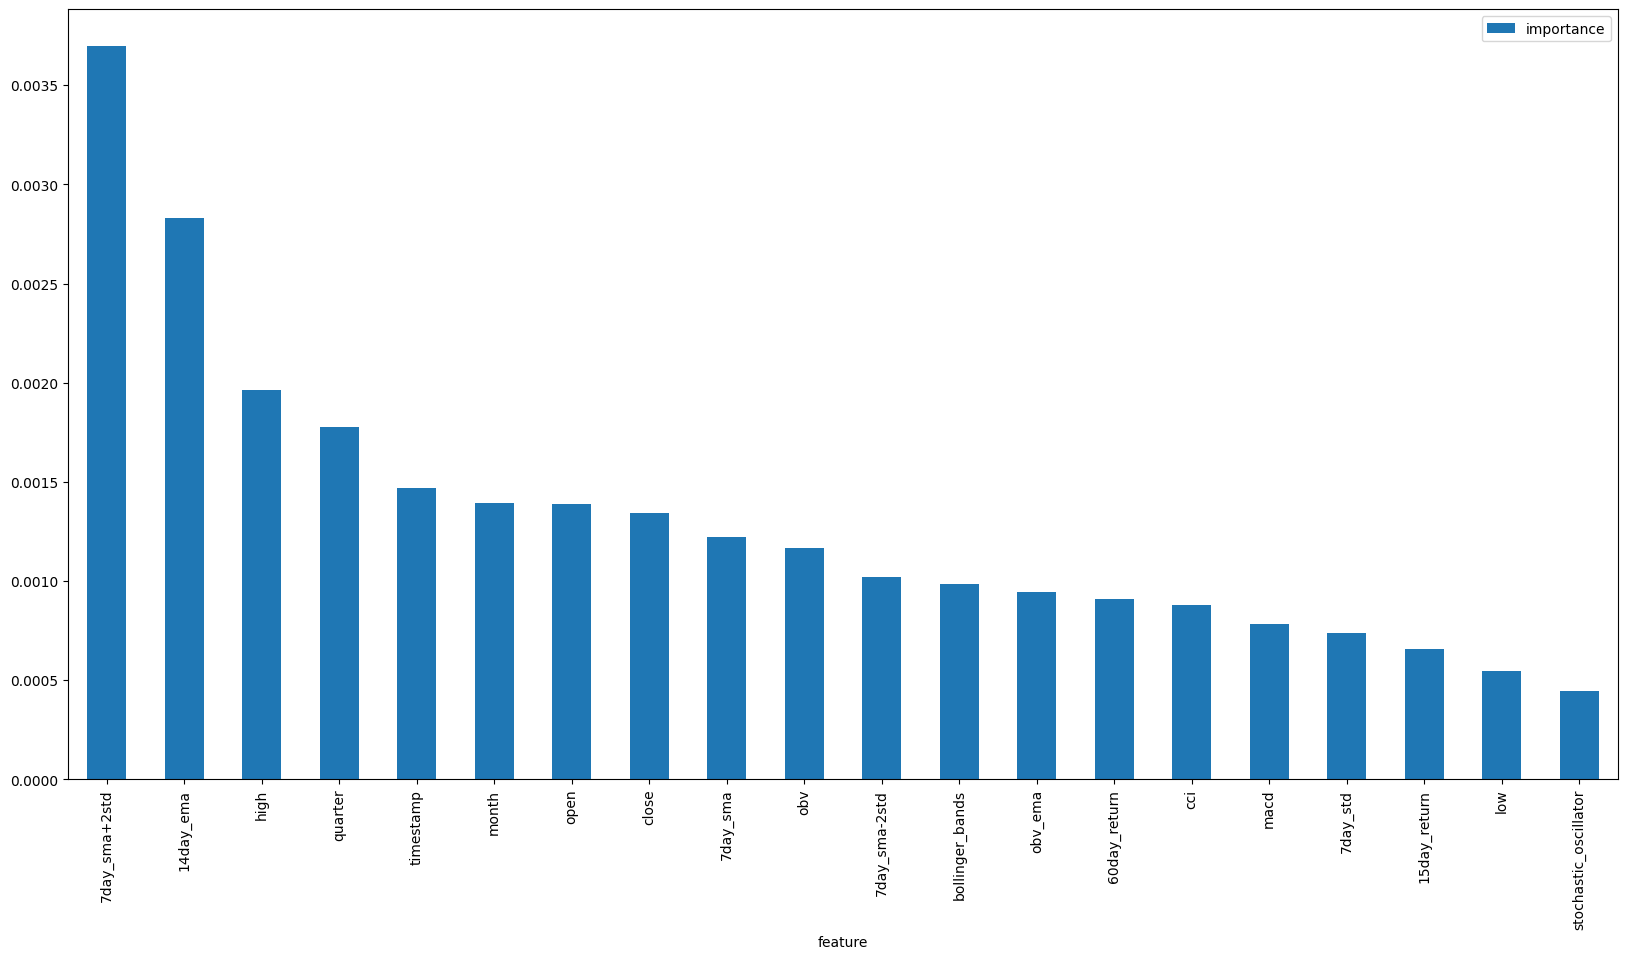

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Correlation coefficient: 0.5856621841092617


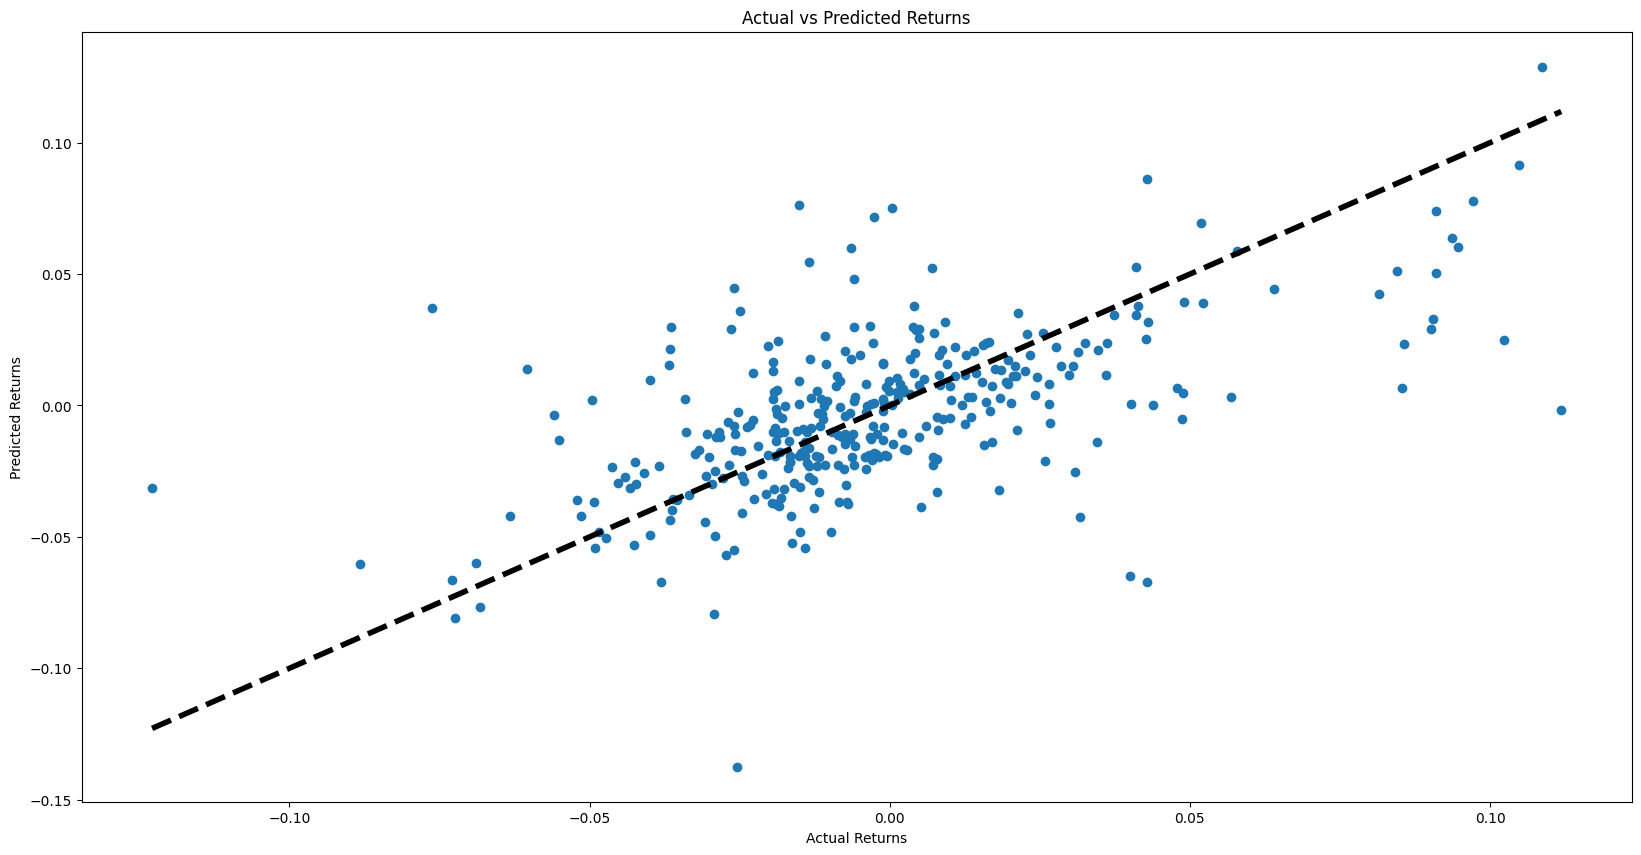

Mean Absolute Error: 0.020171888763551592
Mean Squared Error: 0.0008240253878462174
Root Mean Squared Error: 0.02870584239917403
95% Confidence Interval: +/- 0.05620747340880612
Feature 19 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0006812014811051389


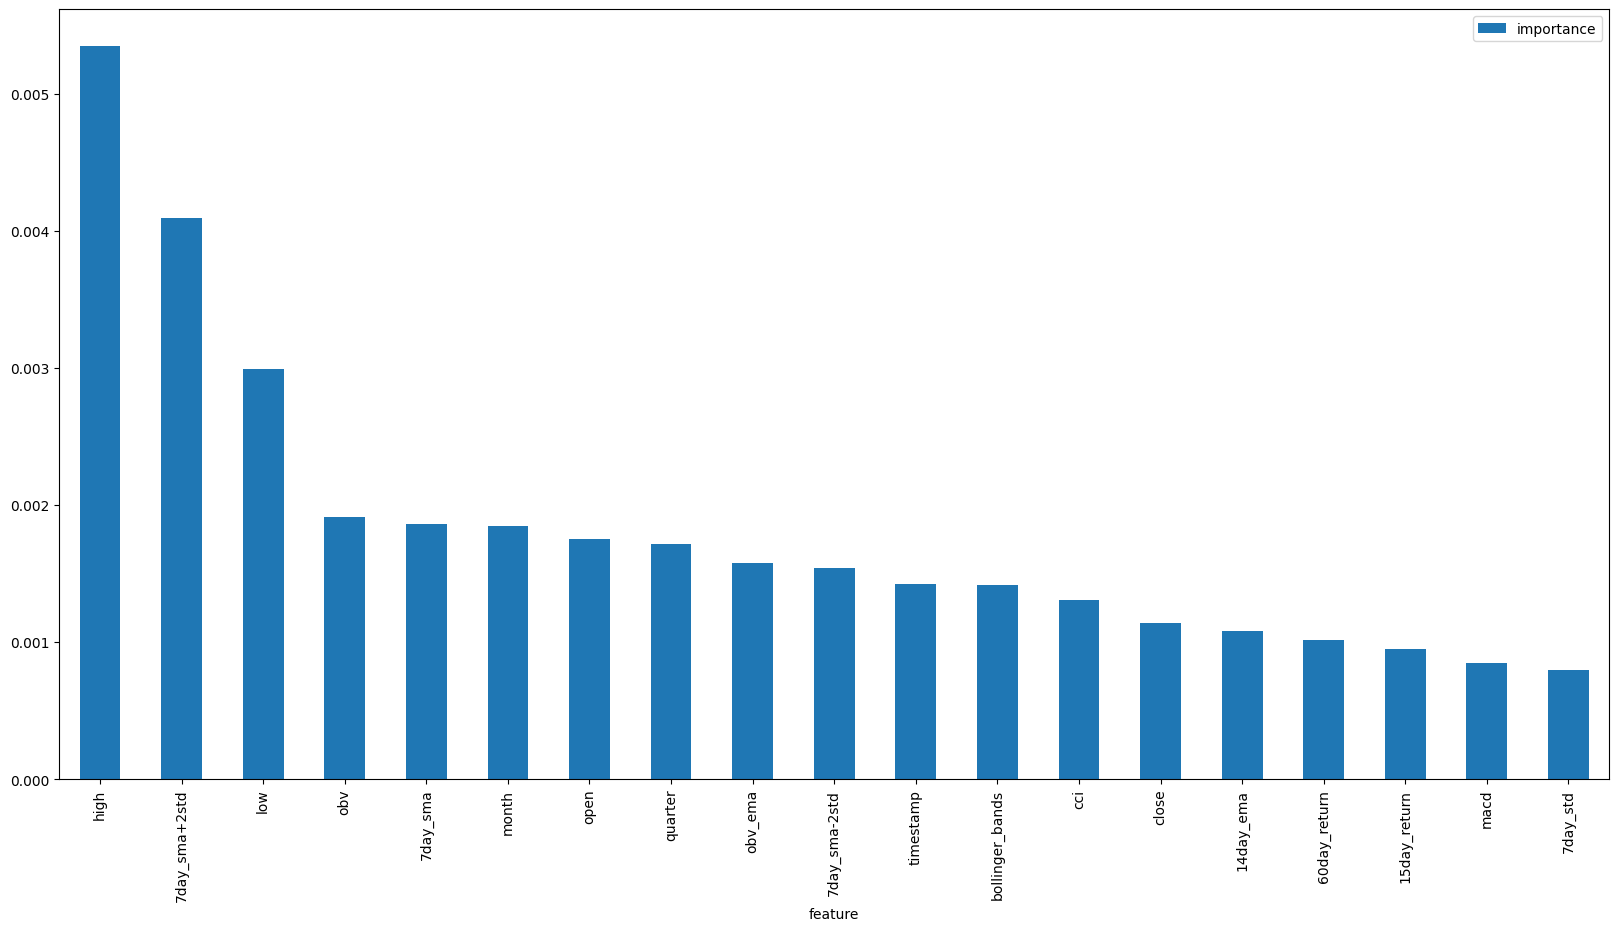

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Correlation coefficient: 0.6386488112619453


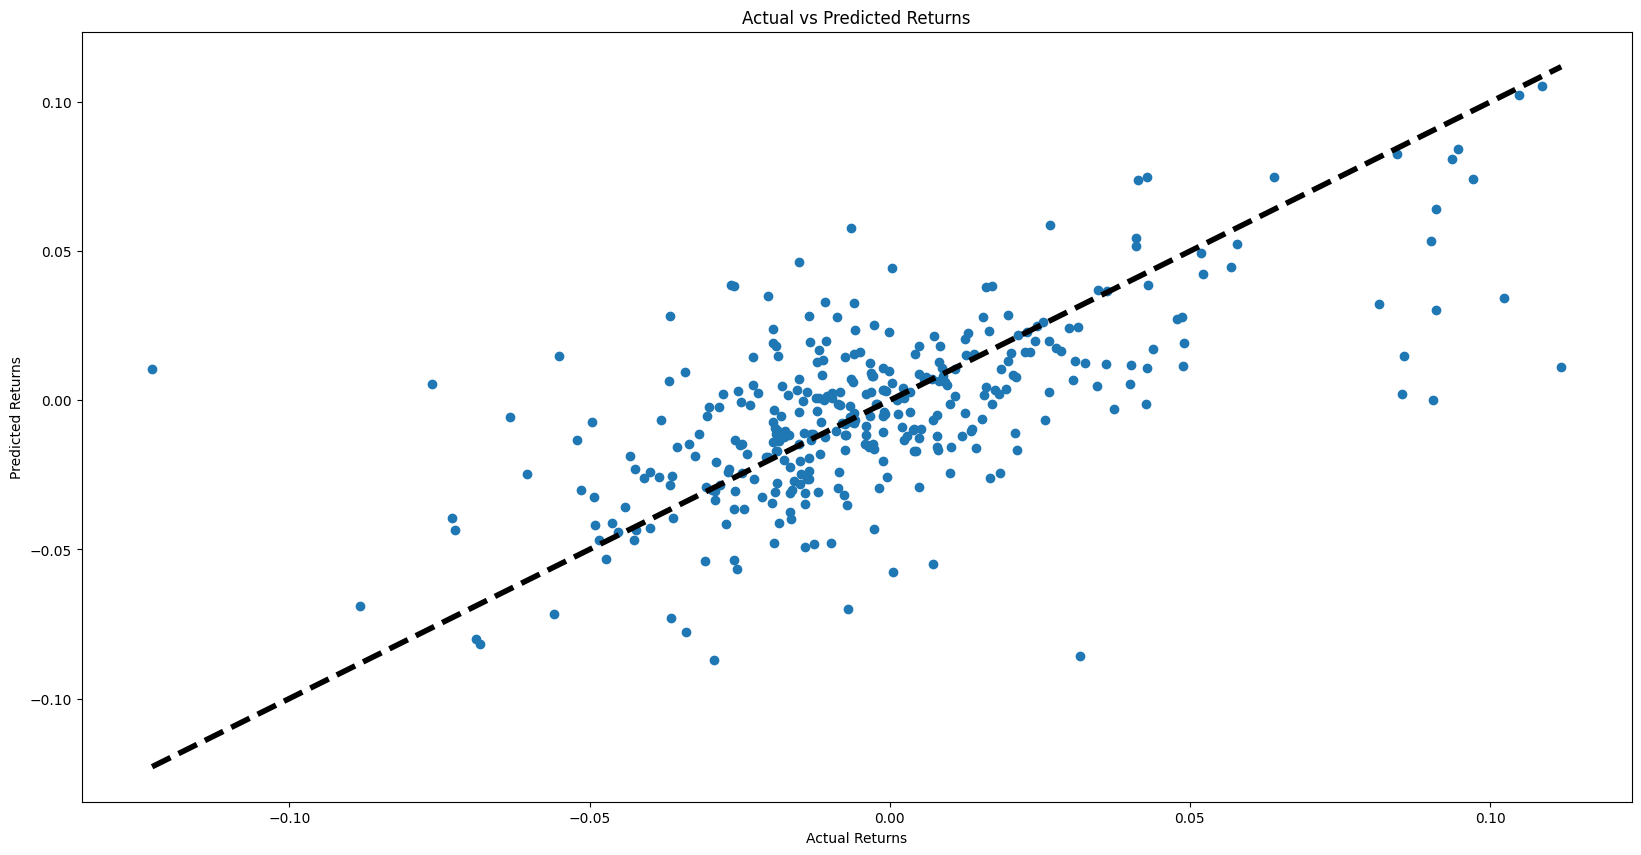

Mean Absolute Error: 0.018562133092297584
Mean Squared Error: 0.0006986053958382972
Root Mean Squared Error: 0.026431144429220184
95% Confidence Interval: +/- 0.05176423742835161
Feature 18 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0007077774692637225


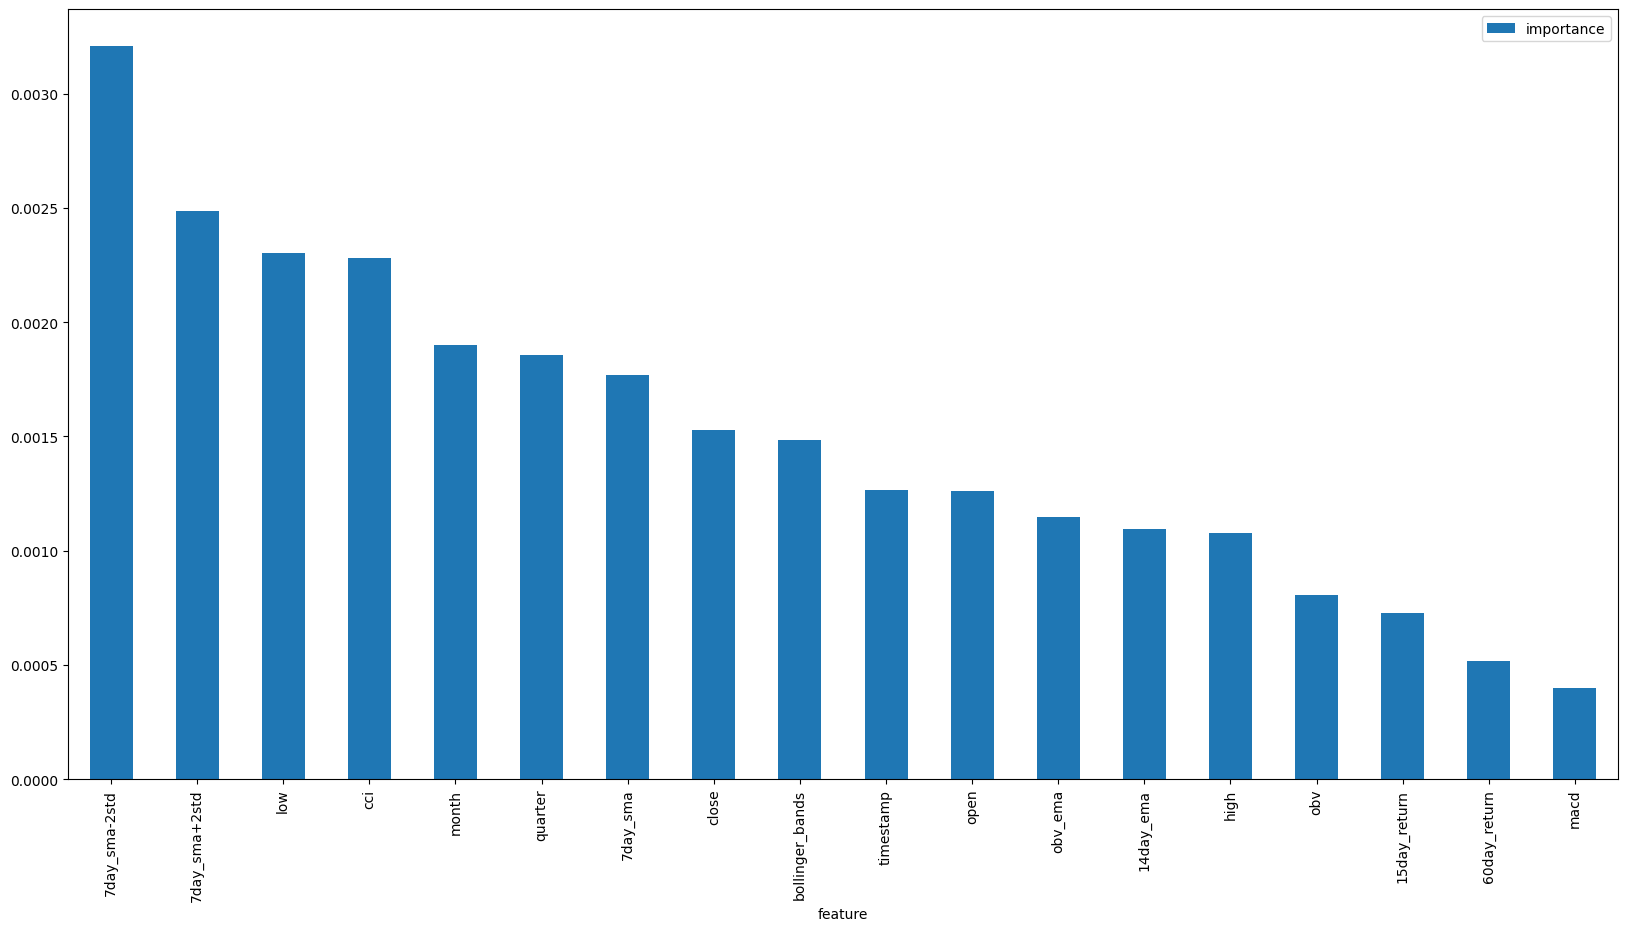

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Correlation coefficient: 0.6256787783181624


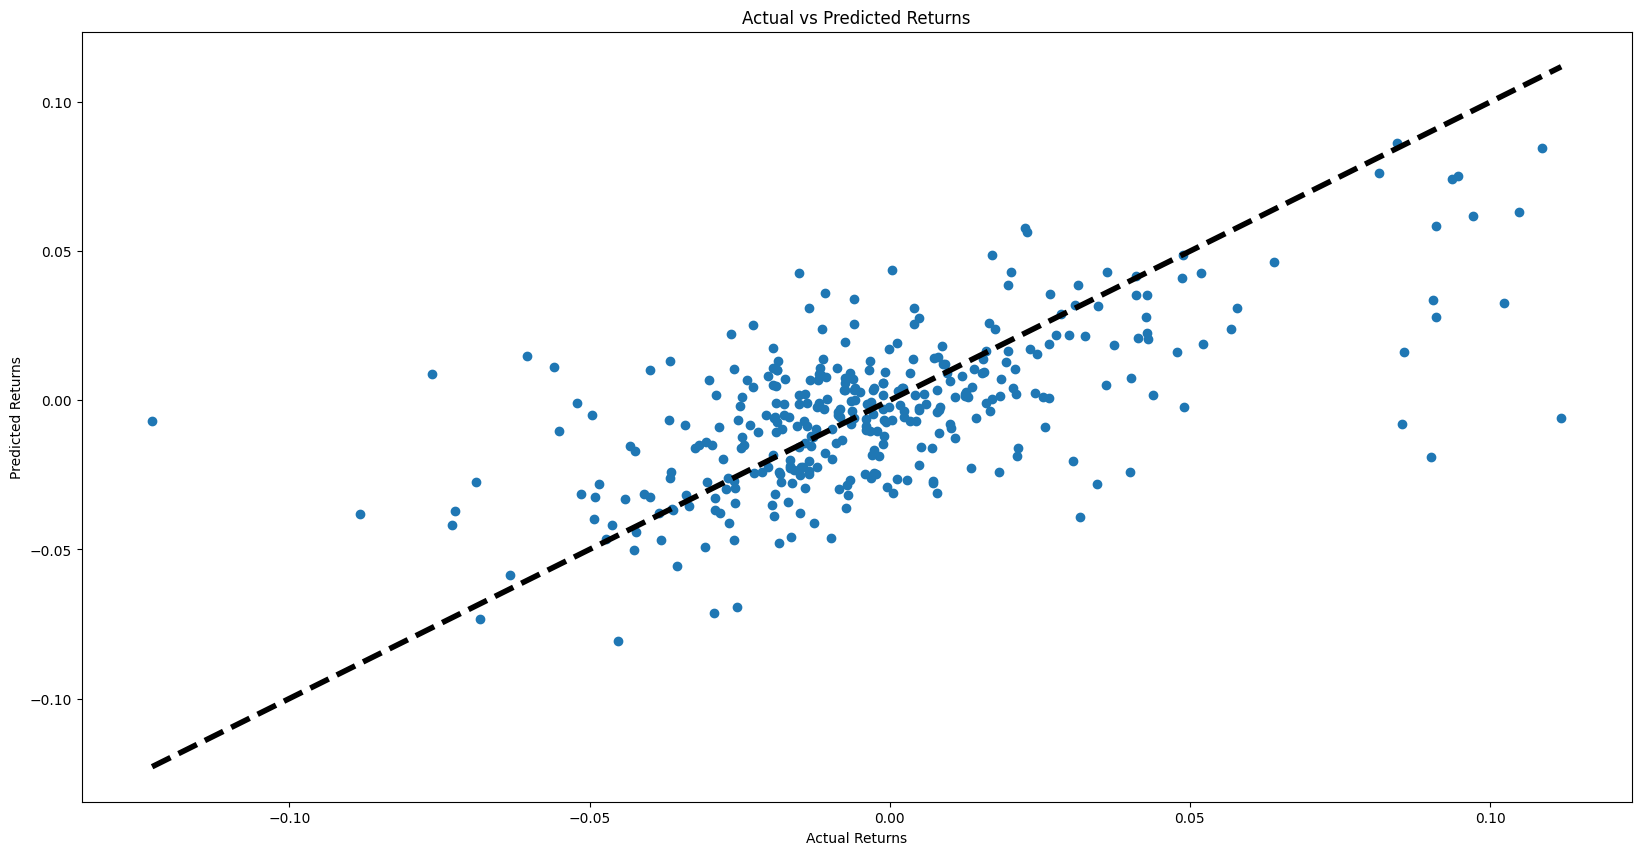

Mean Absolute Error: 0.018569539619752273
Mean Squared Error: 0.0006734817378894099
Root Mean Squared Error: 0.025951526696697633
95% Confidence Interval: +/- 0.050807802089284766
Feature 17 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0006903210693659881


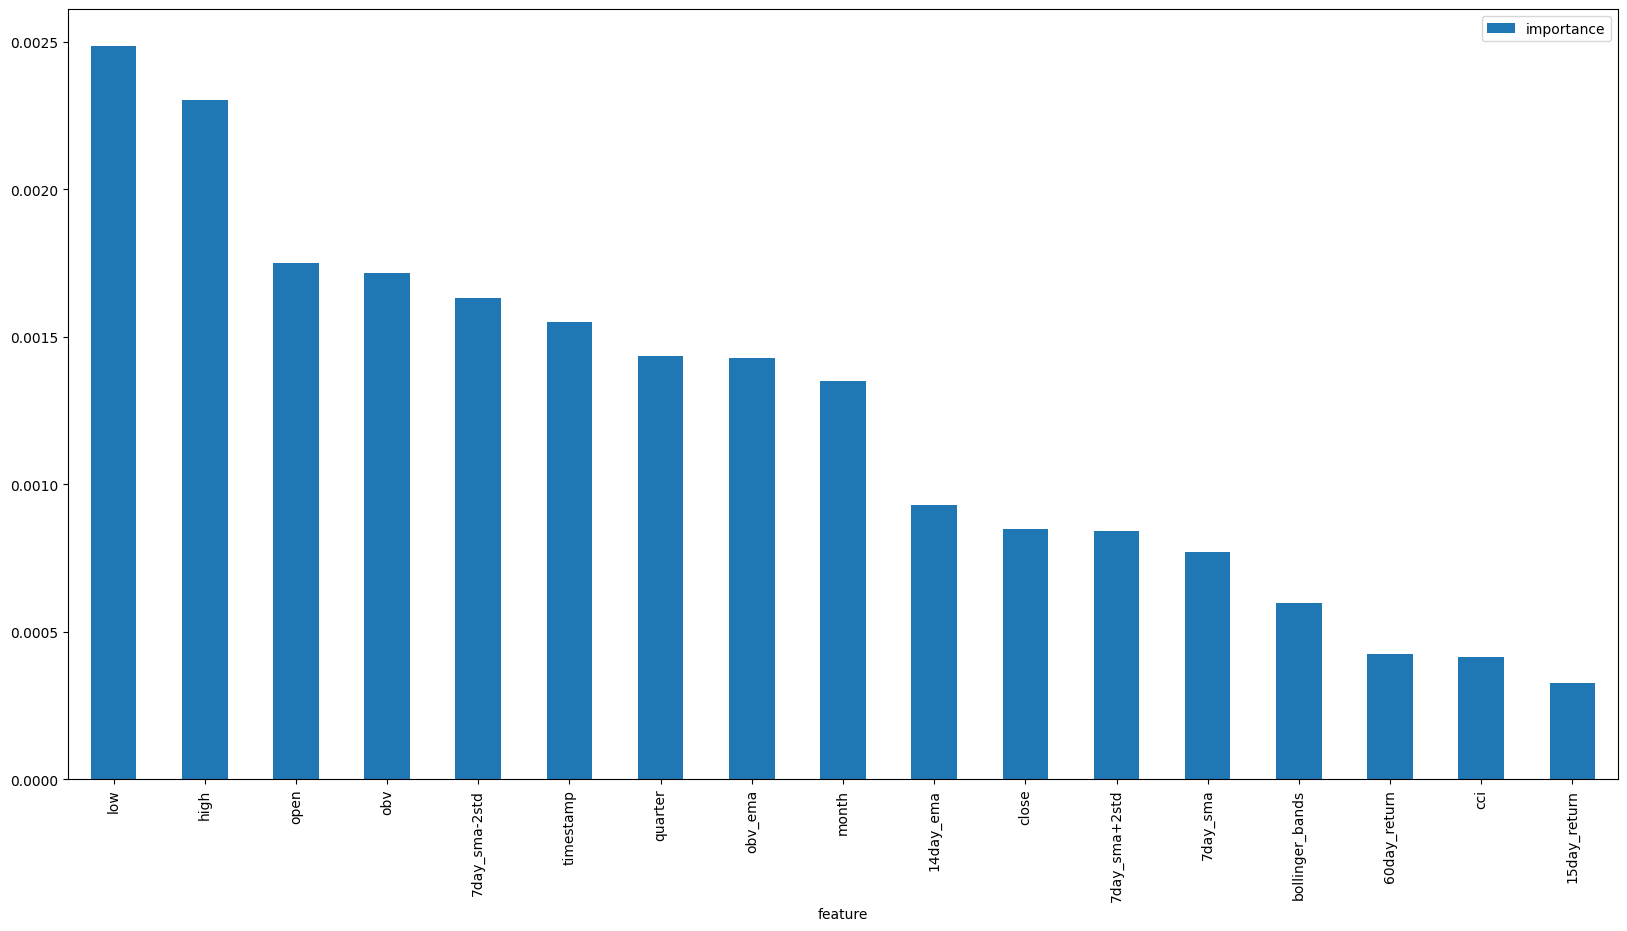

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Correlation coefficient: 0.5983533235058046


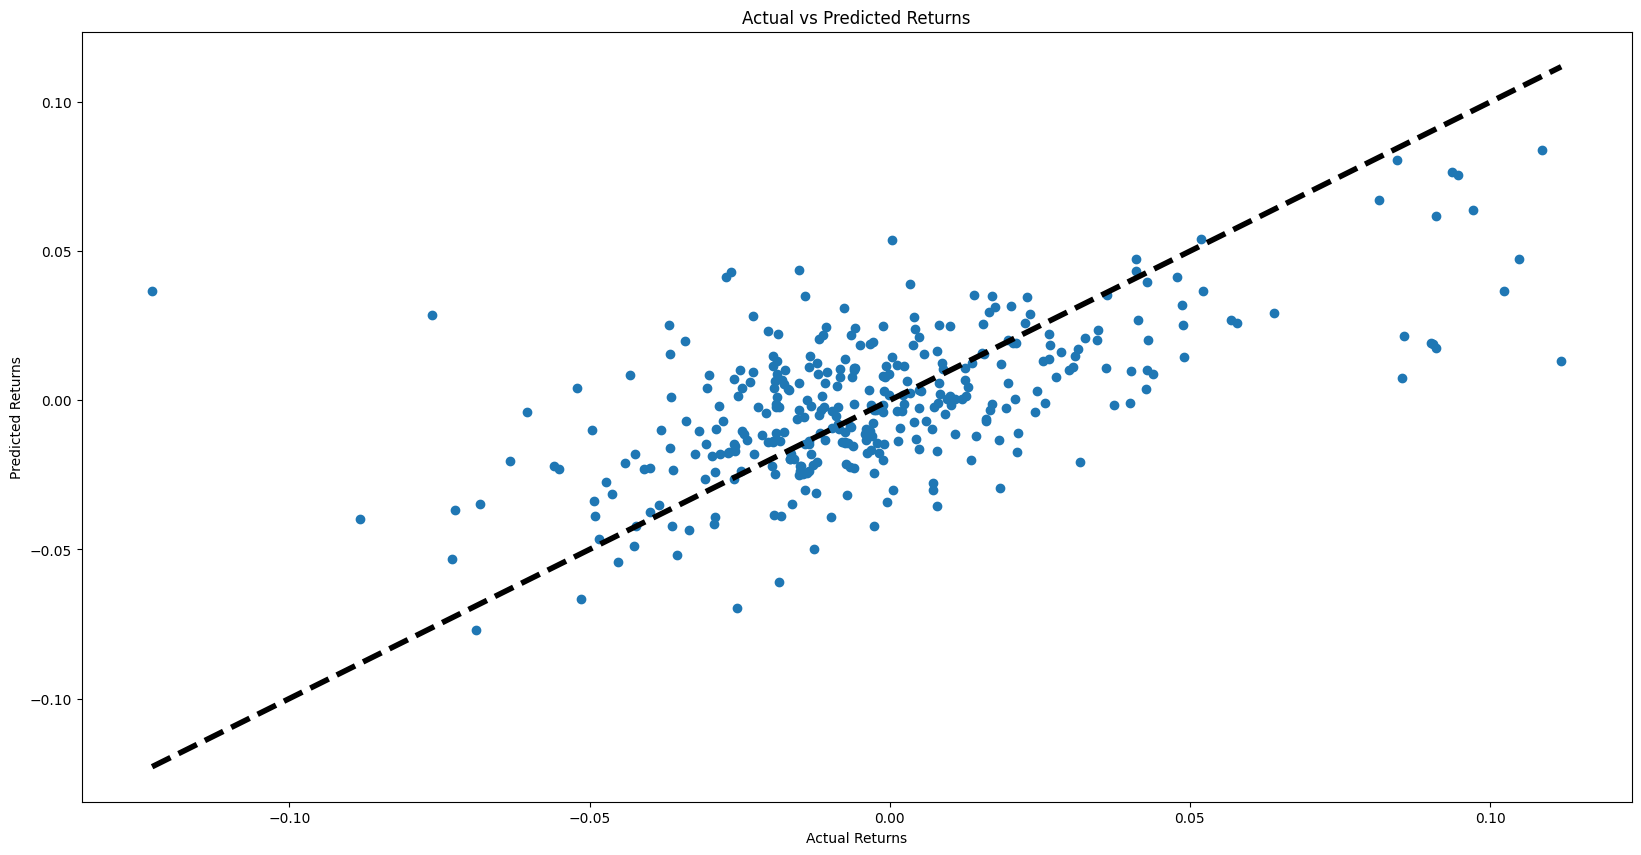

Mean Absolute Error: 0.019318964771248337
Mean Squared Error: 0.0007040158297547801
Root Mean Squared Error: 0.02653329662433185
95% Confidence Interval: +/- 0.051930673227810836
Feature 16 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0007020168122835457


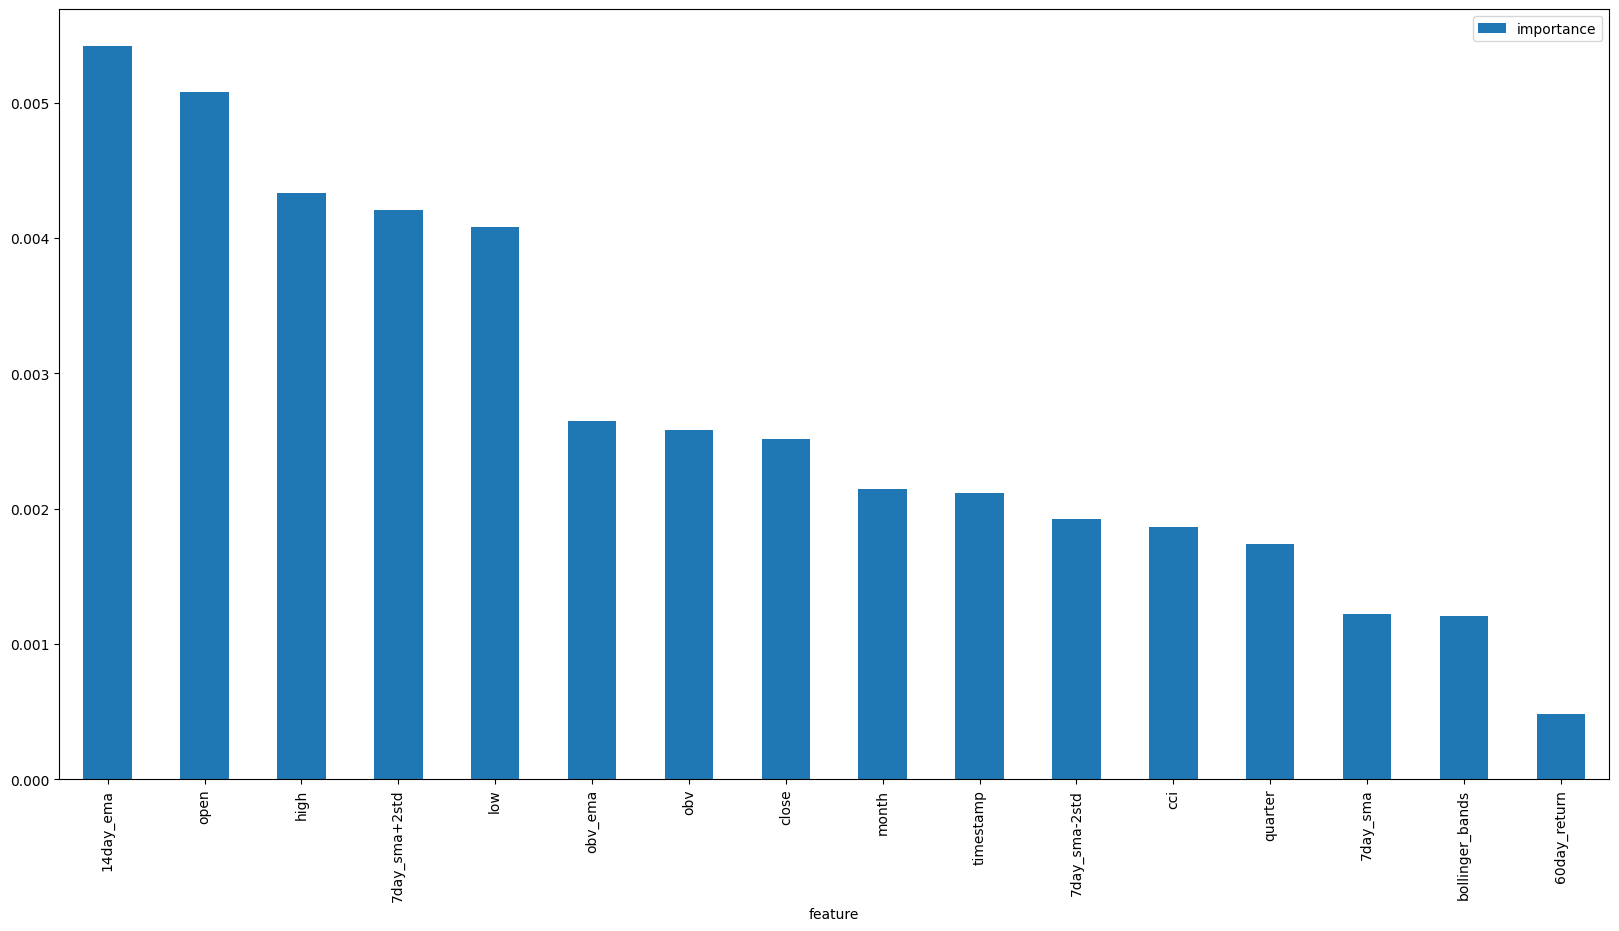

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Correlation coefficient: 0.6103438354786354


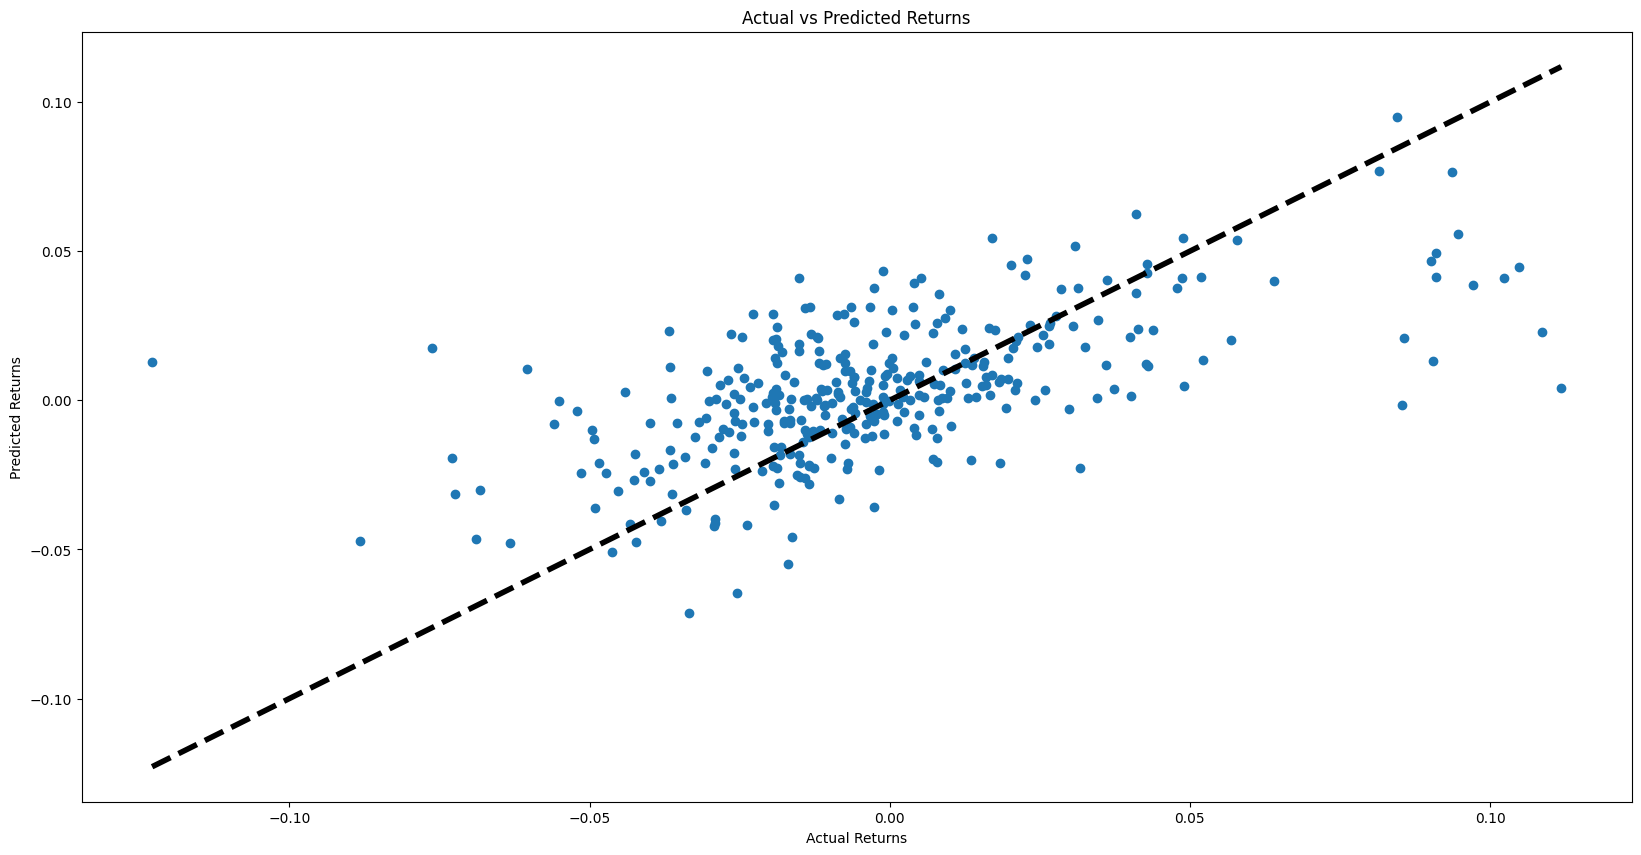

Mean Absolute Error: 0.019411197644876515
Mean Squared Error: 0.0007043782077557509
Root Mean Squared Error: 0.026540124486440355
95% Confidence Interval: +/- 0.05090621616702732
Feature 15 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0007539095628696183


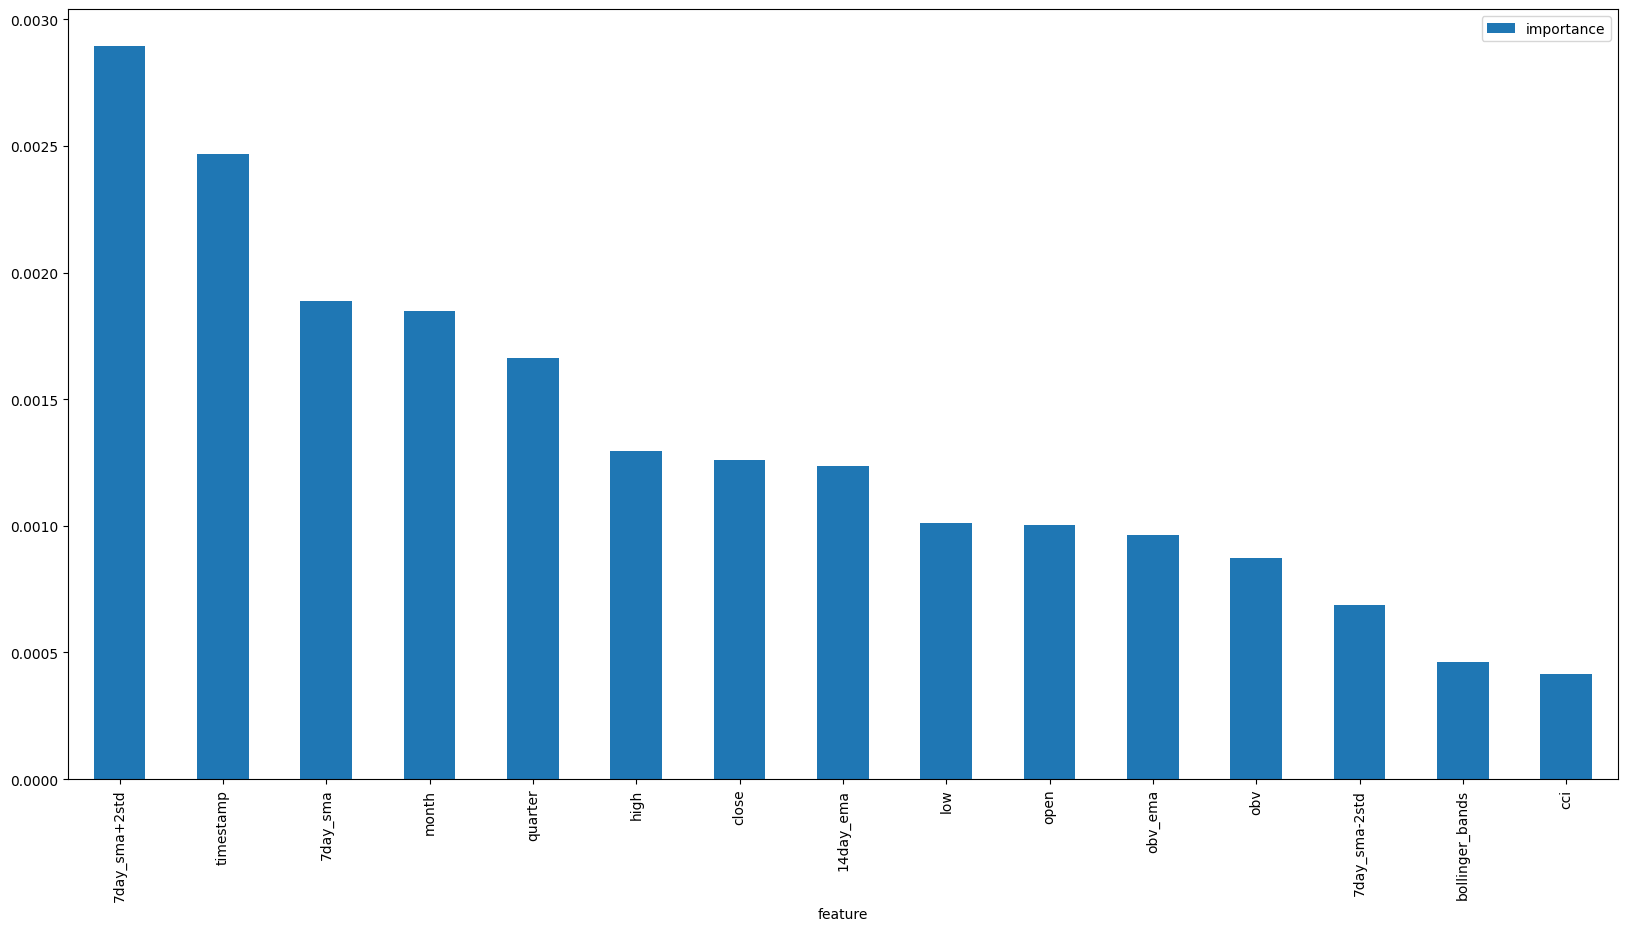

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Correlation coefficient: 0.5125867058070692


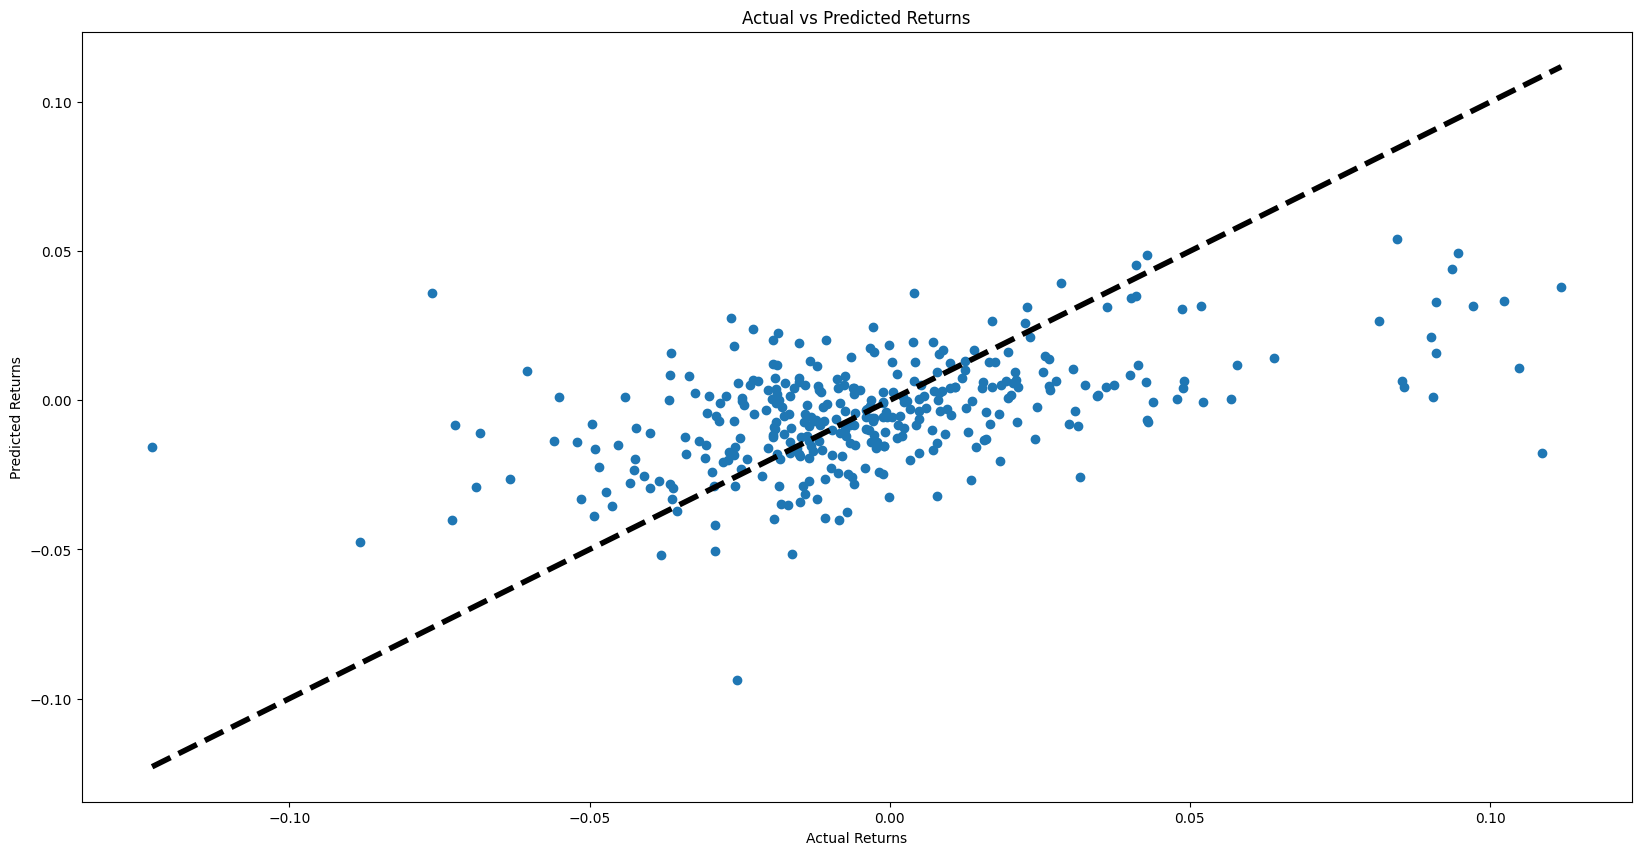

Mean Absolute Error: 0.020274125930838313
Mean Squared Error: 0.0007863474251744248
Root Mean Squared Error: 0.02804188697599405
95% Confidence Interval: +/- 0.05481186150238832
Feature 14 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0007321986098152896


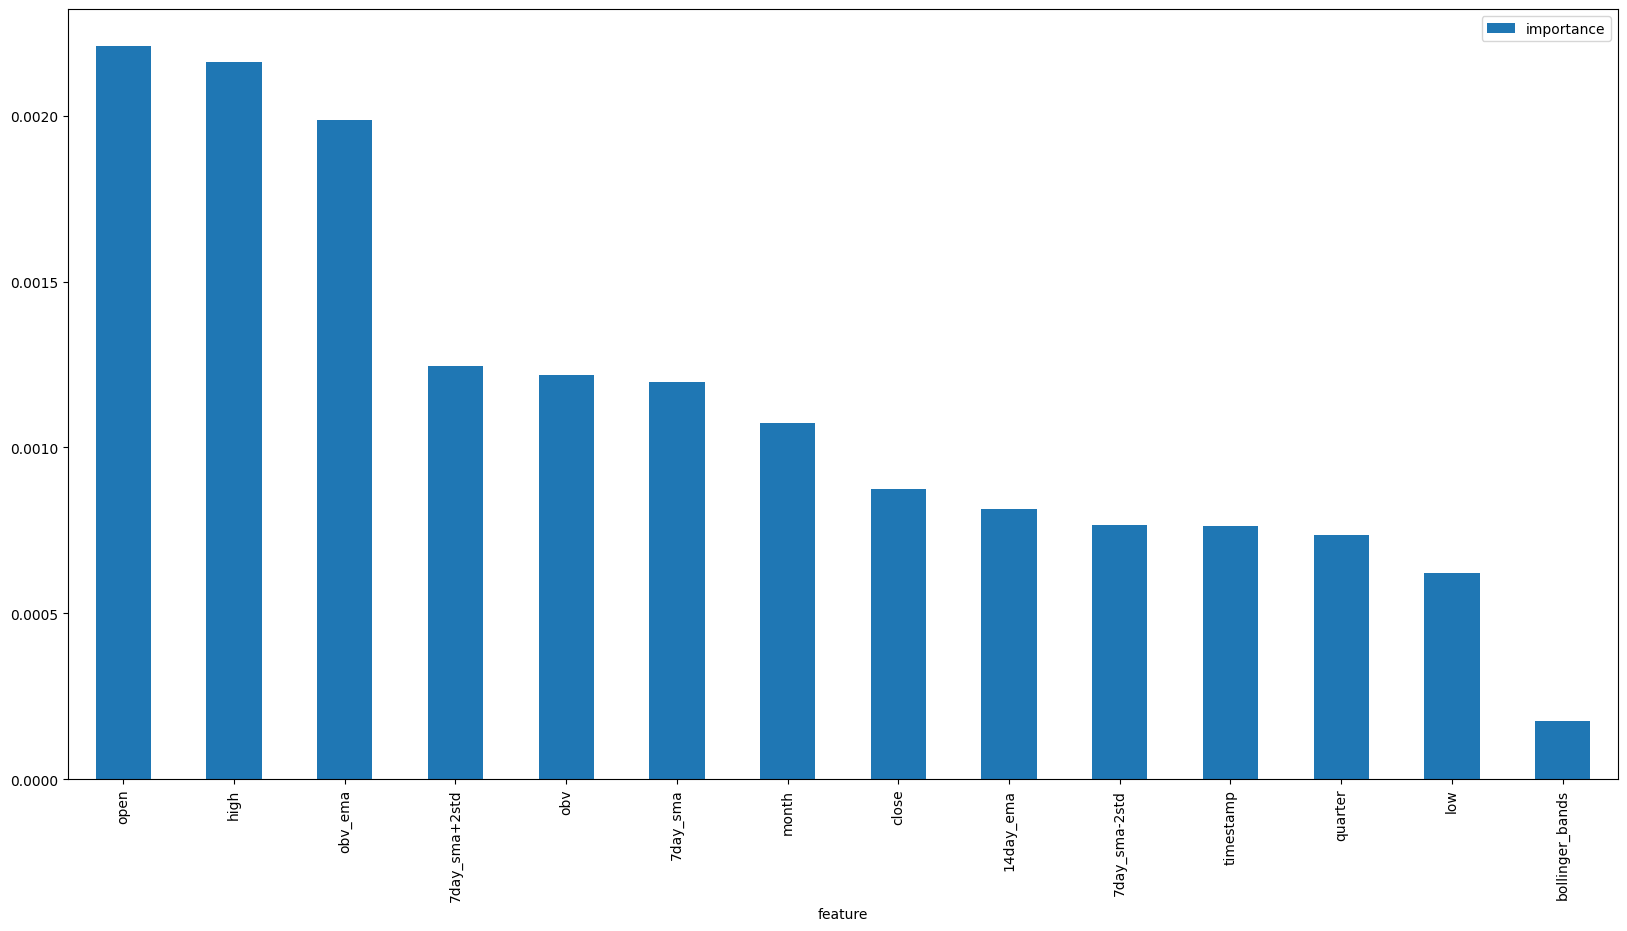

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Correlation coefficient: 0.5218349338427347


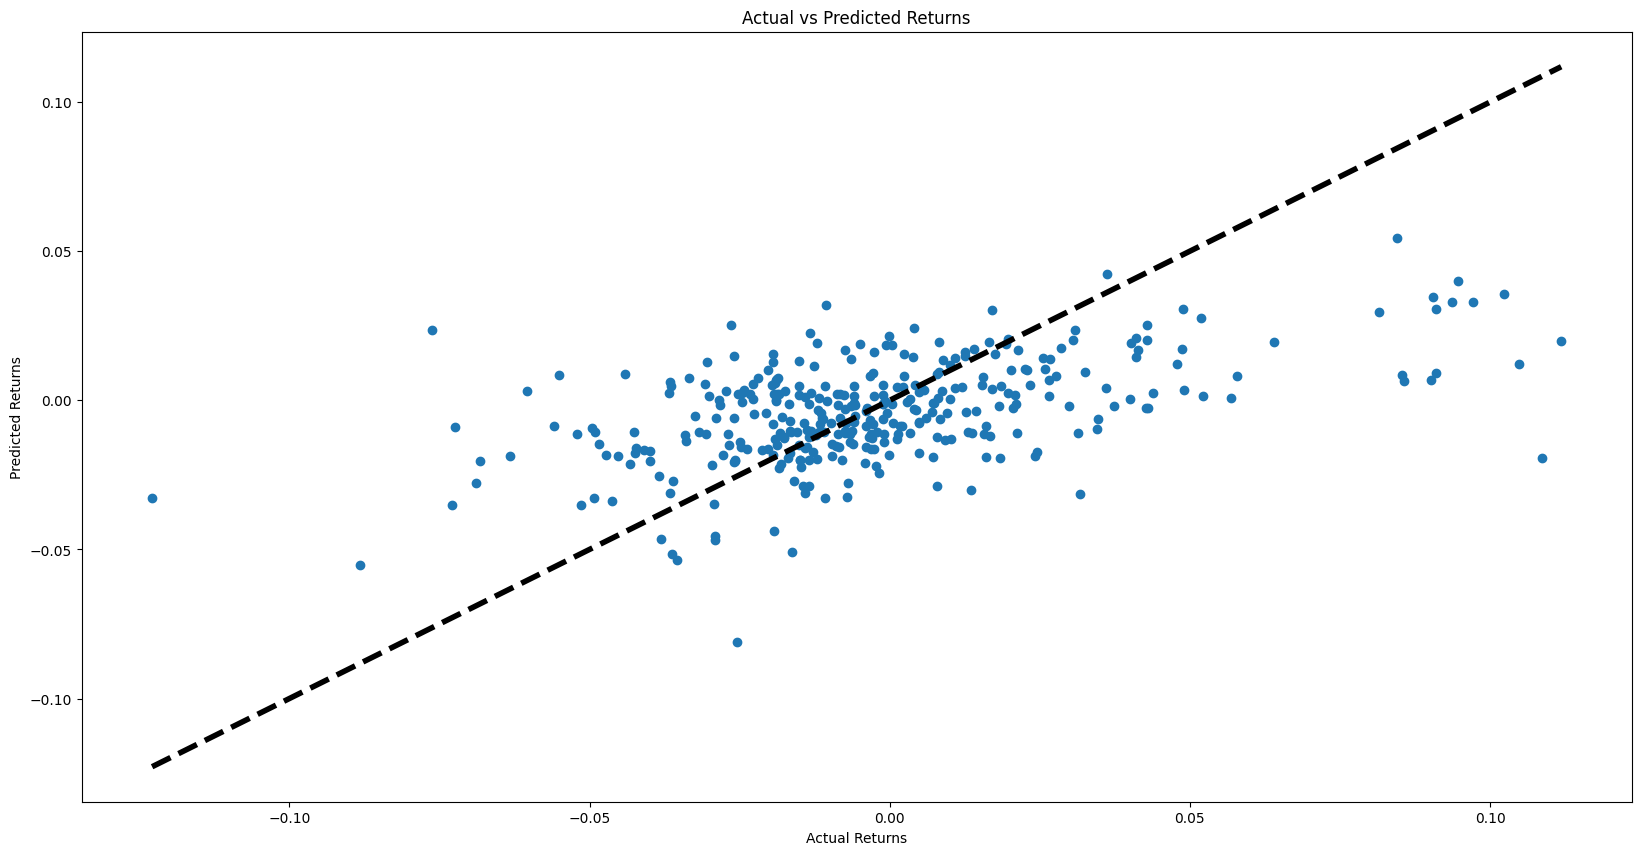

Mean Absolute Error: 0.020249118614941598
Mean Squared Error: 0.000771482208472983
Root Mean Squared Error: 0.027775568553550494
95% Confidence Interval: +/- 0.054340947142922834
Feature 13 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0007229727925732732


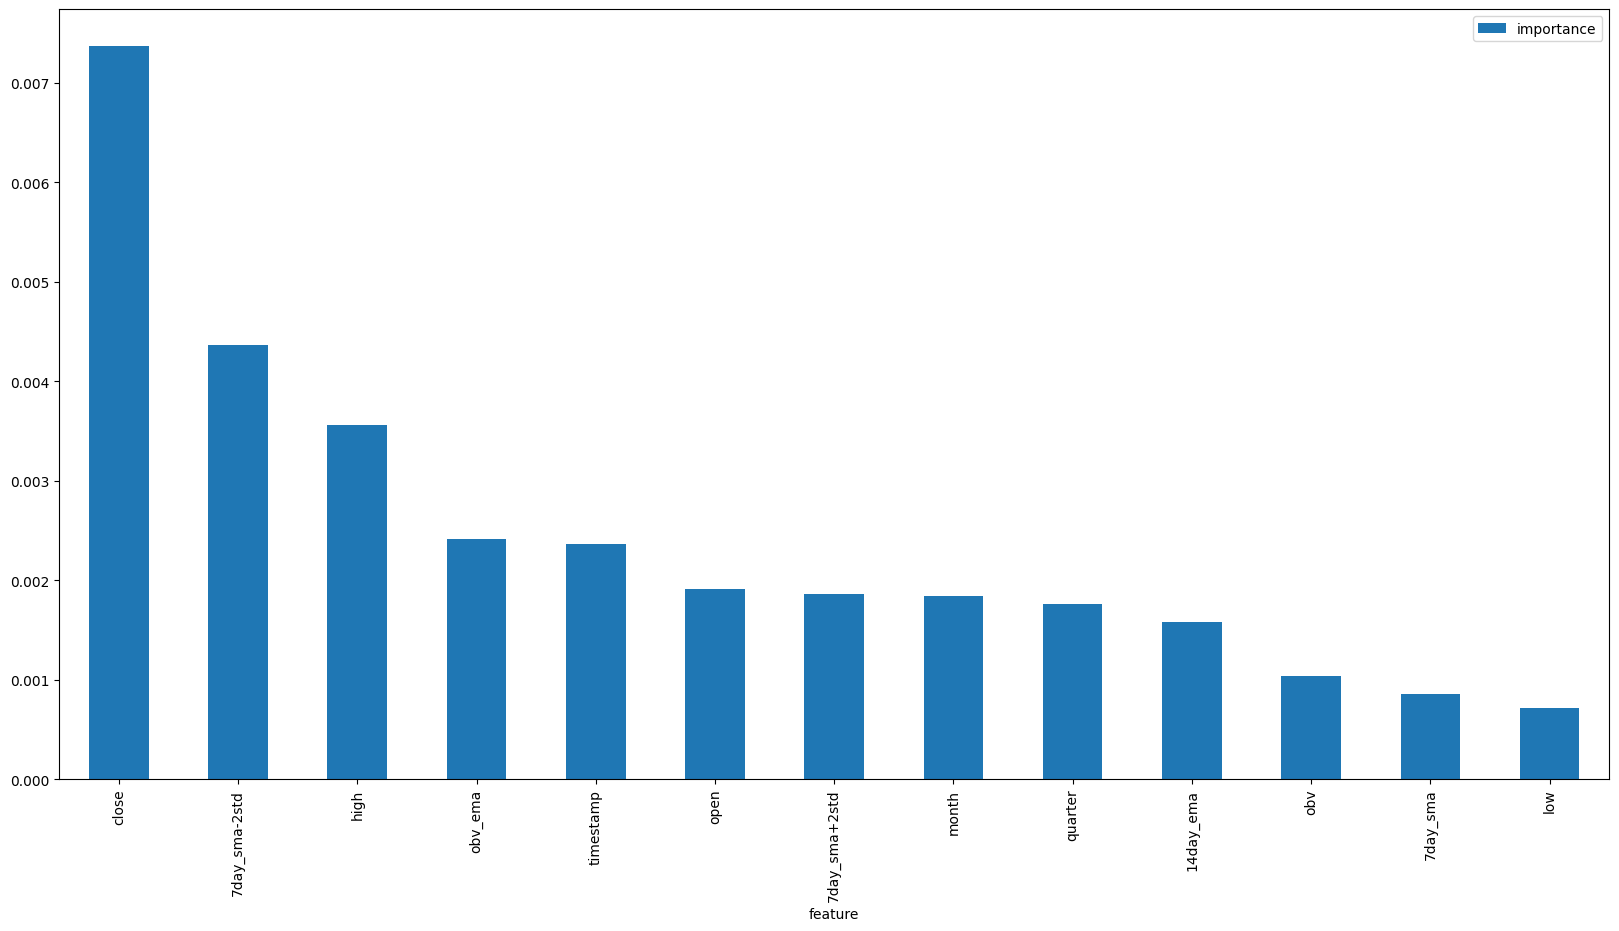

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Correlation coefficient: 0.5406008170058431


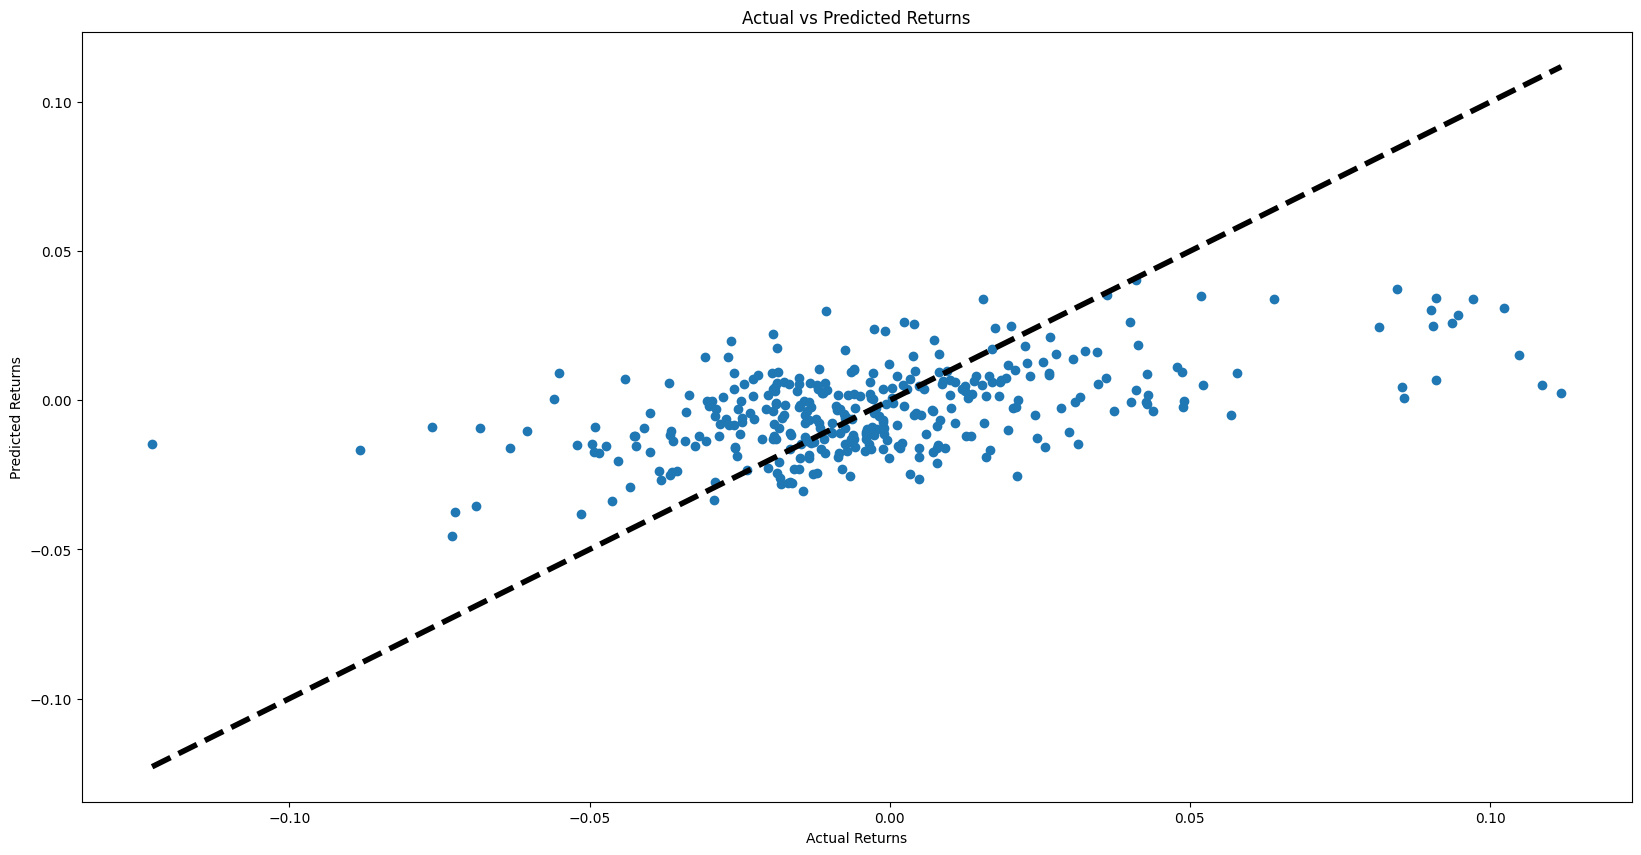

Mean Absolute Error: 0.020277721218583636
Mean Squared Error: 0.0007579300063588613
Root Mean Squared Error: 0.02753052862476239
95% Confidence Interval: +/- 0.053922979190128305
Feature 12 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0006760802546826502


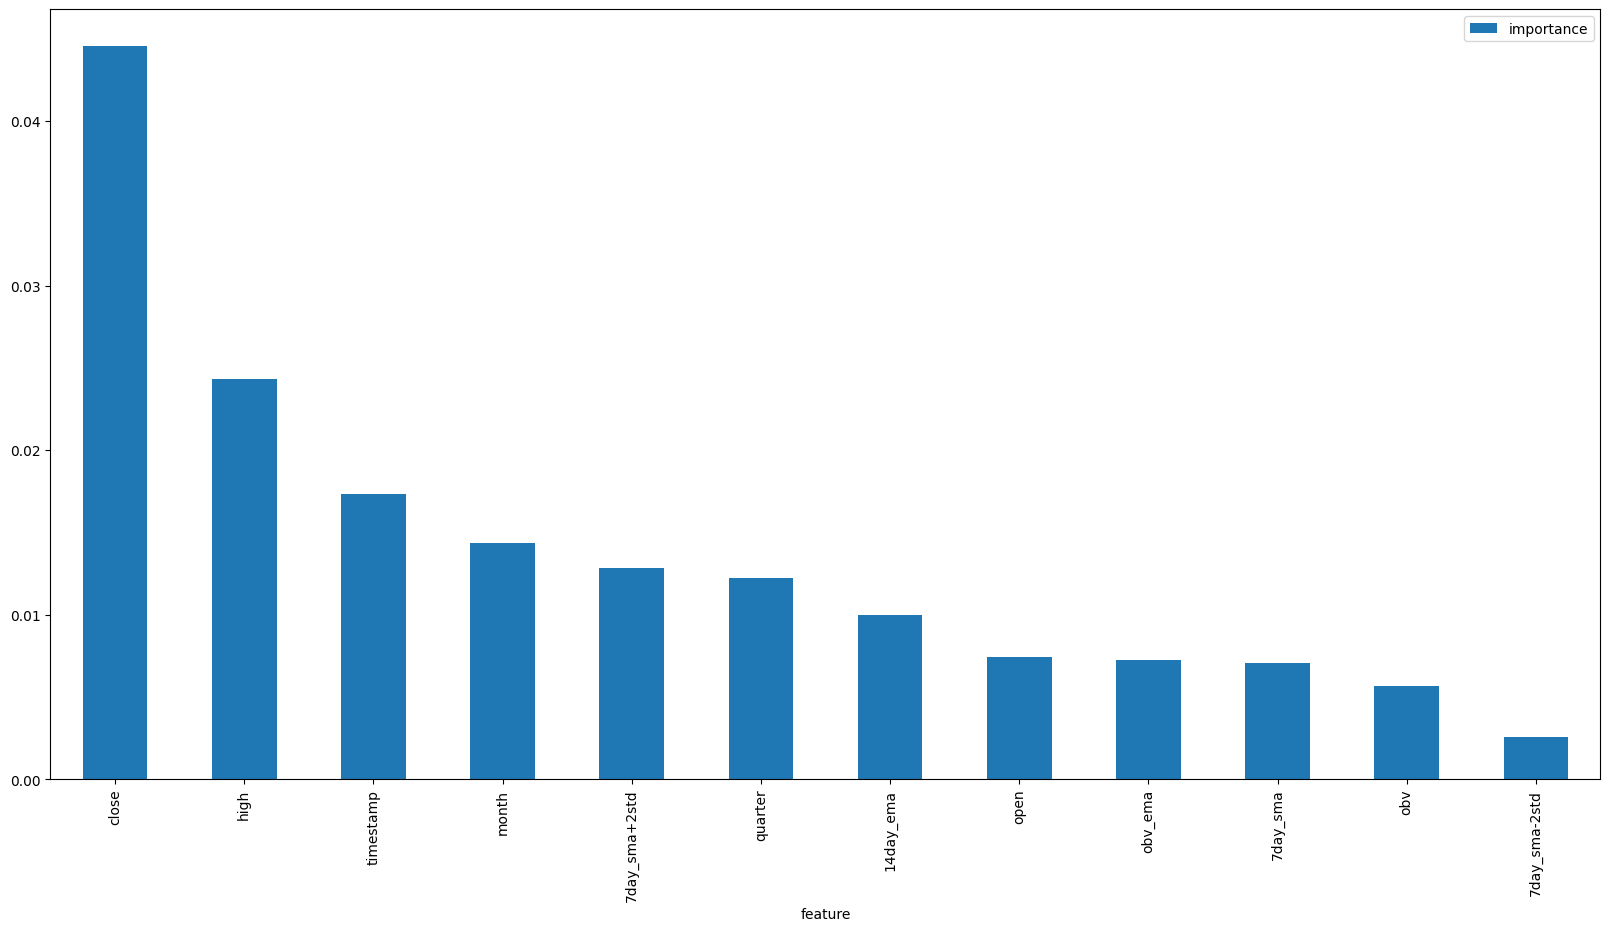

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Correlation coefficient: 0.6077944102840113


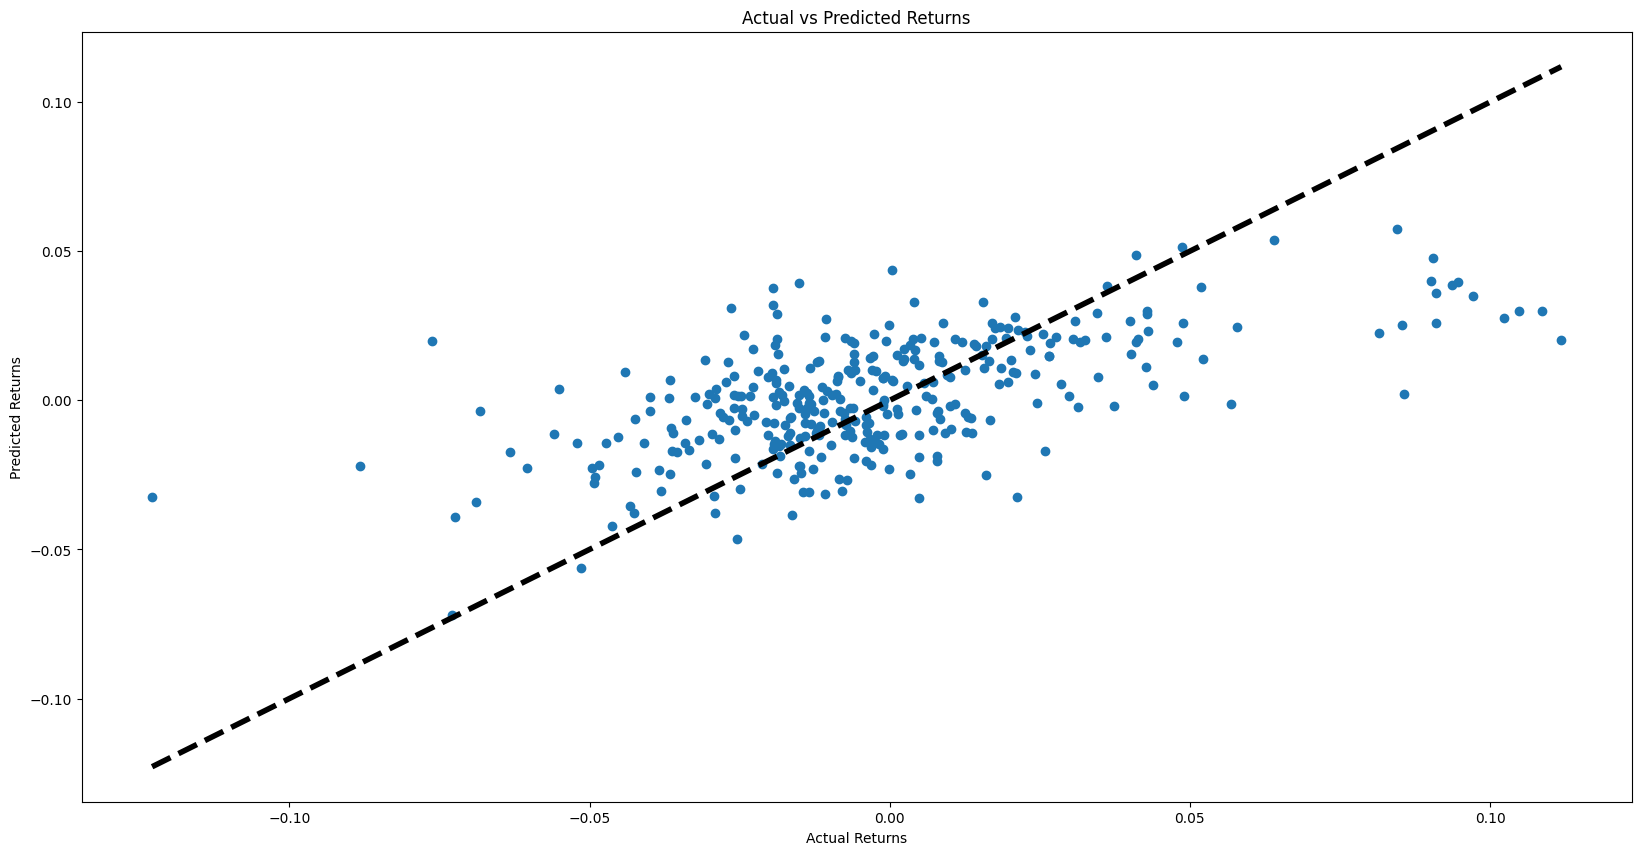

Mean Absolute Error: 0.01952114841902415
Mean Squared Error: 0.0006773001788798892
Root Mean Squared Error: 0.02602499142900703
95% Confidence Interval: +/- 0.05059350570135694
Feature 11 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0007309602224268019


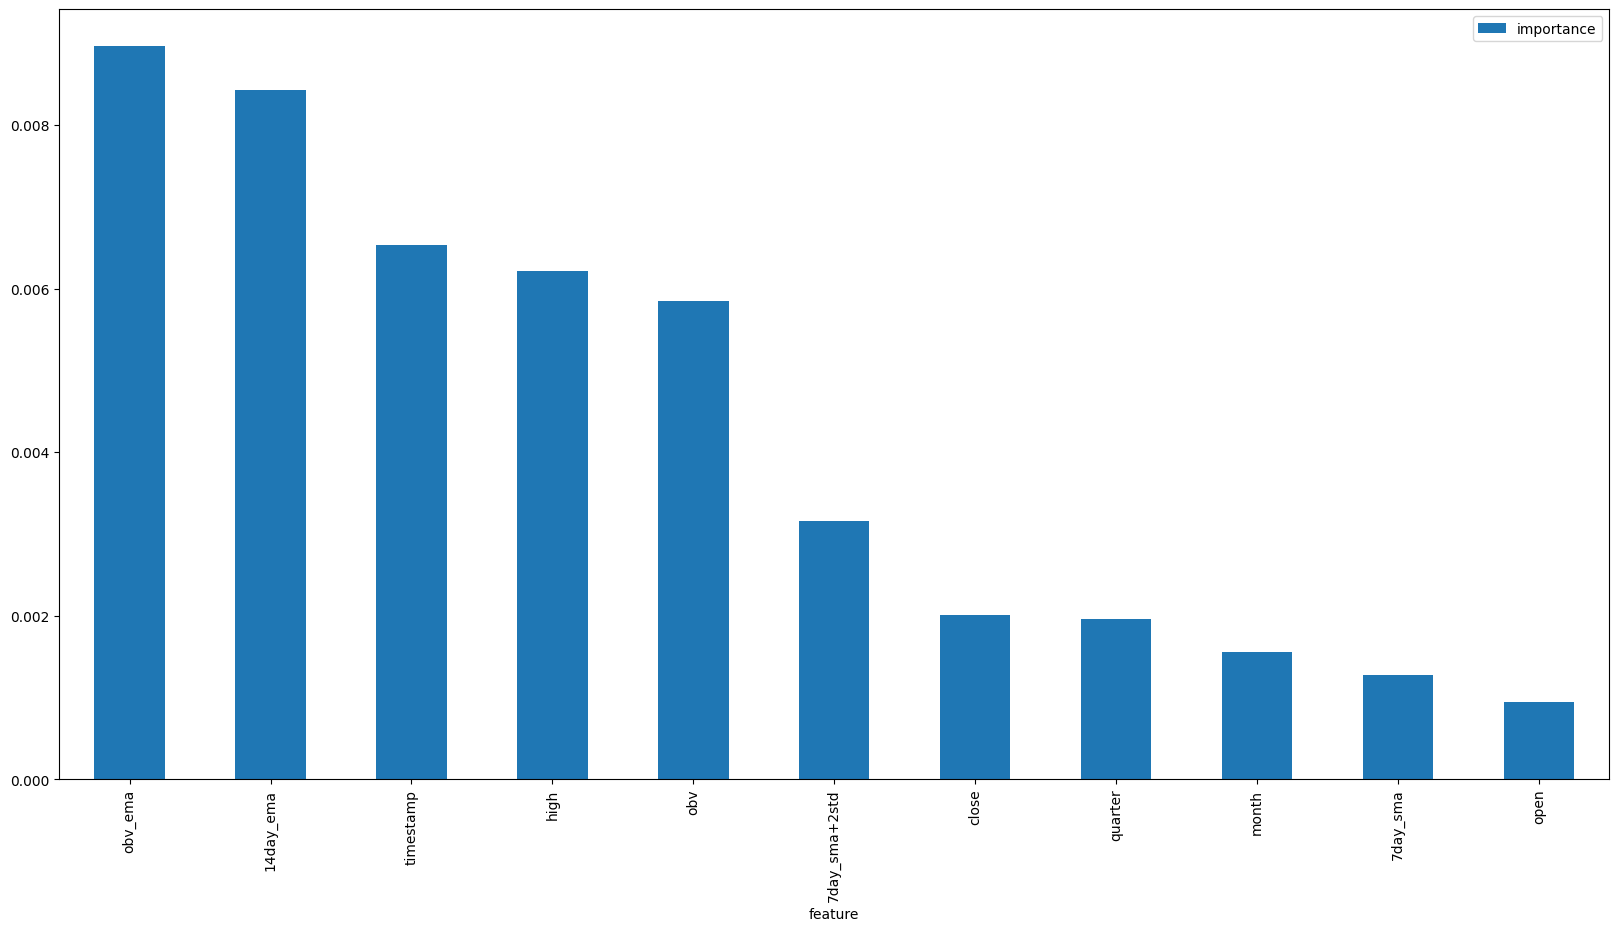

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Correlation coefficient: 0.5356063346186818


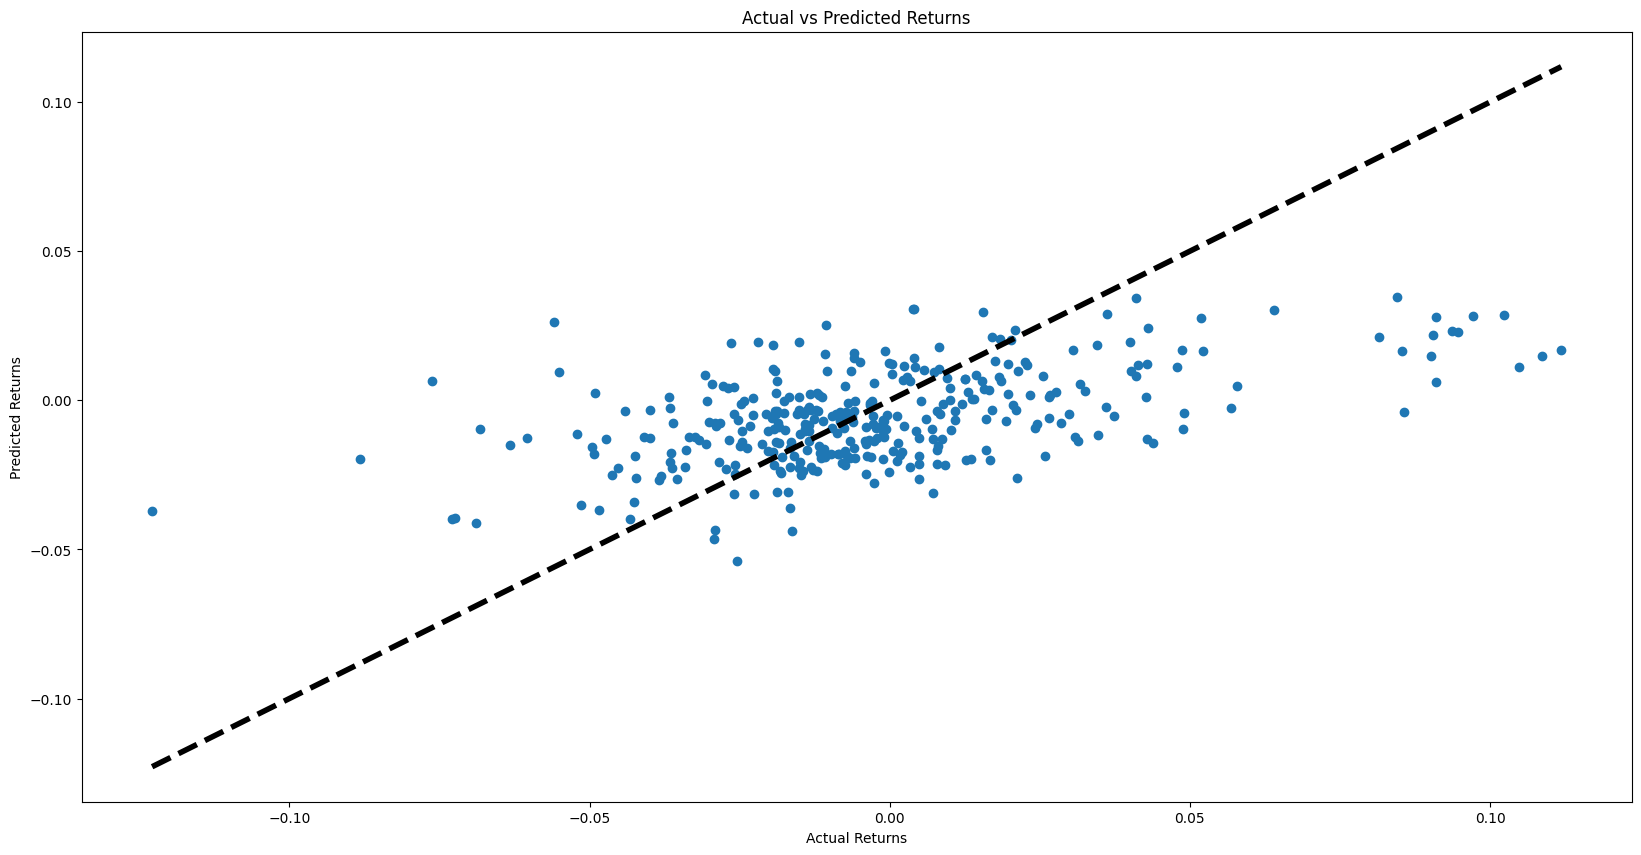

Mean Absolute Error: 0.020486179086702055
Mean Squared Error: 0.0007694129265731367
Root Mean Squared Error: 0.0277382935050651
95% Confidence Interval: +/- 0.05391297526572024
Feature 10 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0007270782177026073


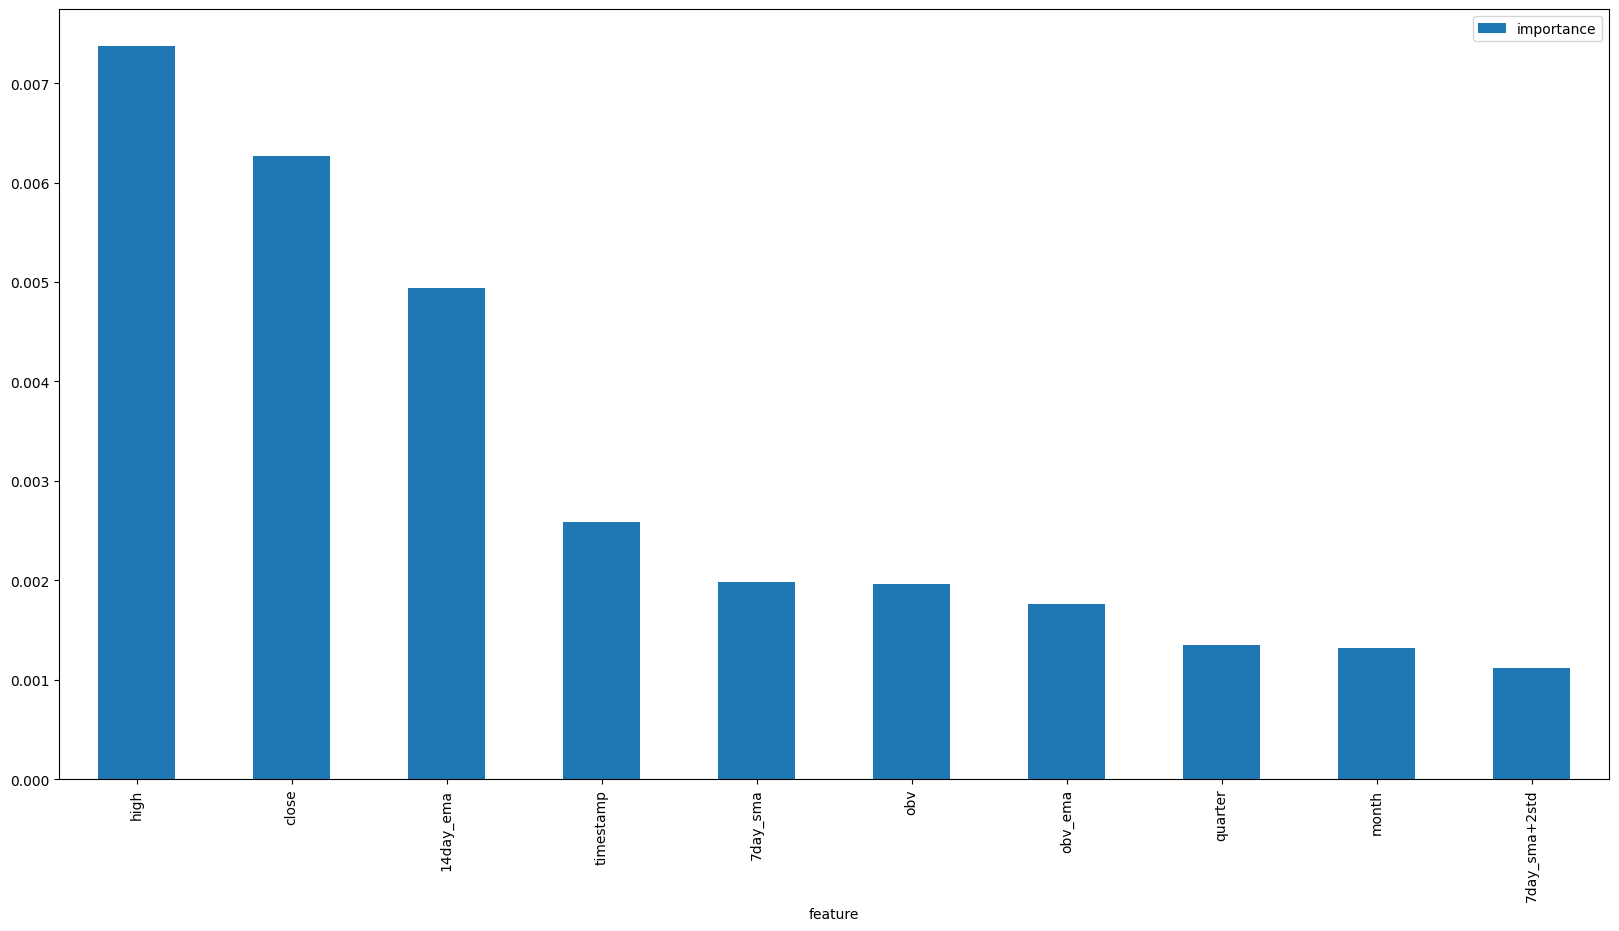

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 799ms/step
Correlation coefficient: 0.5300182837961737


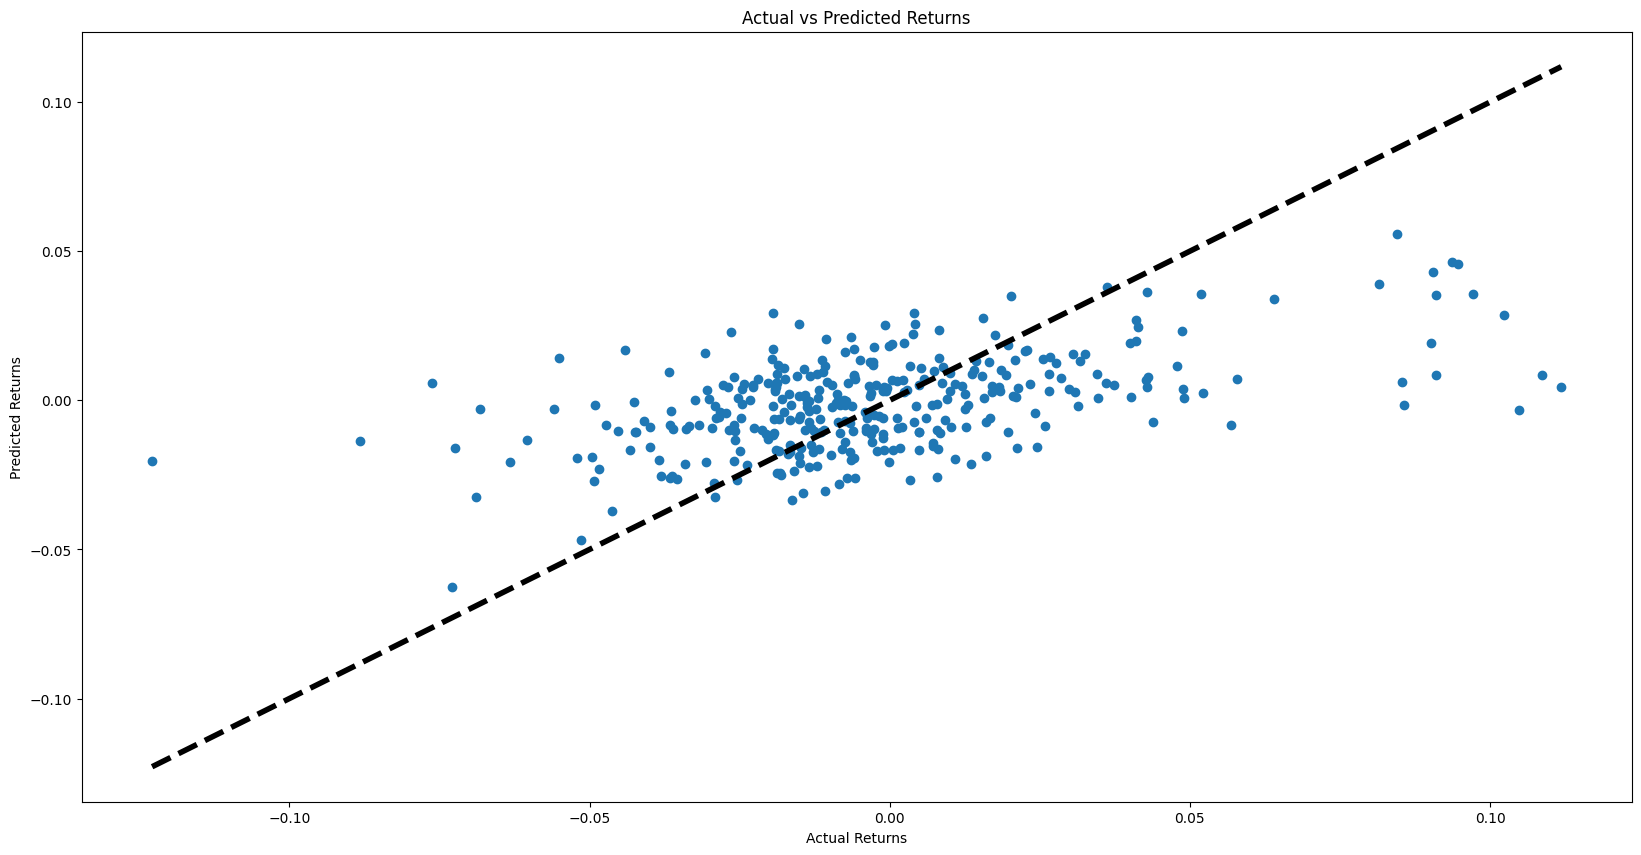

Mean Absolute Error: 0.0206132328049232
Mean Squared Error: 0.0007626205577387035
Root Mean Squared Error: 0.0276155854136519
95% Confidence Interval: +/- 0.05409033747646205
Feature 9 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0007050355197861791


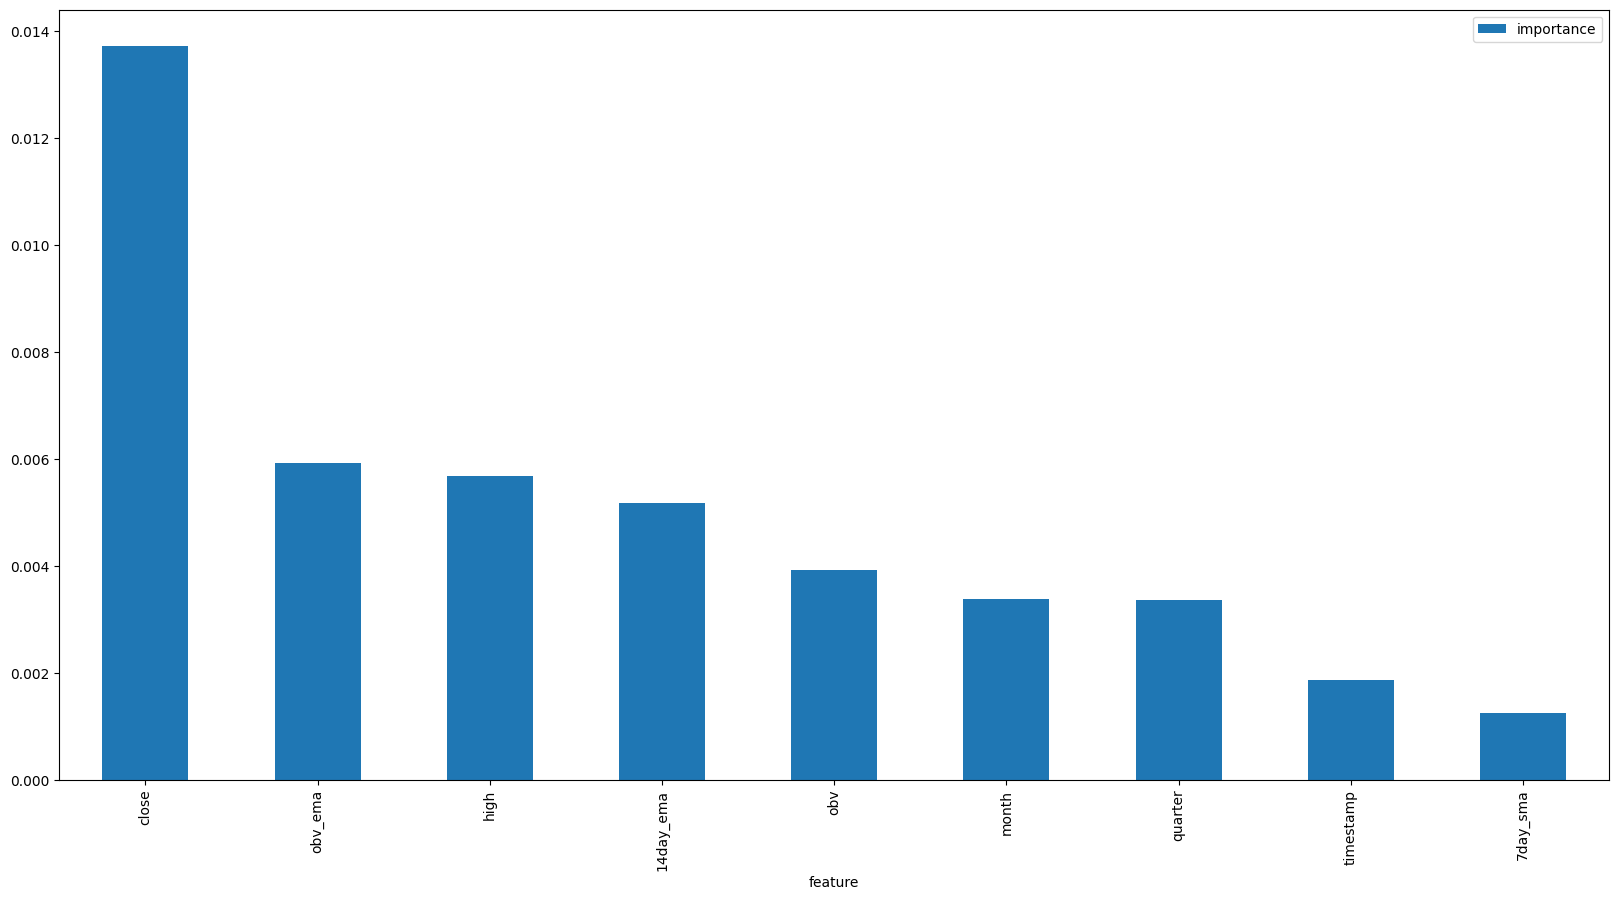

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Correlation coefficient: 0.5832077914477647


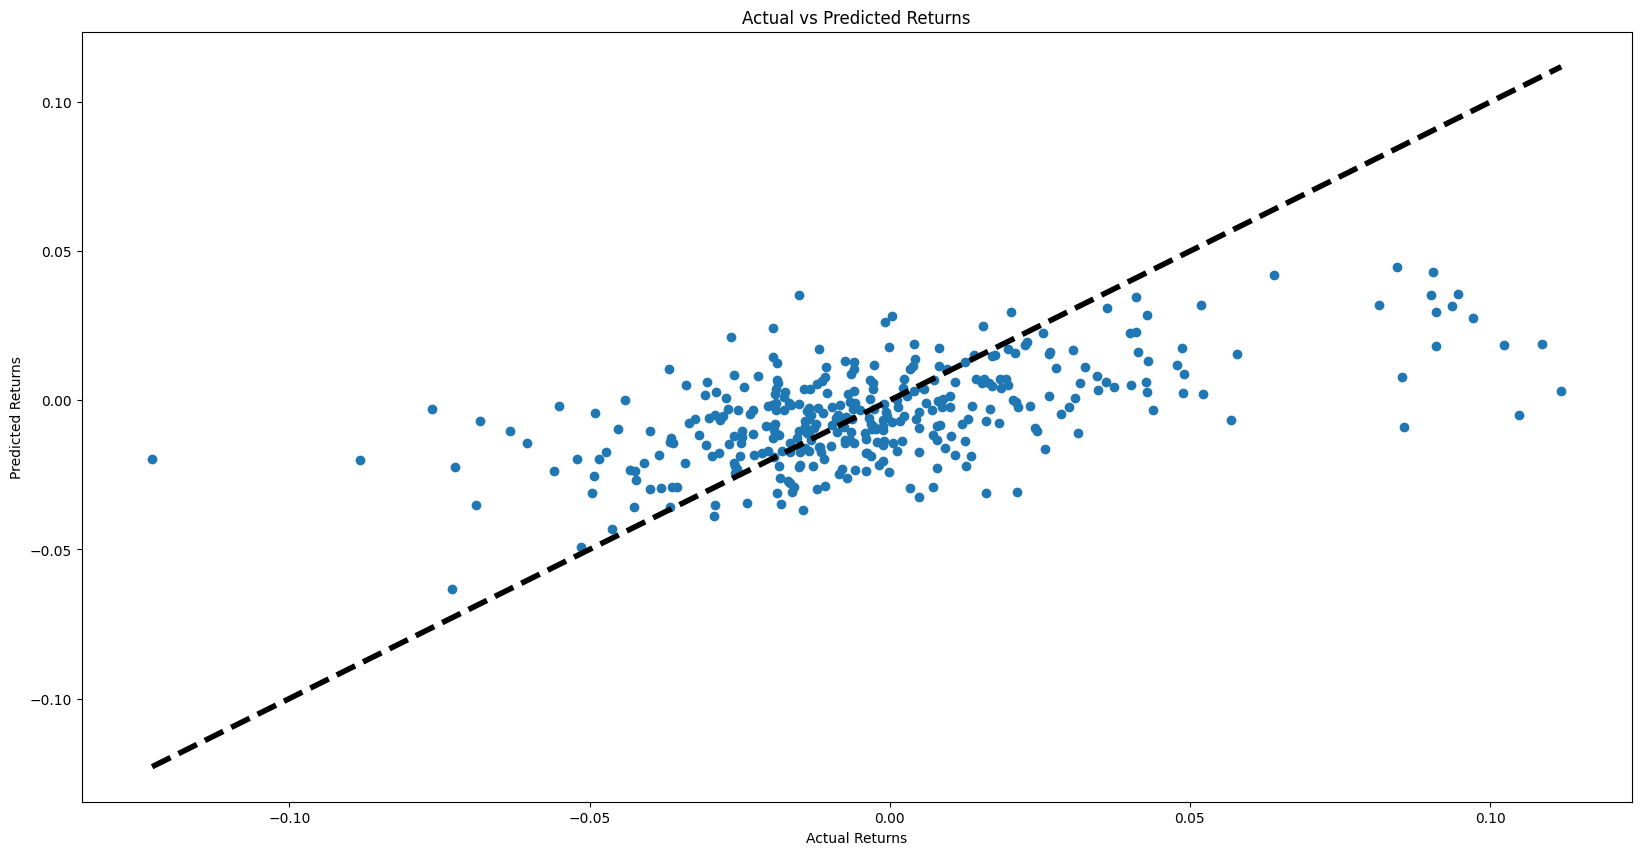

Mean Absolute Error: 0.019242183416934306
Mean Squared Error: 0.0007105210721213201
Root Mean Squared Error: 0.02665560113974772
95% Confidence Interval: +/- 0.05199012267363085
Feature 8 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0007095295392597715


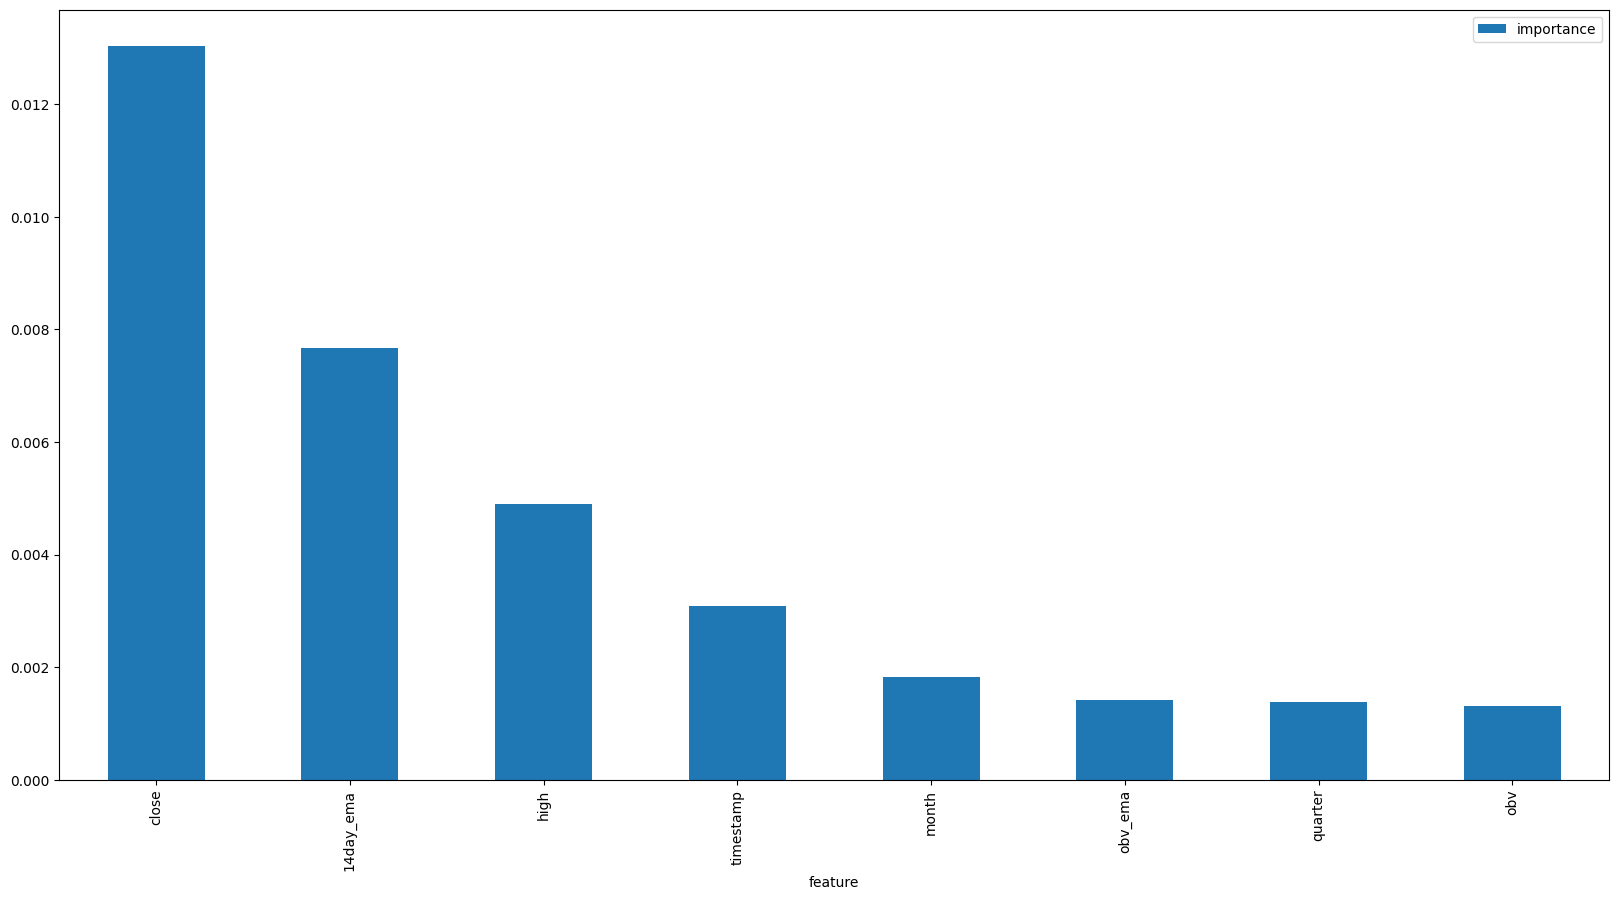

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Correlation coefficient: 0.5518130516682948


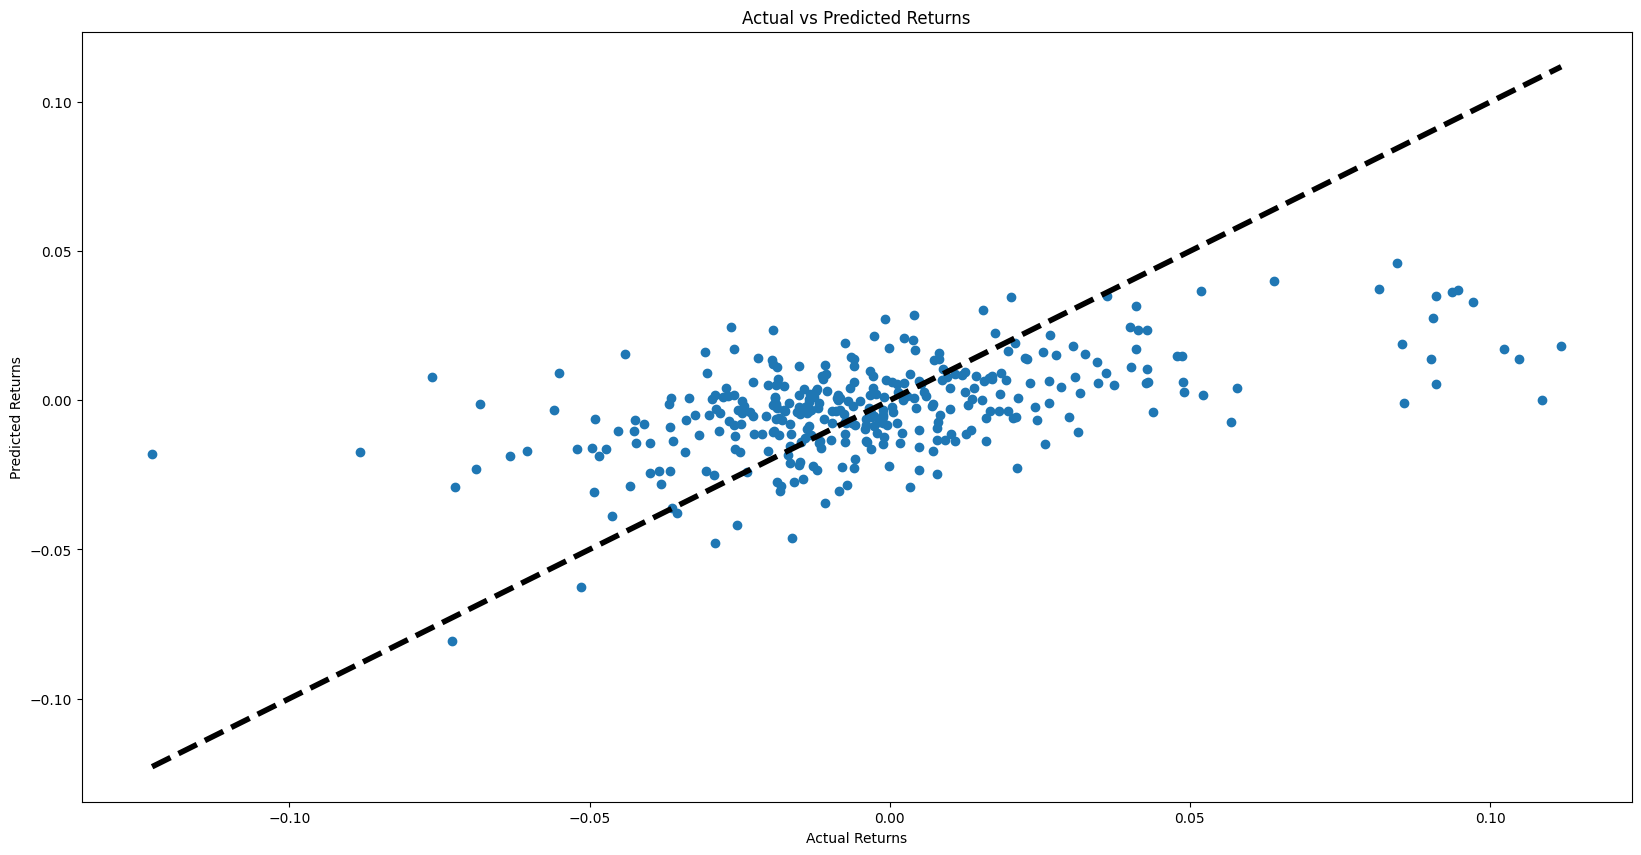

Mean Absolute Error: 0.019980916498566637
Mean Squared Error: 0.0007385666815634588
Root Mean Squared Error: 0.02717658333130673
95% Confidence Interval: +/- 0.05326514141678821
Feature 7 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0007068361737765372


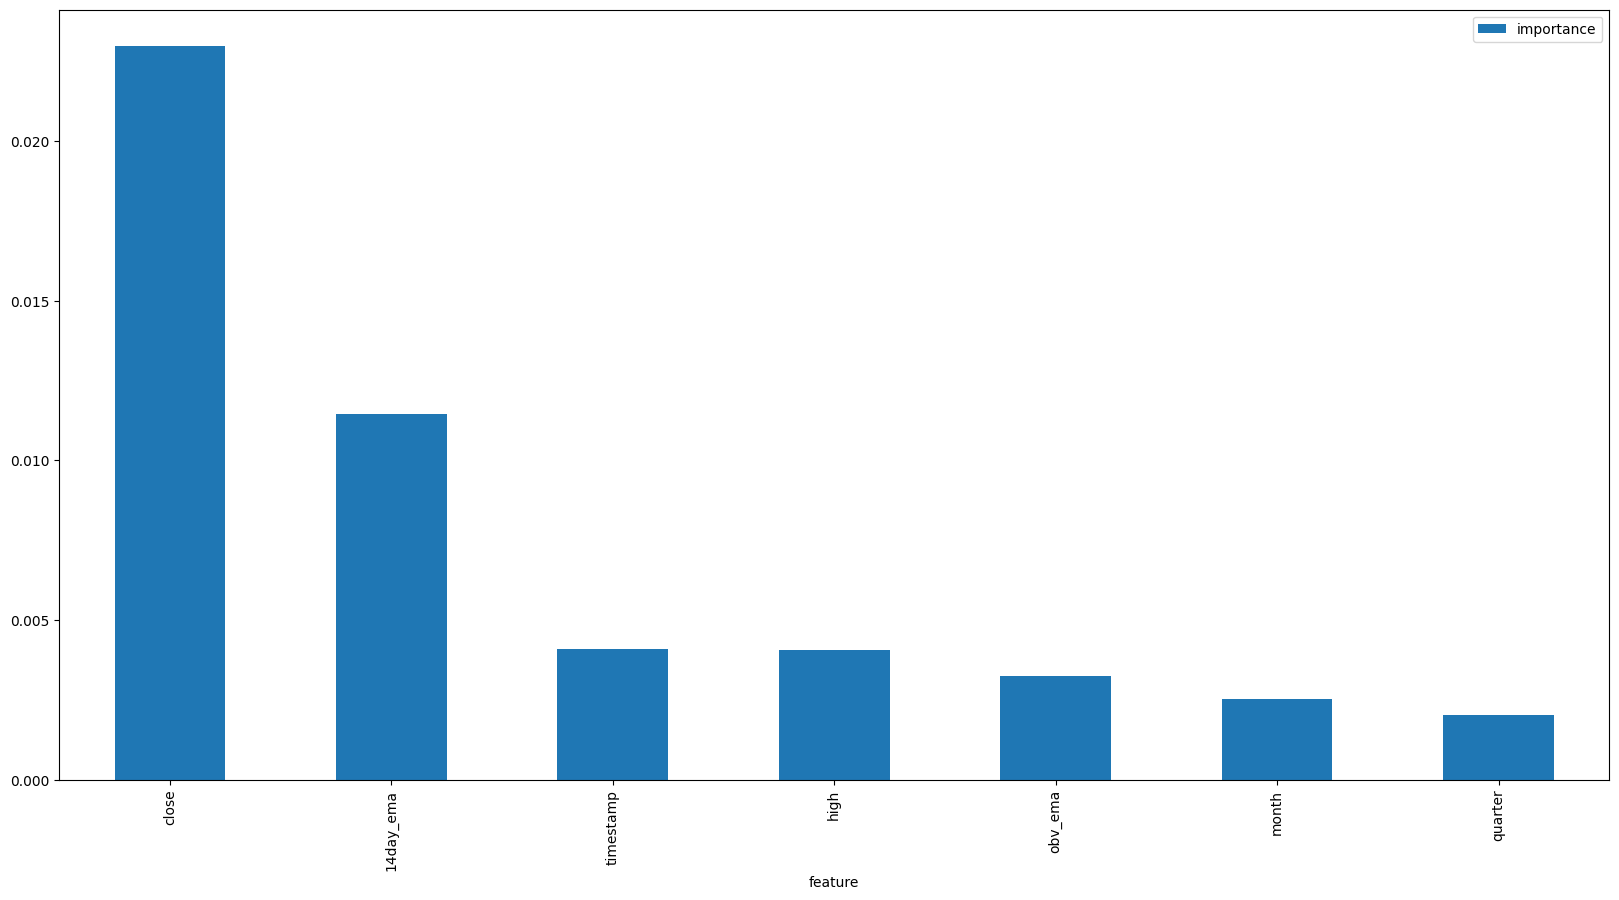

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Correlation coefficient: 0.5369069988907305


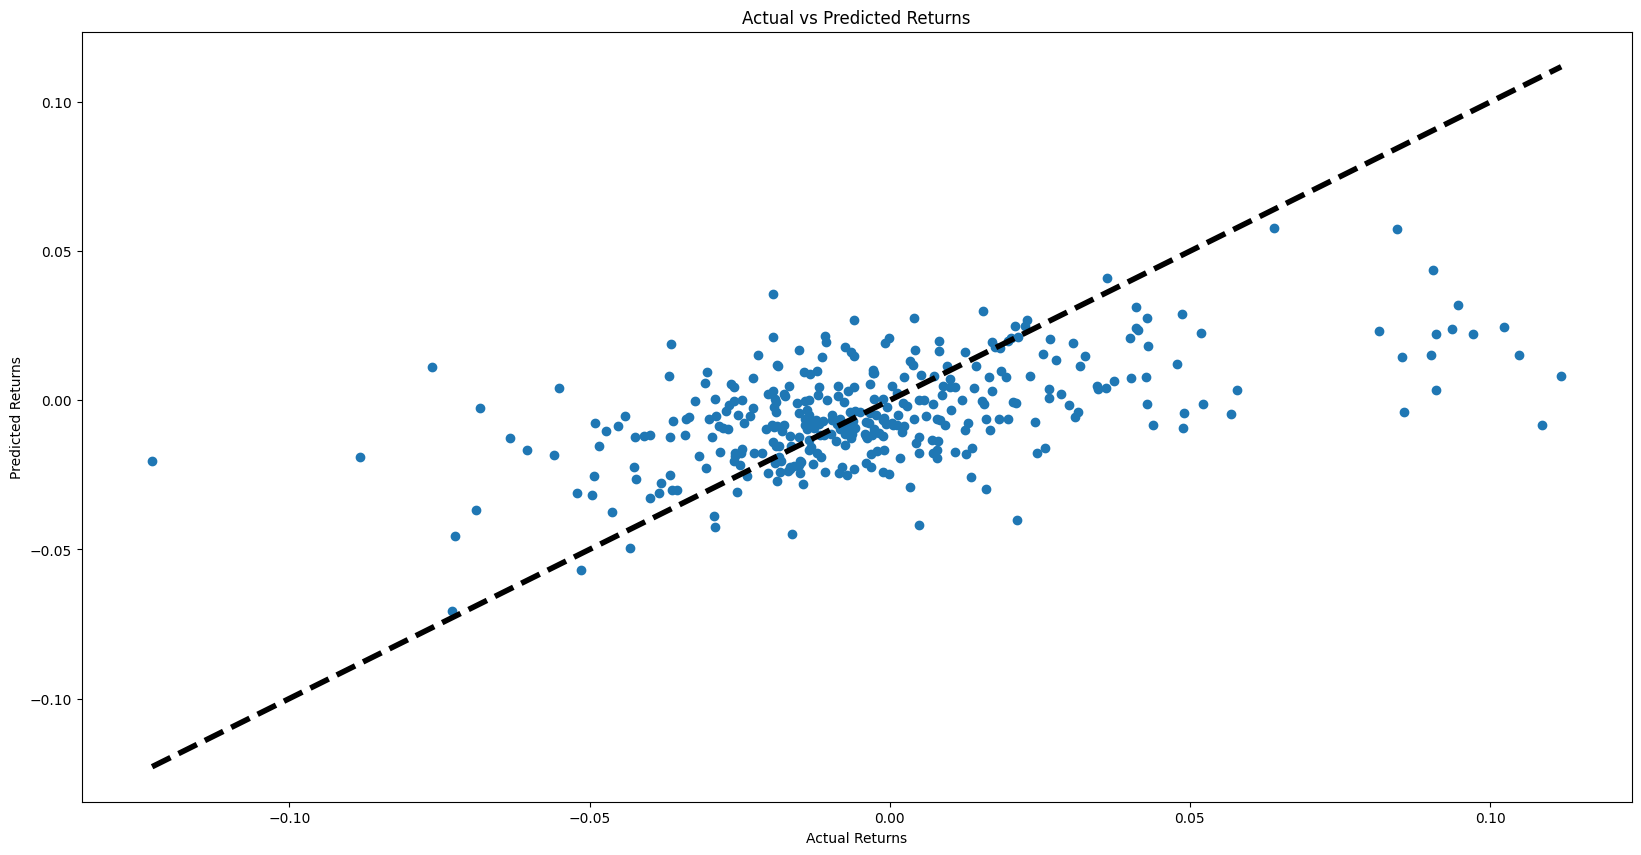

Mean Absolute Error: 0.019576881969723365
Mean Squared Error: 0.0007567389546995167
Root Mean Squared Error: 0.027508888648935213
95% Confidence Interval: +/- 0.05374471917665843
Feature 6 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0006776796071790159


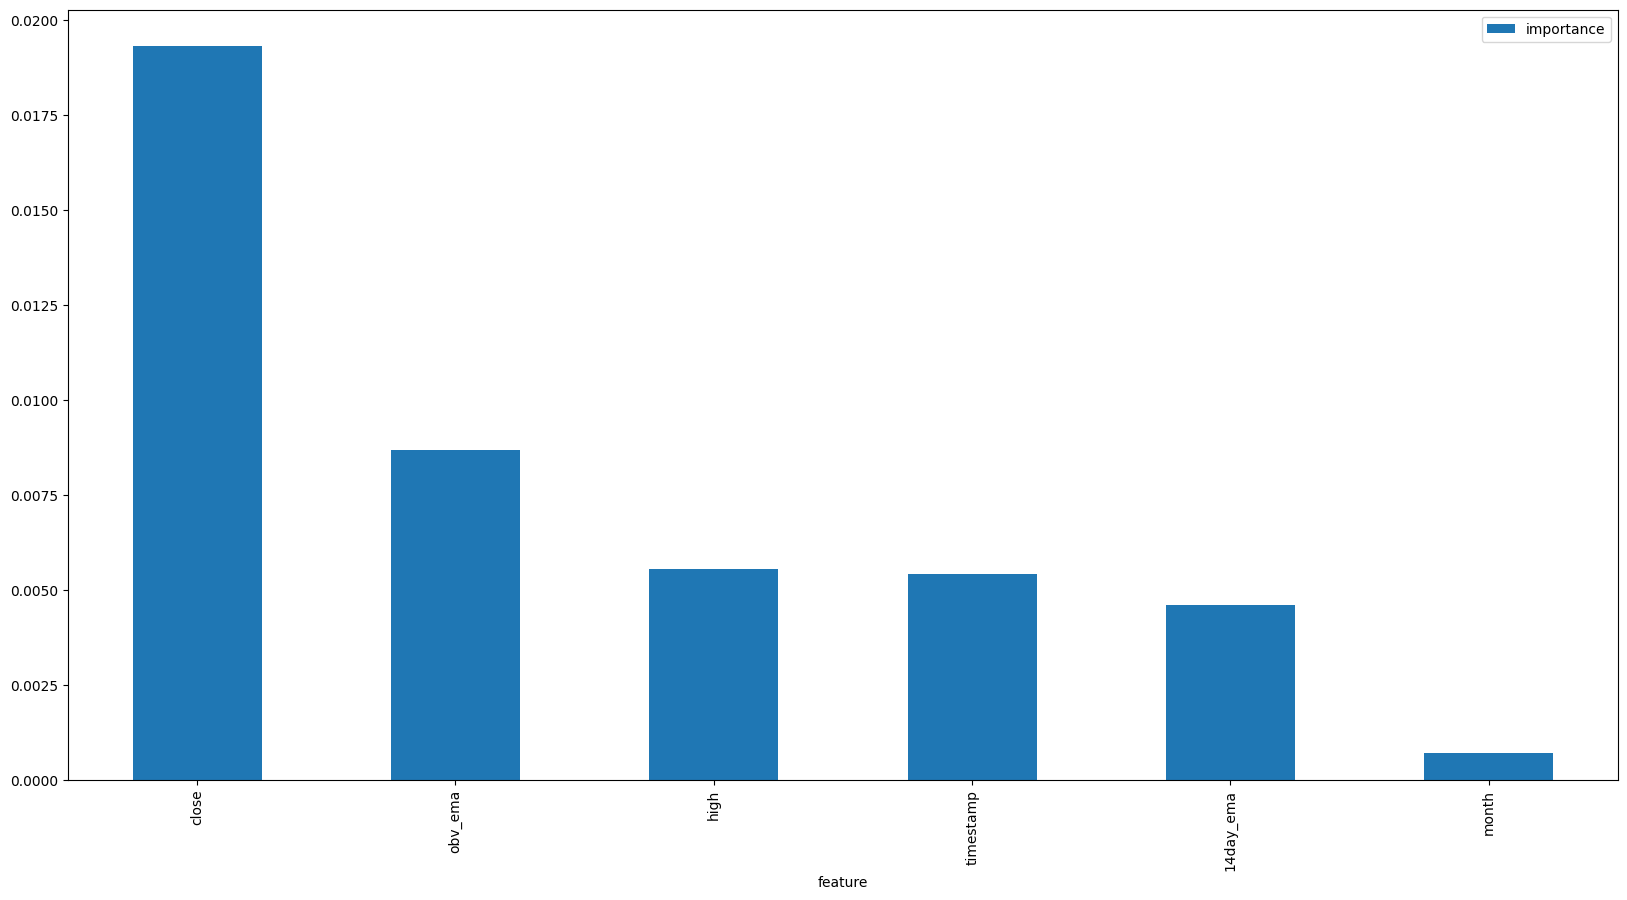

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Correlation coefficient: 0.5958419521442059


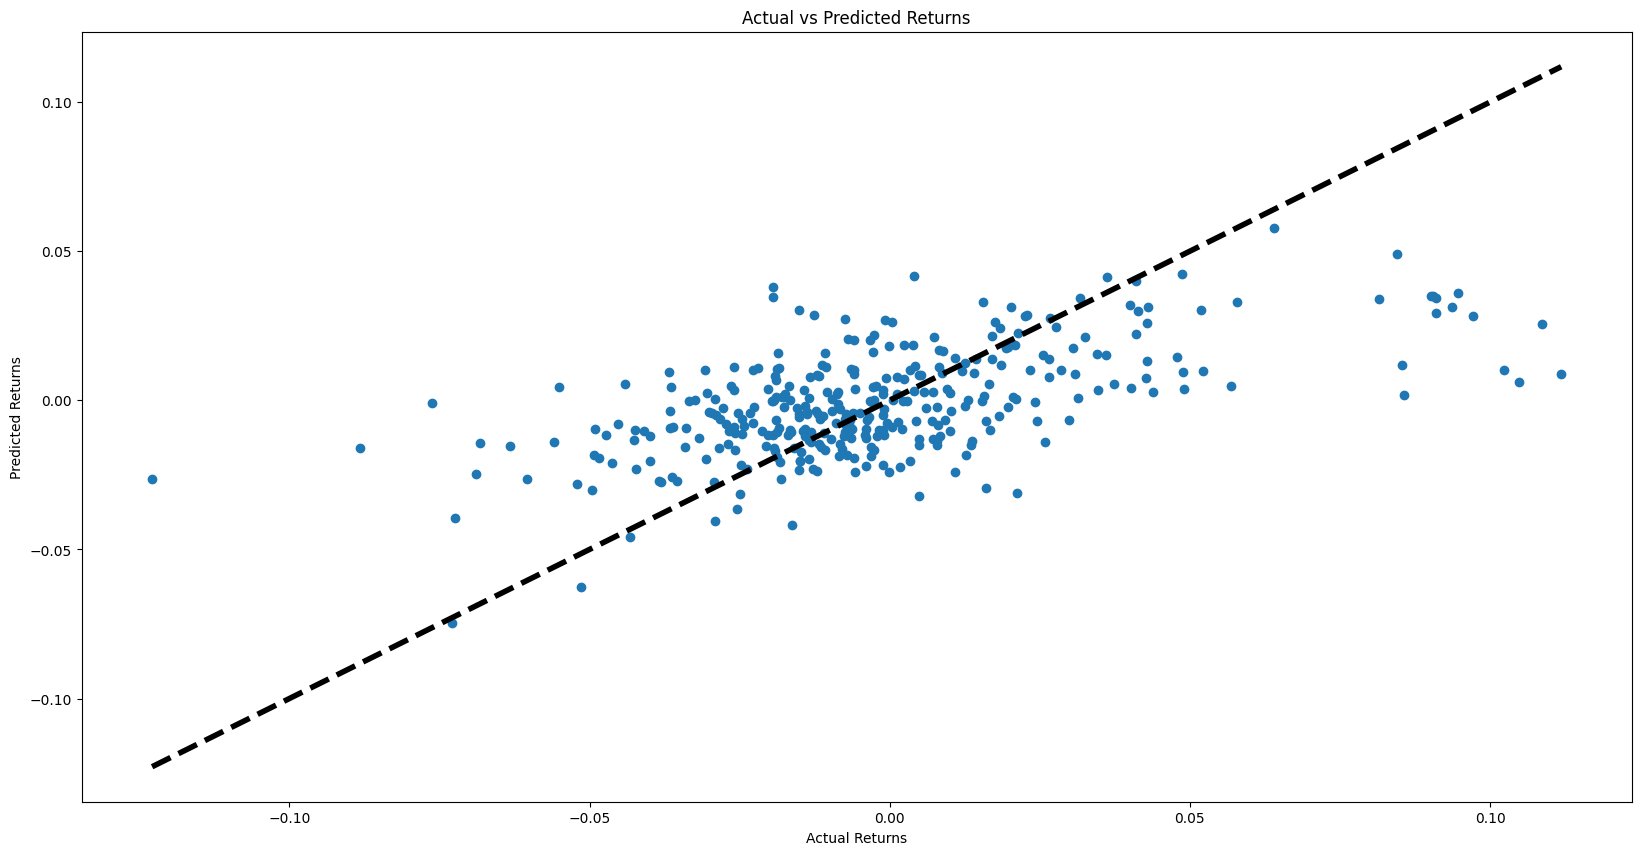

Mean Absolute Error: 0.01910023948317228
Mean Squared Error: 0.0006845569205426976
Root Mean Squared Error: 0.026164038689443524
95% Confidence Interval: +/- 0.05124118036700428
Feature 5 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0007914514668906728


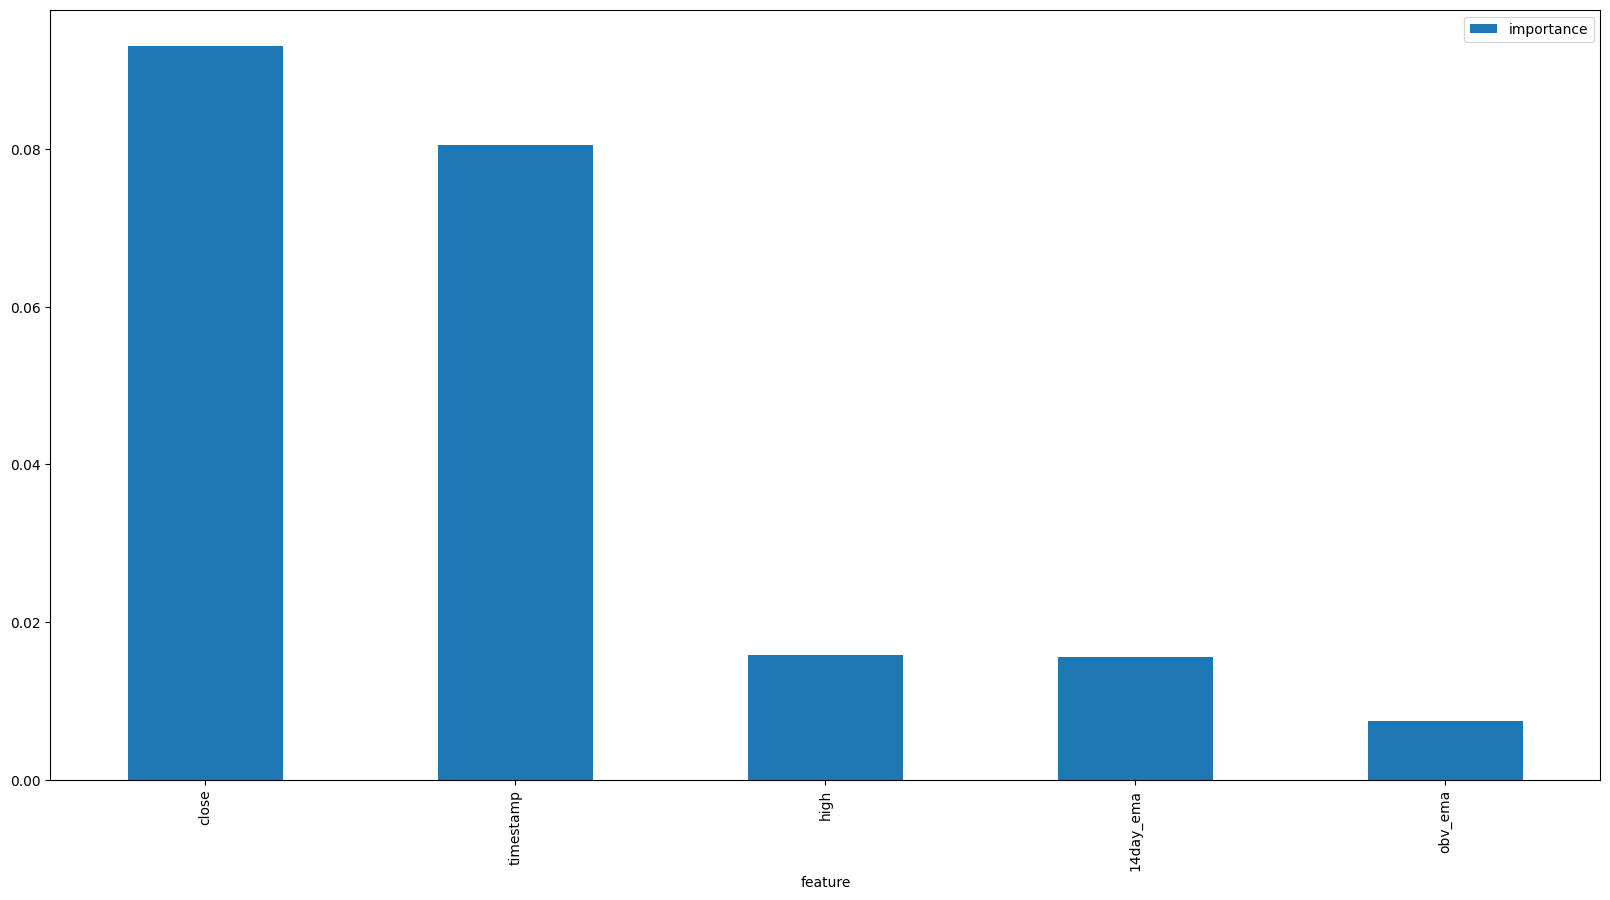

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Correlation coefficient: 0.36480537141169483


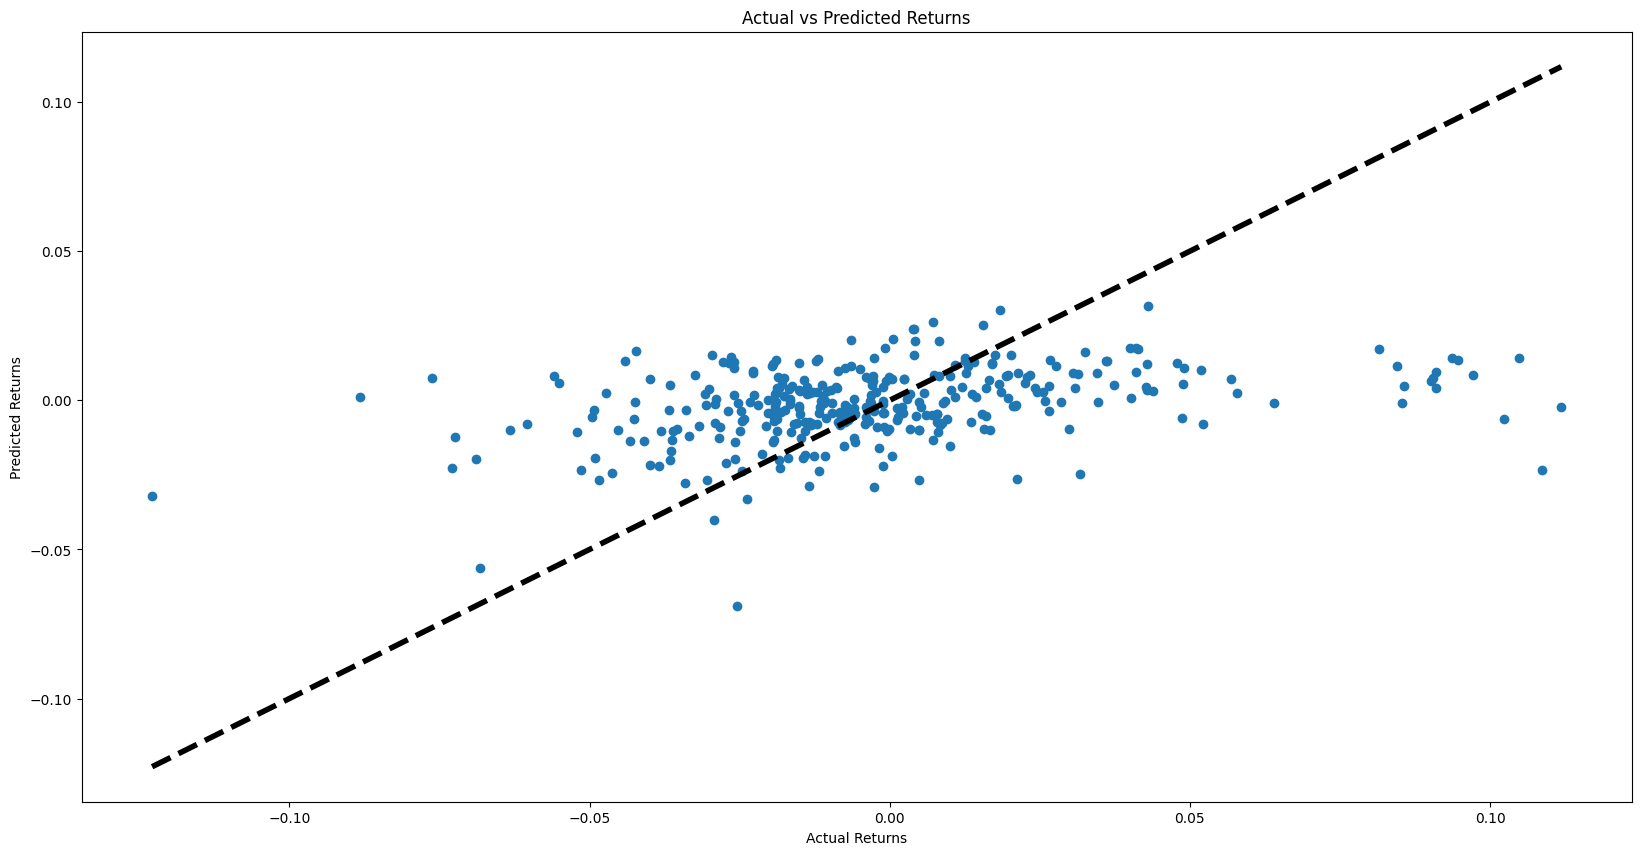

Mean Absolute Error: 0.021670083148439594
Mean Squared Error: 0.000916321500960606
Root Mean Squared Error: 0.030270802780246943
95% Confidence Interval: +/- 0.05931872243539026
Feature 4 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0007874889415688813


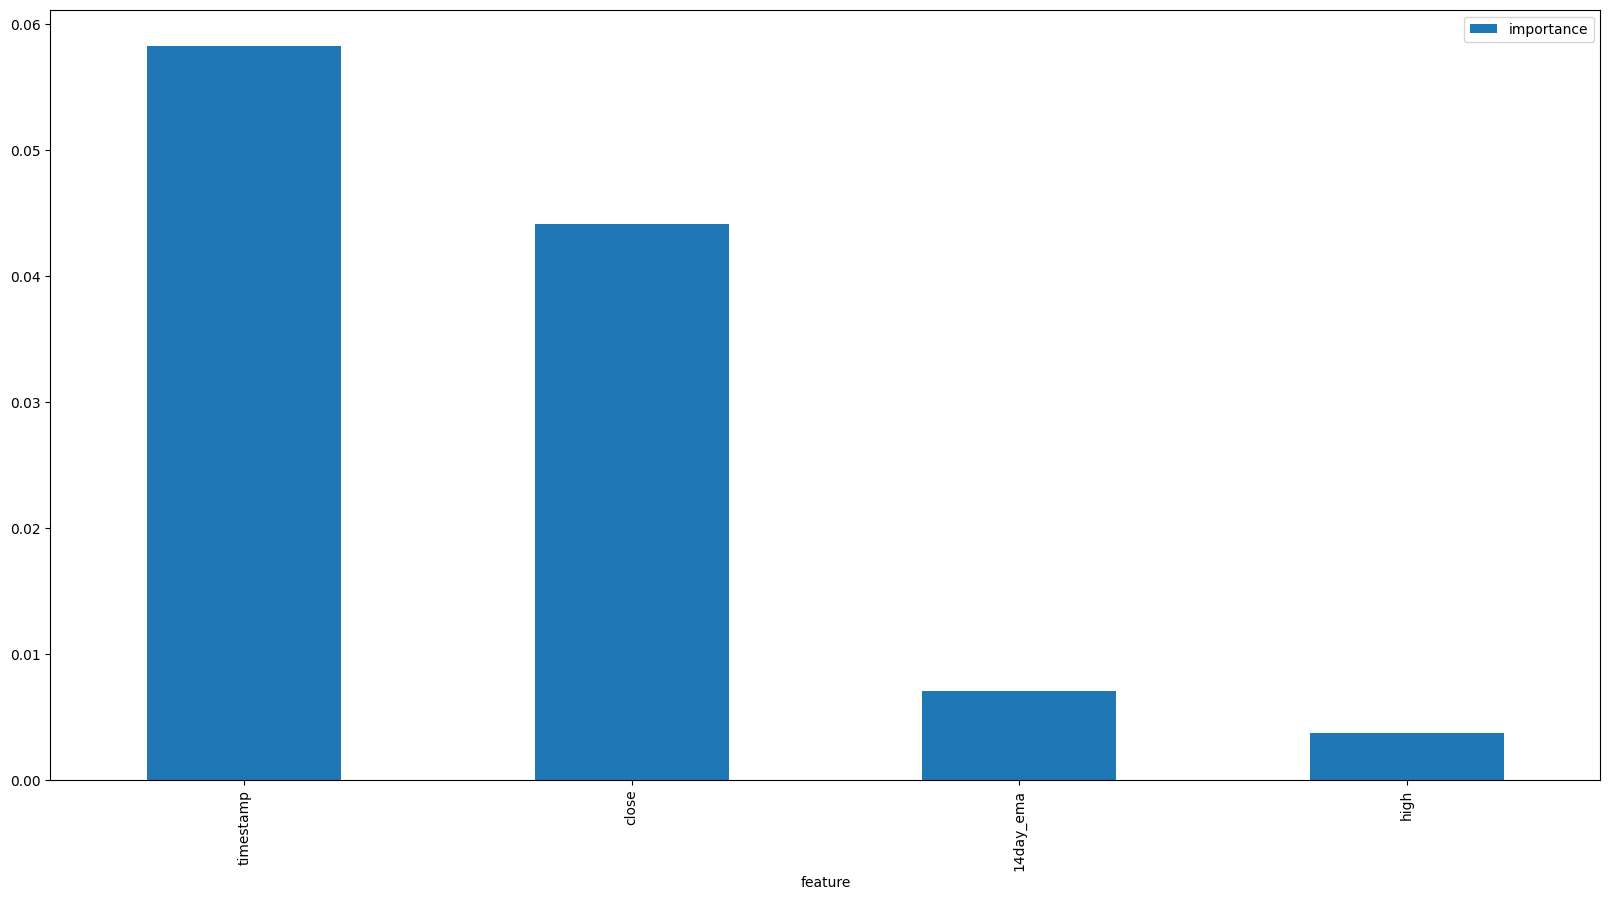

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Correlation coefficient: 0.37212079015002


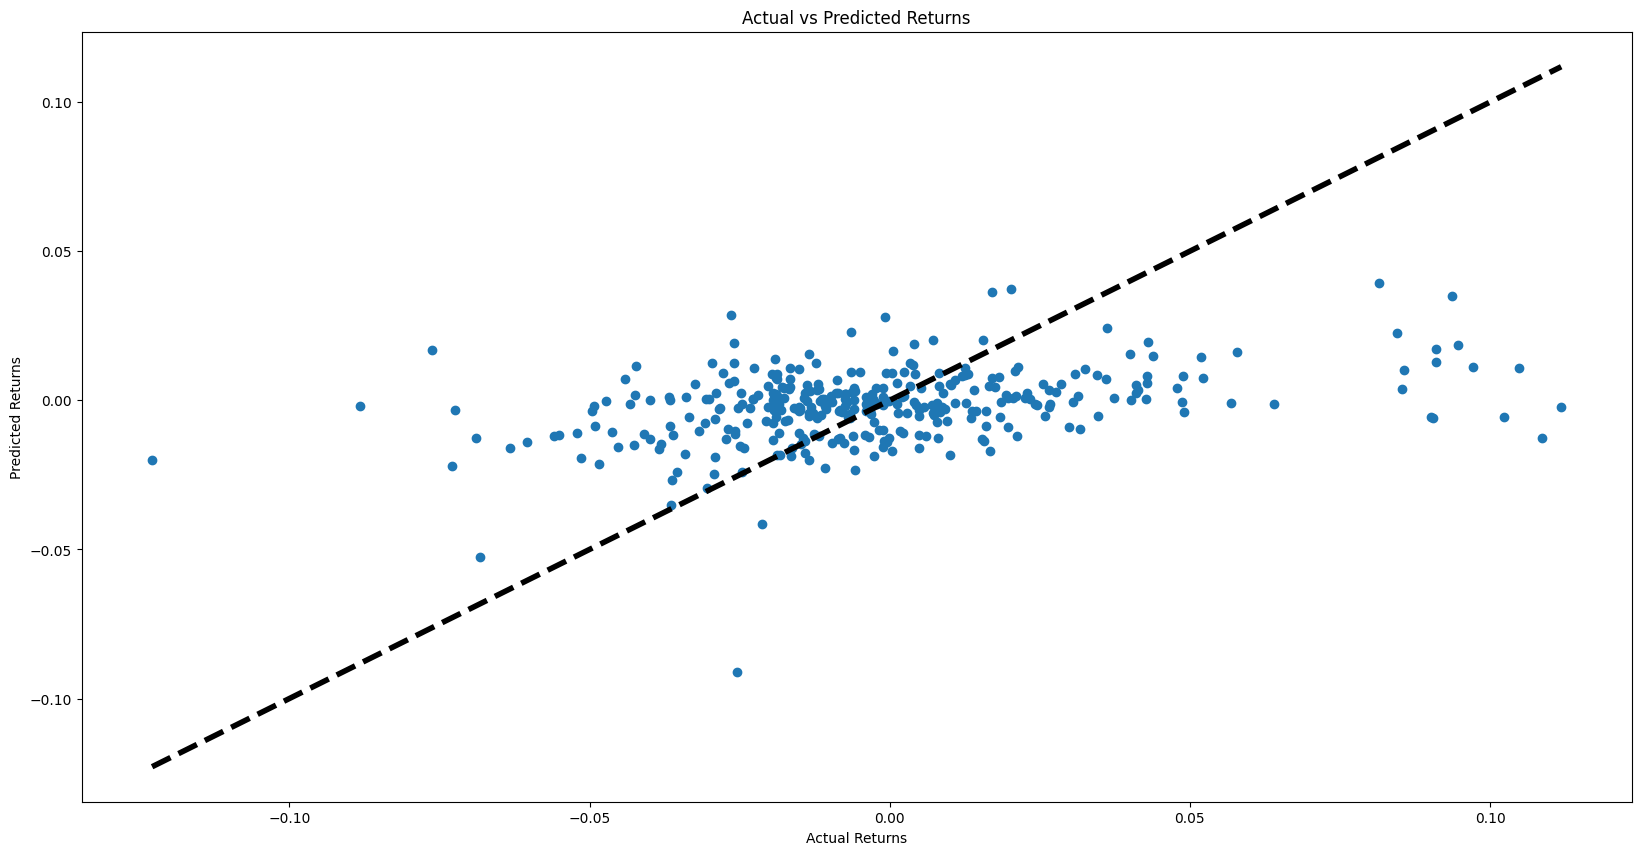

Mean Absolute Error: 0.021939113252385196
Mean Squared Error: 0.0009101097869753966
Root Mean Squared Error: 0.030168025904513483
95% Confidence Interval: +/- 0.059127031814621325
Feature 3 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0007837106822989881


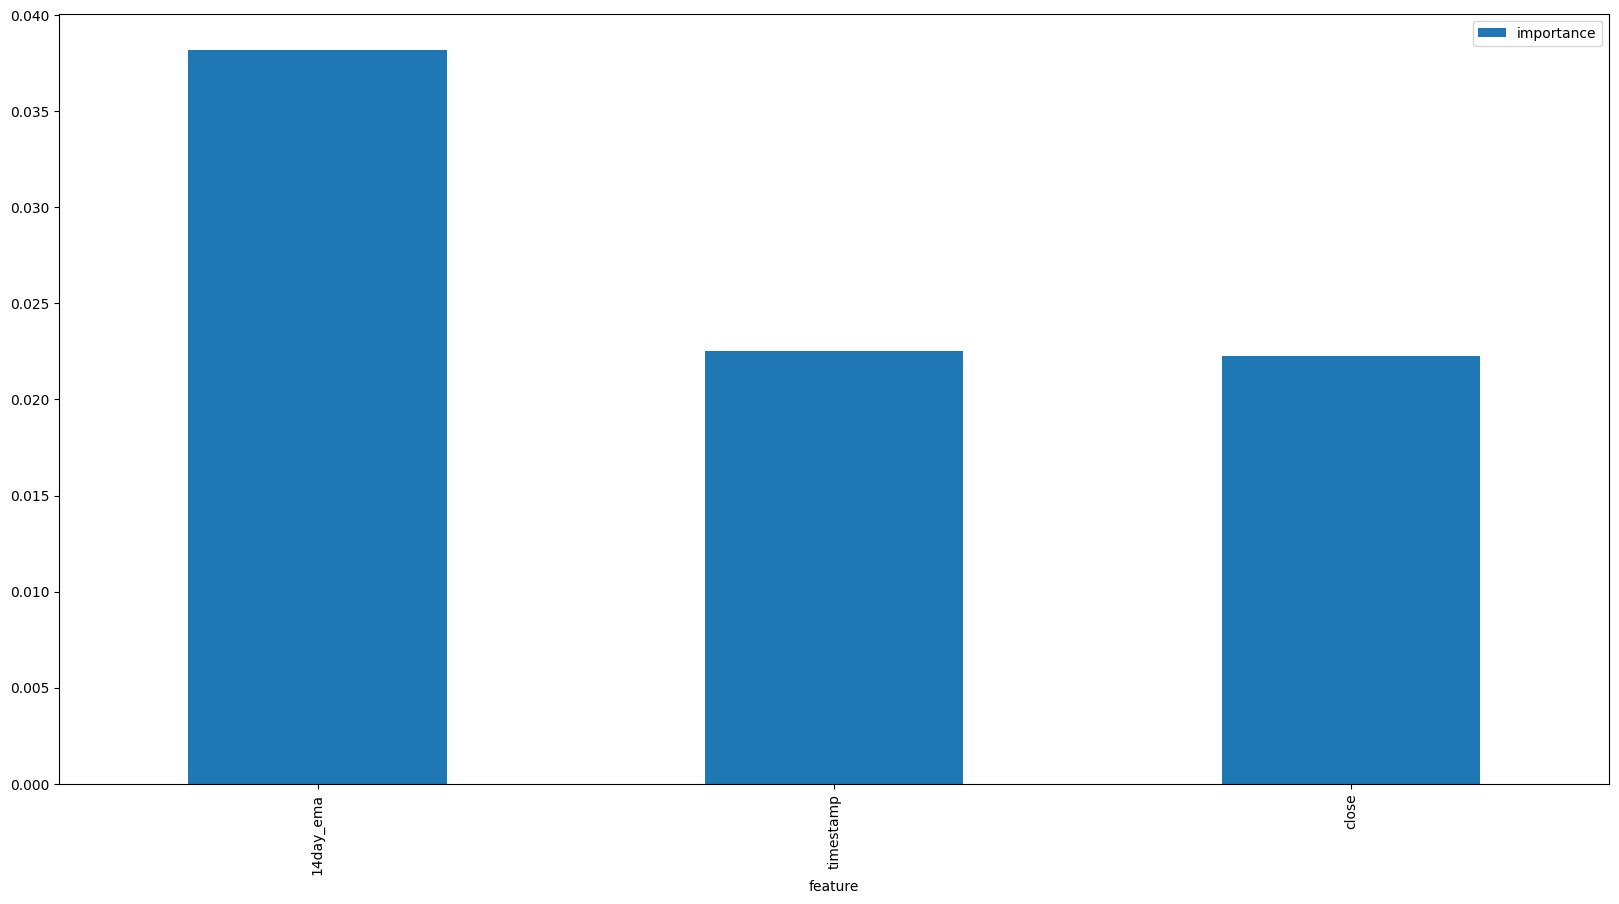

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Correlation coefficient: 0.3637735966454118


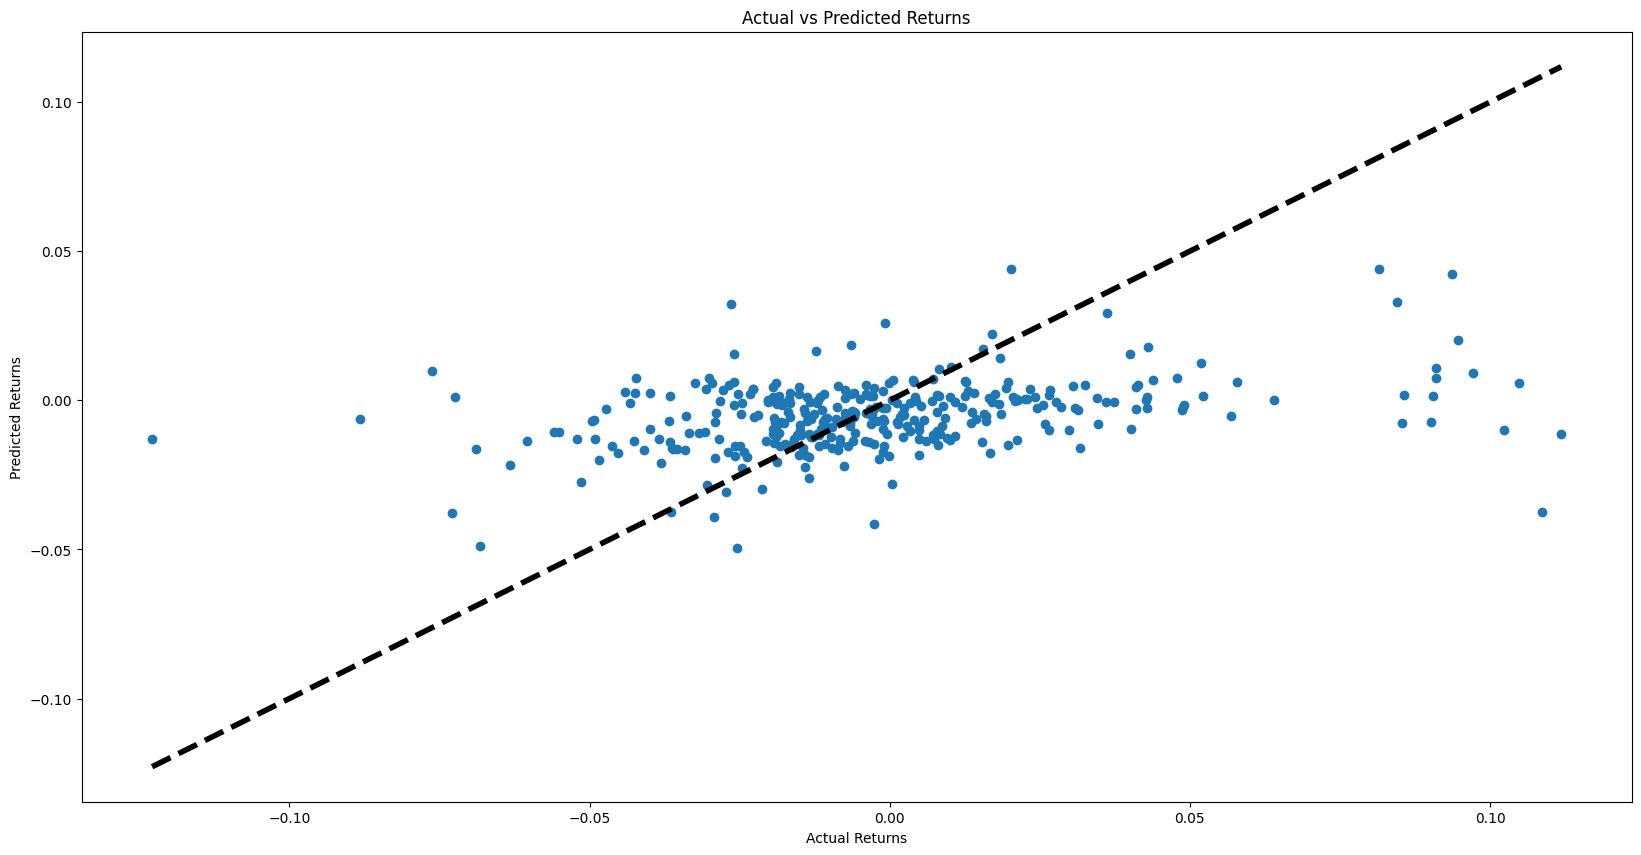

Mean Absolute Error: 0.021263884093567095
Mean Squared Error: 0.0009254032323263676
Root Mean Squared Error: 0.030420441027808384
95% Confidence Interval: +/- 0.05933708388425385
Feature 2 out of 36


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Average baseline performance:  0.0007608875360650321


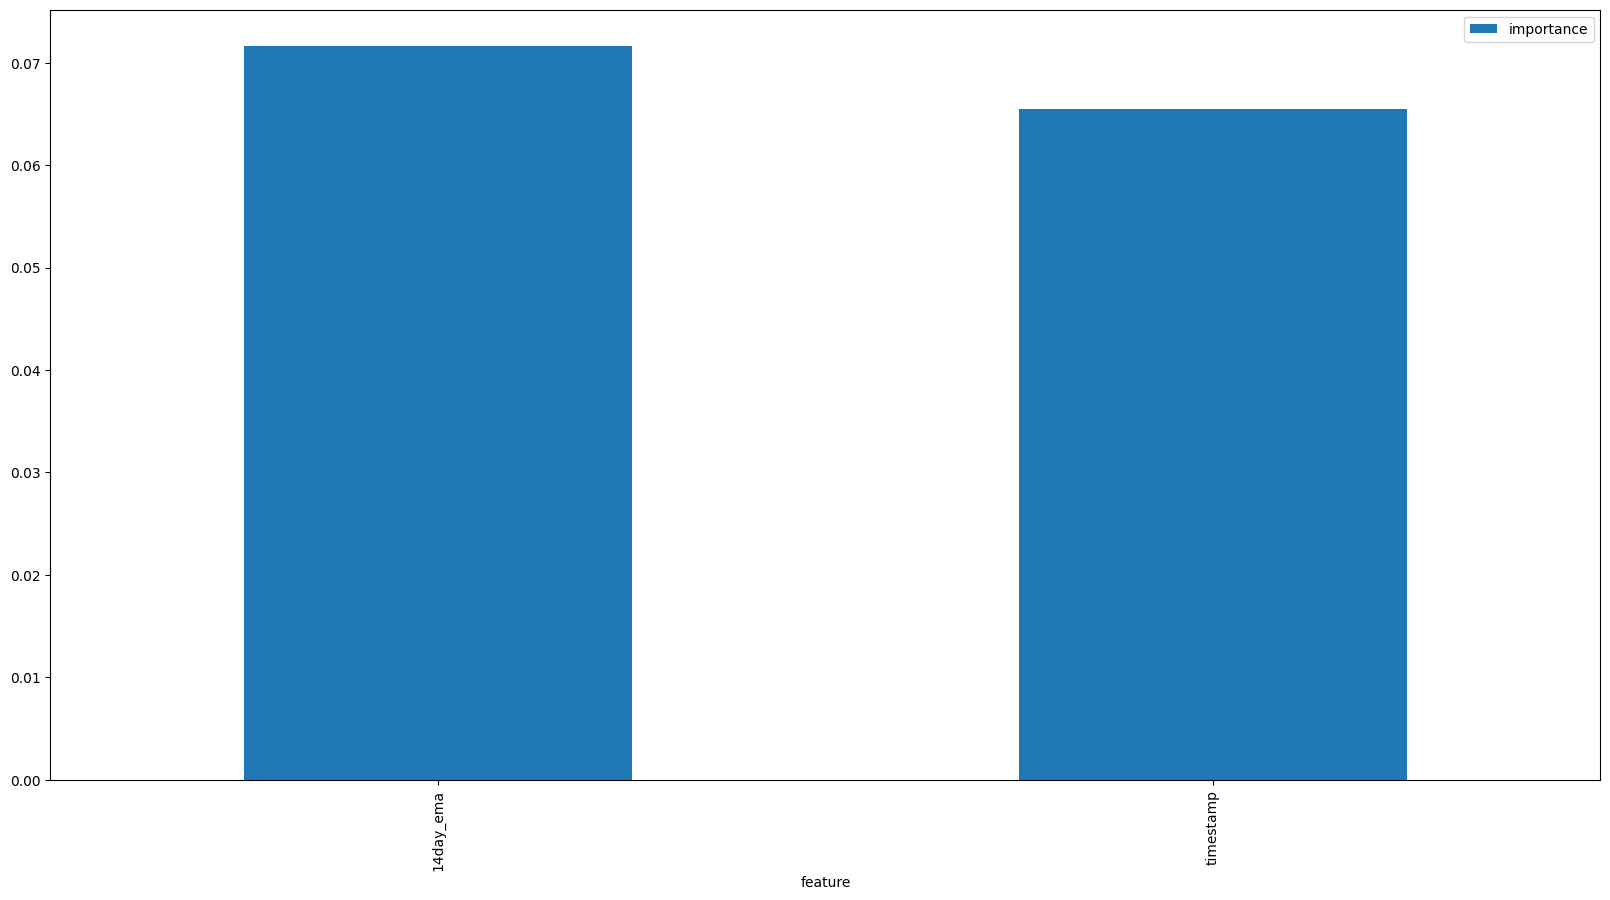

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Correlation coefficient: 0.4493273169489588


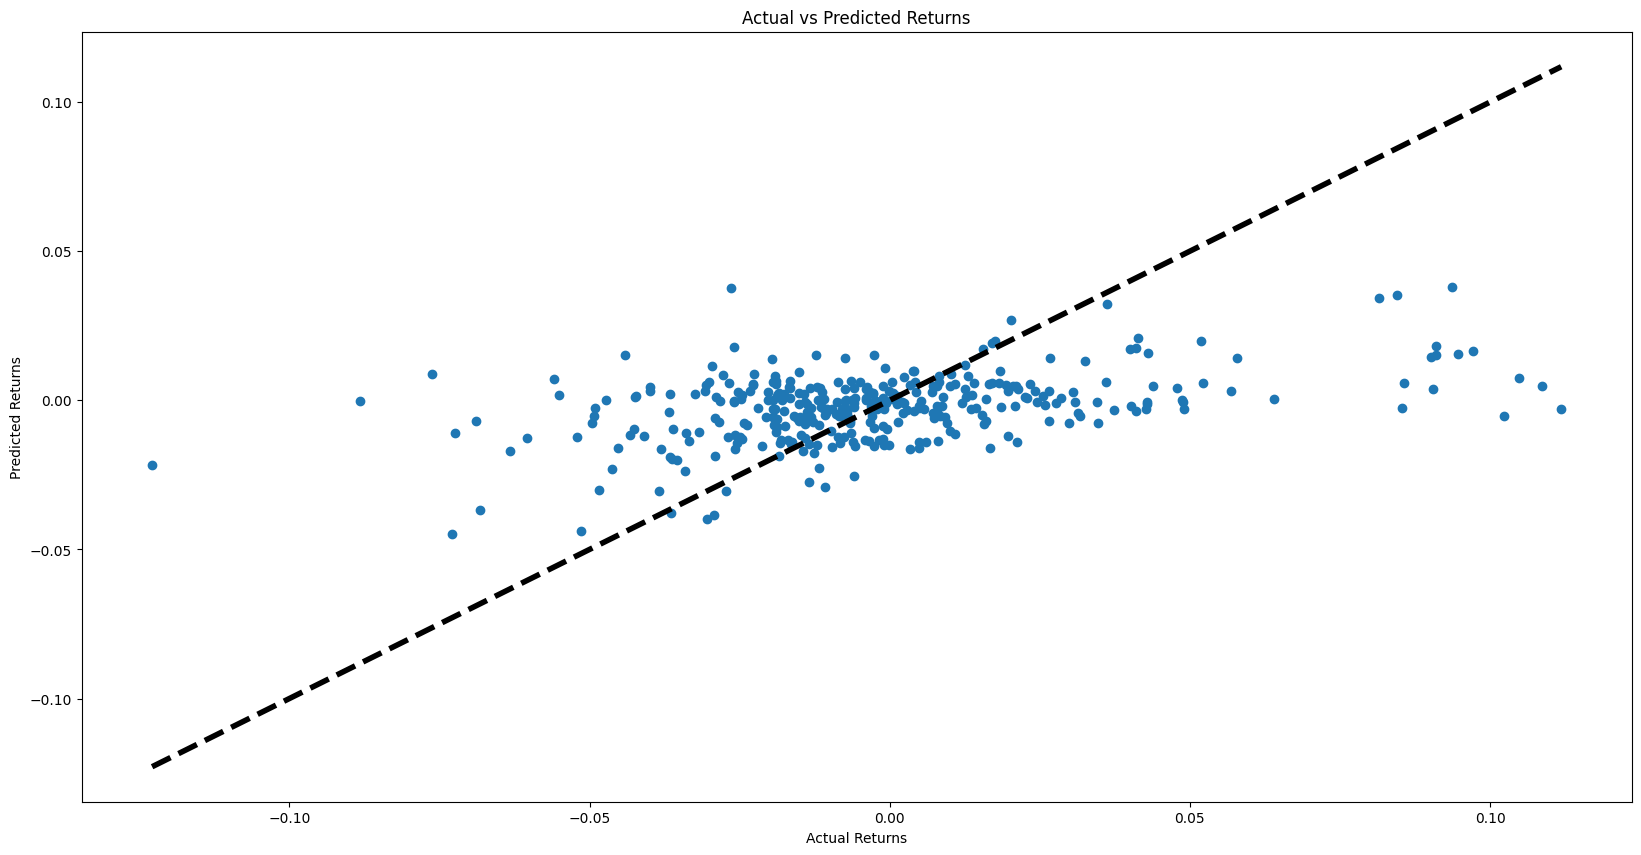

Mean Absolute Error: 0.020839224174254597
Mean Squared Error: 0.0008525325206828596
Root Mean Squared Error: 0.02919815954273248
95% Confidence Interval: +/- 0.05722603595593409


In [8]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
powerTransformer = PowerTransformer()

columns = X.columns

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = powerTransformer.fit_transform(X_train)
X_test = powerTransformer.transform(X_test)

# Reshape data for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# t1 = threading.Thread(target=evaluate_optimal_number_of_features, args=(X_train, y_train, columns, 3))
# t2 = threading.Thread(target=evaluate_optimal_number_of_features, args=(X_train, y_train, columns, 2))

# t1.start()
# t2.start()

# t1.join()
# t2.join()

evaluate_optimal_number_of_features(X_train, y_train, columns, 3)
